# Pitch Use and Performance

# Table of Contents
[Section 1 - Introduction](#Introduction)\
[Section 2 - Loading Dataset](#LoadingDataset)\
[Section 3 - Data Cleaning](#DataCleaning)\
[Section 4 - Calculating Percentage Thrown and wOBA Against](#CalculatingPercentageThrownandwOBAAgainst)\
[Section 5 - Creating the Appearances and Samples DataFrames](#CreatingtheAppearancesandSamplesDataFrames)\
[Section 6 - Fitting Models](#FittingModels)\
[Section 7 - Analysis of Models](#AnalysisofModels)\
[Section 8 - Discussion](#Discussion)\
[Section 9 - References](#References)

<a id='Introduction'></a>

# Section 1 - Introduction

This project is part of a series of projects where I aim to optimize every pitcher's pitch mix. For this project a pitcher's *pitch mix* is defined as the percentage thrown of each of their pitch types. For example, Cory Abbott's pitch mix in 2022 was 50.9% four-seam fastball, 22.2% knuckle curve, 26.9% slider.

For this project an *optimal pitch mix* is defined as the pitch mix that minimizes batter success against the pitcher. Batter success against a pitcher and pitcher success is generally complementary, as you can view a plate appearance in the as a matchup of two players with opposite interests. In the broader context of the game the batter wants their team to score runs and the pitcher doesn't want the batter's team to score runs. In the narrower context of a single plate appearance the result of the matchup contributes to both players' broader goals. How much the result of the plate appearance contributes to either player's goal depends on many factors such as the situation in the game and the result of the plate appearance itself. Since determining the level of success attributed to the result of the plate appearance is nuanced, claiming that batter success is exactly complementary of pitcher success is naive. However, it serves as a general benchmark that in a plate appearance the batter is successful if the result is one that contributes positively to their team's run scoring, and the pitcher is successful if they prevent those results.

The statistic that I've chosen to measure pitcher success is *wOBA against* (called *wOBA* from here on). You can read more about wOBA on *Fangraphs* [here](https://library.fangraphs.com/offense/woba/).

The first reason that I've chosen to use wOBA is that it better represents the value of events to a team's run scoring (or run prevention from the pitching team's perspective) than traditional batting (batting against) statistics.

The second reason is that it is inclusive of a larger set of events than traditional pitching stats. Traditional pitching stats like ERA or FIP look at run scoring on a more binary scale than wOBA, and don't reflect the events that contribute to run scoring. For example, a pitcher allowing a double is a negative event for them, but whether that event is reflected in their ERA depends on the events after the double.

The third, and final, reason that I've chosen wOBA is that is limited to the results of plate appearances. For a pitcher, getting looking or swinging strikes is generally good and having the batter take balls is generally bad, but their relationship to team run prevention is more complex than the results of a plate appearance.

Part of what makes pitchers successful is ensuring that the batter doesn't know what pitch type is coming next. It is likely that if a pitcher throws a pitch type more or less often in a given time period then batters may have different results against that pitch type in that time period.

My motivation for this series of projects comes from the understanding that pitchers should throw their best pitch type(s) (in a vacuum, without considering use) as often as they can, but without throwing them too often to the point of increased batter performance against the pitch type(s) due to familiarity.

In this project I will create a model to quantify the effect of increasing or decreasing use of a pitch type on the wOBA of that pitch type.

When considering a pitcher's wOBA, it can be represented as a weighted average of their wOBA on each of their pitch types weighted by the percentage that they threw the pitch. 

Say a pitcher throws $n$ pitch types, $x_{i}$ is their percentage thrown of pitch type $i$ across the full season, and $wOBA_{i}$ is their wOBA of pitch type $i$ (it will be shown later that the maximum number of pitch types that a pitcher throws in the sample is eight, and the number of possible pitch types considered is ten).

Then their wOBA is as follows.

$wOBA = wOBA_{1} \cdot x_{1} + ... + wOBA_{n} \cdot x_{n}$

For example, the weighted average of Cory Abbott's wOBA in 2022 was $0.363 = 0.329 \cdot 0.509 + 0.374 \cdot 0.222 + 0.422 \cdot 0.269$.

The goal of this series of projects, is to optimize each pitcher's pitch mix. Optimizing a pitcher's pitch mix using the above formula, that is finding the values ${x_{1}, ..., x_{n}}$ that minimizes wOBA, has a simple solution. I will denote $wOBA^{*}$ the pitcher's _optimal wOBA_, and ${x^{*}_{1},...,x^{*}_{n}}$ their _optimal pitch mix_ (the pitch mix that minimizes wOBA). The solution to the above formula is $wOBA^{*} = wOBA_{i} \cdot 1$ where $i = \{i : wOBA_{i} = min\{wOBA_{1},...,wOBA_{n}\}\}$, which is throwing their pitch type with the lowest wOBA all the time. This is a simple solution, but is unrealistic in practice as batters will quickly catch on and anticipate that pitch type every pitch. Outside of a few select pitchers in history, batters knowing with certainty (or even near certainty) which pitch type is coming is not a good strategy for a pitcher.

It's reasonable to conclude that a pitch type's wOBA is then dependent (to some extent) on how often the pitcher throws the pitch type. That means $wOBA_{i} = wOBA_{i}(x_{i})$.

To begin representing $wOBA_{i}(x_{i})$, all pitcher's pitch types cannot be considered equal and some pitchers' pitch types are better than others, by factors such as velocity, movement, or location. To reflect this, I will consider the pitcher's season wOBA of the pitch type as the baseline performance of each pitch type against which to measure the effect of increasing or decreasing pitch use.

Symbolically, where $wOBA_{i}$ is the pitcher's _season wOBA_, and $\Delta wOBA_{i}(x_{i})$ is a function representing change in wOBA of pitch type $i$ as an effect of changing pitch use on pitch type $i$, this is as follows.

$wOBA_{i}(x_{i}) = wOBA_{i} + \Delta wOBA_{i}(x_{i})$

The goal of this project then becomes fitting a function for $\Delta wOBA_{i}(x_{i})$, this is the increase or decrease in performance as a result of changing the pitch use. My hypothesis is that $\Delta wOBA_{i}(x_{i})$ will increase as $x_{i}$ increases, or batters will perform better against a pitch type the more it is thrown. The way that I will choose to approximate this change in wOBA is by their wOBA of pitch type $i$ in a sample of pitches, relative to their season wOBA of the pitch type. Denoting $\hat{wOBA_{i}}$ as the _sample wOBA_, this is as follows.

$\Delta wOBA_{i}(x_{i}) \approx \hat{wOBA_{i}} - wOBA_{i}$

From here on, I will call $\Delta wOBA_{i}(x_{i})$ the _difference in wOBA_ of pitch type $i$.

In a similar way to measuring change of wOBA in a sample relative to the pitcher's season average, a change in use of a pitch type should be measured relative to a baseline as well. Pitchers are expected to throw their better pitch types more often, and measuring against a baseline of 0% I expect that as use ($x_{i}$, or percentage thrown) of a pitch type increases, there will be a decrease in wOBA corresponding to the increased use of each pitcher's better pitch types. A second consequence of measuring against a baseline of 0% is that data doesn't exist, and results would be infeasible, for percentage use smaller than the baseline as a pitcher cannot throw pitch types a negative percentage of the time.

The way that I will then measure change in a pitch type's use is against the average use of the pitch type in the season. The assumption that I make when I measure relative to their season use is that pitchers' percentage use of each of their pitches is reflective of what their best pitches are to at least some degree. This likely isn't an unrealistic assumption, and allows the model to reflect change in wOBA expected by increasing and decreasing use of a pitch type.

I will denote $\mu_{i}$ as the _average use_ of pitch type $i$ in the season. This then makes the function that I seek to model as follows.

$\Delta wOBA_{i}(x_{i}) = f(\hat{x}_{i} - \mu_{i}) = f(\Delta x_{i}) \approx \hat{wOBA}_{i} - wOBA_{i}$

From here on, I will call $\Delta x_{i} = \hat{x}_{i} - \mu_{i}$ the _percent difference_ in percent thrown of pitch type $i$ in the sample.

In this project I will perform polynomial regression, fitting polynomials of degree one and degree three (polynomial regression of degree one is linear regression), to best model the function $f$ above. I will consider models with "universal" regression coefficients (all pitch types have the same coefficients), models with outlier sample sizes of pitches removed, and models with interactions of the pitch type and the usage rank (a pitcher's most used pitch, second most used, etc.) as variables. Models will be fit on samples consisting of all of the pitches in an appearance, and samples of 1150 pitches.

<a id='LoadingDataset'></a>

# Section 2 - Loading Dataset

I will import several packages from standard Python libraries for data manipulation and data plotting, and the *LinearRegression* and *PolynomialFeatures* packages from the *scikit-learn* library for creating models and receiving model scores. I will also import the [*statcast*](https://github.com/jldbc/pybaseball/blob/master/docs/statcast.md) package from the [*pybaseball*](https://pypi.org/project/pybaseball/) library, which I will use to gather the data.

In [1]:
# import standard python packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# import scikit-learn packages
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# import the statcast package
from pybaseball import statcast

I will also import two functions that I created to further assist in creating models. These functions can be found [_here_](https://github.com/jackhinde/OptimizingPitchMix/blob/main/PitchUseAndPerformanceFitRegressionModels.ipynb). Note that if you're running these files locally that both _PitchUseAndPerformance.ipynb_ (this file) and _PitchUseAndPerformanceFitRegressionModels.ipynb_ must be within the same folder in your directory.

In [2]:
%run PitchUseAndPerformanceFitRegressionModels.ipynb

The data that I will use is from the entire 2022 MLB season. The documentation for the columns in the dataset can be found [here](https://baseballsavant.mlb.com/csv-docs).

In [3]:
# load statcast dataset and store in pitches DataFrame
# first day of season was April 7, 2022
# last day of season was October 5, 2022
pitches = statcast(start_dt="2022-04-07", end_dt="2022-10-05")

pitches.head()

This is a large query, it may take a moment to complete


/Users/jackhinde/anaconda3/lib/python3.10/site-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
100%|█████████████████████████████████████████| 182/182 [02:11<00:00,  1.39it/s]


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
3207,CH,2022-10-05,80.8,-0.76,6.61,"Baker, Bryan",624415,641329,field_out,hit_into_play,...,5,4,5,4,5,Infield shift,Standard,213,0.035,-0.099
3319,FF,2022-10-05,97.7,-0.58,6.6,"Baker, Bryan",643376,641329,strikeout,swinging_strike,...,5,4,5,4,5,Standard,Standard,189,0.052,-0.134
3439,CH,2022-10-05,84.9,-0.55,6.58,"Baker, Bryan",643376,641329,NaN,ball,...,5,4,5,4,5,Standard,Standard,212,0.0,0.023
3702,FF,2022-10-05,97.2,-0.42,6.6,"Baker, Bryan",643376,641329,NaN,swinging_strike,...,5,4,5,4,5,Standard,Standard,192,0.0,-0.036
3788,SL,2022-10-05,86.2,-0.55,6.64,"Baker, Bryan",643376,641329,NaN,called_strike,...,5,4,5,4,5,Standard,Standard,127,0.0,-0.031


In [4]:
# TEMPORARY - read pitches from local csv file
# pitches = pd.read_csv('statcast_pitches.csv')

# pitches.head()

The _pitches_ dataset consists of each pitch in the 2022 MLB season corresponding to a row in the DataFrame. The dataset contains information about the game, the situation in the game, the pitcher, the pitch type thrown, the result of the pitch, the result of the plate appearance if it was the final pitch of the plate appearance, and much more information. The first thing that I can check is the number of pitches in the 2022 season.

In [5]:
# number of pitches in dataset
len(pitches.index)

708540

The *pitches* dataset has columns holding the player's name in *player_name*, as well as the pitcher's MLBAM ID in *pitcher*. To use *player_name* as the name of the pitcher who threw the pitch I need to ensure that each value of the *player_name* column maps to the pitcher's MLBAM ID. To do this, I will aggregate to get the unique MLBAM IDs by *player_name*, as well as the number of unique MLBAM IDs.

If the *player_name* column could be any other name than the pitcher's, such as the batter's or a baserunner's, then the number of unique *pitcher* values should be greater than one as batters or baserunners have many events against many pitchers in a season.

In [6]:
# store unique pitcher id values and number of unique pitcher id values by player name
pitcher_ids = pitches.groupby('player_name').agg({'pitcher': ['unique', 'nunique']})

# view player names with more than one pitcher id value
pitcher_ids[pitcher_ids[('pitcher', 'nunique')] > 1].head()

pitcher        
                          unique nunique
player_name                             
Castillo, Luis  [622491, 622379]       2

There are two *player_name* values that have multiple MLBAM IDs in the dataset, Diego Castillo and Luis Castillo. There are just two unique MLBAM IDs for these names, and this is explained by the fact that there were two pitchers named Diego Castillo and two pitchers named Luis Castillo who pitched in 2022.

This means that I can use *player_name* as a column holding the pitcher's name, however if aggregating by *player_name* I must also aggregate by *pitcher* to distiguish between pitchers with the same name.

In order to create samples of a certain number of pitches, the dataset must be ordered chronologically by games played for each pitcher. The way that I will do this is by ordering the dataset by the game date, then the game number (to distiguish between games played on the same day), then the plate appearance number in the game, and then the pitch number in the plate appearance.

Below is a subset of columns pertaining to the game situation from the first 30 pitches of the dataset. The data shows the game played on Opening Day of 2022 between the Houston Astros and the Los Angeles Angels. The data shows that Shohei Ohtani threw a total of 19 pitches to 5 batters in the top of the first inning, Framber Valez needed just 9 pitches to retire all three batters faced in the bottom of the first inning, and that Shohei Ohtani threw at least two pitches to the Astros' first batter to begin the top of the second inning. More importantly, the data is ordered in a way that I can create samples of pitches.

The dataset is not exactly chronologically ordered in terms of the exact date and time that the pitch was thrown (oftentimes multiple games are being played simultaneously), but it is ordered in a way that every pitch that a pitcher threw is before a pitch that was thrown later in time by them in the dataset which is enough to create samples of pitches for each pitcher.

In [7]:
# sort dataset by date of game, game id, plate appearance of game, then the pitch number of the plate appearance
pitches = pitches.sort_values(by=['game_date', 'game_pk', 'at_bat_number', 'pitch_number'])

# view first 30 rows of subset of columns
pitches[['game_date', 'player_name', 'batter', 'pitcher', 'home_team', 'game_pk', 'at_bat_number', 'pitch_number']].head(30)

,game_date,player_name,batter,pitcher,home_team,game_pk,at_bat_number,pitch_number
1977,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,1,1
1938,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,1,2
1835,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,1,3
1823,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,1,4
1757,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,1,5
1651,2022-04-07,"Ohtani, Shohei",488726,660271,LAA,661042,2,1
1628,2022-04-07,"Ohtani, Shohei",608324,660271,LAA,661042,3,1
1550,2022-04-07,"Ohtani, Shohei",608324,660271,LAA,661042,3,2
1487,2022-04-07,"Ohtani, Shohei",608324,660271,LAA,661042,3,3
1409,2022-04-07,"Ohtani, Shohei",608324,660271,LAA,661042,3,4


<a id='DataCleaning'></a>

# Section 3 - Data Cleaning

## Creating Binary Pitch Type Identifier Columns

I will now look at the number of pitches of each pitch type thrown in 2022, this also serves to show the names for each of the two-letter pitch type codes in the dataset.

In [8]:
# number of pitches of each pitch type in dataset
pitches.groupby(['pitch_type', 'pitch_name']).size()

pitch_type  pitch_name     
CH          Changeup            79448
CS          Slow Curve             96
CU          Curveball           54155
EP          Eephus                514
FA          Other                1269
FC          Cutter              51349
FF          4-Seam Fastball    235135
FS          Split-Finger        11188
KC          Knuckle Curve       15681
KN          Knuckleball            19
PO          Pitch Out              40
SI          Sinker             109396
SL          Slider             124598
ST          Sweeper             22823
SV          Slurve               2456
dtype: int64

I will now determine how to handle each of the pitch types that weren't thrown often in the dataset (less than 2000 times). Slow curves were only thrown 96 times, and below we can see each of the pitchers who threw them.

In [9]:
# view pitchers who threw a slow curve
pitches[pitches['pitch_type'] == 'CS'][['pitch_type', 'player_name', 'pitcher']].groupby(['player_name', 'pitcher']).size()

player_name       pitcher
Darvish, Yu       506433      1
Duffey, Tyler     608648     16
Gray, Sonny       543243      6
Hill, Rich        448179     19
McHugh, Collin    543521     11
Mikolas, Miles    571945      9
Ohtani, Shohei    660271      1
Wainwright, Adam  425794     33
dtype: int64

The pitcher who threw the most slow curves in 2022 was Adam Wainwright, and he threw only 33 of them. In this project, slow curves will be reclassified as curveballs.

In [10]:
# replace slow curve with curveball
pitches = pitches.replace('CS', 'CU')
pitches = pitches.replace('Slow Curve', 'Curveball')

In [11]:
# view pitchers who threw an eephus
pitches[pitches['pitch_type'] == 'EP'][['pitch_type', 'player_name', 'pitcher']].groupby(['player_name', 'pitcher']).size()

player_name             pitcher
Alberto, Hanser         593643      1
Arcia, Orlando          606115      8
Astudillo, Willians     553902     17
Barnhart, Tucker        571466      6
Batten, Matthew         676946     23
Bethancourt, Christian  542194     25
Bradley Jr., Jackie     598265      3
Brosseau, Mike          670712      1
Castillo, Diego A.      660636     34
Castro, Harold          605612     34
Chang, Yu               644374     22
Clemens, Kody           665019     83
Dickerson, Corey        572816      6
Escobar, Alcides        444876      9
Gonzalez, Marwin        503556      2
González, Luis          670768     68
Knizner, Andrew         668800      6
Lopez, Alejo            664670     19
Molina, Yadier          425877      1
Myers, Wil              571976      5
Neuse, Sheldon          641914     24
Owings, Chris           572008      9
Palacios, Jermaine      650339      3
Peterson, Jace          607054      7
Reyes, Pablo            622569      8
Ruf, Darin        

The two pitchers who threw the most eephuses were Kody Clemens and Luis González. Both of these players appeared in many more games as position players than pitchers in 2022. This isn't a convincing argument for keeping eephuses in this project, and as a result they will be removed from the dataset. 

In [12]:
# view pitchers who threw a pitch classified as other
pitches[pitches['pitch_type'] == 'FA'][['pitch_type', 'player_name', 'pitcher']].groupby(['player_name', 'pitcher']).size()

player_name             pitcher
Adrianza, Ehire         501303      12
Alberto, Hanser         593643     151
Arcia, Orlando          606115       2
Astudillo, Willians     553902       6
Barnhart, Tucker        571466       1
Batten, Matthew         676946       3
Bethancourt, Christian  542194      27
Bradley Jr., Jackie     598265      27
Brosseau, Mike          670712      43
Caratini, Victor        605170      14
Castillo, Diego A.      660636      26
Castro, Harold          605612      16
Chang, Yu               644374       2
Clemens, Kody           665019       5
Clement, Ernie          676391      32
Culberson, Charlie      518586      26
Dickerson, Corey        572816      12
Escobar, Alcides        444876       3
Ford, Mike              645801      15
González, Luis          670768      18
Gordon, Nick            624503      85
Hager, Jake             606993      28
Hall, Darick            669742       6
Harrison, Josh          543281      51
Kelly, Carson           608348  

Similarly to eephuses, for pitches classified as other the two leading throwers, Hanser Alberto and Nick Gordon, appeared in many more games as position players. These pitches will also be removed from the dataset.

In [13]:
# view pitchers who threw a knuckleball
pitches[pitches['pitch_type'] == 'KN'][['pitch_type', 'player_name', 'pitcher']].groupby(['player_name', 'pitcher']).size()

player_name       pitcher
Clement, Ernie    676391     10
Mayfield, Jack    608686      7
Schwindel, Frank  643524      2
dtype: int64

Very few knuckleballs were thrown at all in 2022, the leading thrower threw only ten pitches classified as a knuckleball, and appeared in more games as a position player. Knuckleballs will also be removed from the dataset.

Aside from reclassifying slow curves as curveballs, the above pitch types that were further examined (as well as pitch outs) will be removed in this project. For all of those pitch types (except for pitch outs), the results of this project could be carried out with including them. However as this project using 2022 data will consider the pitch type as a variable in the model the small sample size of the pitch types would likely pose a problem. If these pitch types are thrown more in the future, or if data from a past season with a more reliable sample of those is used, and a similar project is carried out then perhaps they could warrant inclusion. 

What this means for this project is that there are ten possible pitch types for a pitcher to throw (the maximum number that a pitcher will throw is eight). These are changeups, curveballs, cutters, four-seam fastballs, split-finger fastballs (splitters), knuckle curves, sinkers, sliders, sweepers, and slurves.

Another consequence of this is that a weighted average of a pitcher's wOBA, $wOBA(\textbf{x})$, is a function of ten variables. This is as follows.

$wOBA(\textbf{x}) = wOBA(x_{1},...,x_{10})$

In [14]:
# filter to remove EP, FA, KN, PO
pitches = pitches[pitches['pitch_type'].isin(['CH', 'CU', 'FC', 'FF', 'FS', 'KC', 'SI', 'SL', 'ST', 'SV'])]

# number of pitches in modified and filtered dataset
len(pitches.index)

706325

Instead of considering a dataset of about 708,500 pitches, the above steps reduce that number to just over 706,000 pitches. Below we see the number of each of those pitches in the dataset. In the future this project could be done with further reclassifying slurves (into one other pitch type or potentially into several other pitch types, depending on the shape of the slurve).

In [15]:
# number of pitches of each pitch type in modified and filtered dataset
pitches.groupby(['pitch_type', 'pitch_name']).size()

pitch_type  pitch_name     
CH          Changeup            79448
CU          Curveball           54251
FC          Cutter              51349
FF          4-Seam Fastball    235135
FS          Split-Finger        11188
KC          Knuckle Curve       15681
SI          Sinker             109396
SL          Slider             124598
ST          Sweeper             22823
SV          Slurve               2456
dtype: int64

A function will be defined to improve the readability of the next section. Currently in the _pitches_ dataset each row contains the abbreviated pitch type thrown as a string in the _pitch_type_ column (and the full pitch name in the _pitch_name_ column). To calculate the percentage use of a pitch type I will aggregate by pitcher (and later, sample identifiers) and take the mean value of a binary column with value one if the pitch type was thrown and value zero if the pitch type was not thrown.

In [16]:
def create_binary_pitch_type_column_from_column(pitch_type):
    '''
    Creates a column in the pitches DataFrame with column name 'pitch_type' having value 1 if the pitch thrown was of type 'pitch_type' and value 0 if the pitch thrown was not of type 'pitch_type'.
    Searches on the pitches DataFrame where the pitch type thrown is a column.
            
            Parameters:
                    pitch_type (str): The pitch type to be searched for as a string. Also the name of the created column.
    '''
    # add boolean column for pitch_type thrown
    pitches[pitch_type] = pitches['pitch_type'] == pitch_type
    # convert to binary
    pitches[pitch_type] = pitches[pitch_type].replace({True: 1, False: 0})

In [17]:
# add binary pitch type columns for each pitch type
create_binary_pitch_type_column_from_column('CH')
create_binary_pitch_type_column_from_column('CU')
create_binary_pitch_type_column_from_column('FC')
create_binary_pitch_type_column_from_column('FF')
create_binary_pitch_type_column_from_column('FS')
create_binary_pitch_type_column_from_column('KC')
create_binary_pitch_type_column_from_column('SI')
create_binary_pitch_type_column_from_column('SL')
create_binary_pitch_type_column_from_column('ST')
create_binary_pitch_type_column_from_column('SV')

## Creating Binary Event Identifier Columns

I will now create similar binary columns for identifying events in the dataset for calculating wOBA. To begin, here are all of the possible events in the dataset, and the number of pitches on which they occurred.

In [18]:
# number of events of each type in the dataset 
pitches.groupby('events').size()

events
catcher_interf                     74
caught_stealing_2b                209
caught_stealing_3b                 10
caught_stealing_home               12
double                           7894
double_play                       394
field_error                      1134
field_out                       73247
fielders_choice                   383
fielders_choice_out               282
force_out                        3812
game_advisory                       1
grounded_into_double_play        3368
hit_by_pitch                     2032
home_run                         5173
other_out                          32
pickoff_1b                         16
pickoff_2b                          2
pickoff_3b                          3
pickoff_caught_stealing_2b          2
pickoff_caught_stealing_3b          1
pickoff_caught_stealing_home        2
sac_bunt                          390
sac_fly                          1191
sac_fly_double_play                22
single                          25743
strik

To create binary columns indicating events used in calculating wOBA, it's important to notice that some wOBA events have multiple string representations in the dataset. These wOBA events are at-bats and sacrifice flies. The end of an plate appearance is listed as the result of the play in the dataset, so to create a binary identifier all of the results that signify the events ending at-bats must be checked. A sacrifice fly is represented by the number of outs the fielding team recorded on the play, if the tagging runner was thrown out trying to advance (or a second out was recorded another way), it will be listed as _sac_fly_double_play_, otherwise it will be listed as _sac_fly_. Both of these possibilities must be checked when identifying a sacrifice fly.

Two functions be defined to create these binary identifier columns, where their use depends on whether or not the event has more than one representation.

In [19]:
def create_binary_events_column_single(event, column_name):
    '''
    Creates a column in the pitches DataFrame with column name 'column_name' having value 1 if the pitch event was 'event' and value 0 if the pitch event was not 'event'.
    Searches for a single type of pitch event.
            
            Parameters:
                    event (str): The event to be searched for as a string.
                    column_name (str): The name of the created column as a string.
    '''
    # add boolean column for event
    pitches[column_name] = pitches['events'] == event
    # convert to binary
    pitches[column_name] = pitches[column_name].replace({True: 1, False: 0})

In [20]:
def create_binary_events_column_multiple(events, column_name):
    '''
    Creates a column in the pitches DataFrame with column name 'column_name' having value 1 if the pitch event was one of 'events' and value 0 if the pitch event was not one of 'events'.
    Searches for multiple types of pitch events.
            
            Parameters:
                    events (list): The events to be searched for as a list of strings.
                    column_name (str): The name of the created column as a string.
    '''
    # add boolean column for events
    pitches[column_name] = pitches['events'].isin(events)
    # convert to binary
    pitches[column_name] = pitches[column_name].replace({True: 1, False: 0})

In [21]:
# list of events that end an at-bat
ab_events = ['double', 'double_play', 'field_error', 'field_out', 'fielders_choice', 'fielders_choice_out', 'force_out', 'grounded_into_double_play', 'home_run', 'other_out', 'single', 'strikeout', 'strikeout_double_play', 'triple', 'triple_play']
# add binary event column for the end of of an at-bat
create_binary_events_column_multiple(ab_events, 'ab')

# add binary event columns for certain events
create_binary_events_column_single('single', 'x1b')
create_binary_events_column_single('double', 'x2b')
create_binary_events_column_single('triple', 'x3b')
create_binary_events_column_single('home_run', 'hr')
create_binary_events_column_single('walk', 'ubb')
create_binary_events_column_single('hit_by_pitch', 'hbp')

# list of events that are sacrifice flies
sf_events = ['sac_fly', 'sac_fly_double_play']
# add binary event column for a sacrifice fly
create_binary_events_column_multiple(sf_events, 'sf')

# view season totals for each event
pitches.groupby(['player_name', 'pitcher'])[['ab', 'x1b', 'x2b', 'x3b', 'hr', 'ubb', 'hbp', 'sf']].sum().head()

,,ab,x1b,x2b,x3b,hr,ubb,hbp,sf
player_name,pitcher,,,,,,,,
"Abbott, Cory",676265,184,20,12,0,12,25,5,2
"Abreu, Albert",656061,144,25,5,0,5,22,3,2
"Abreu, Bryan",650556,217,36,7,0,2,26,4,1
"Acevedo, Domingo",642758,243,29,11,1,9,13,3,1
"Adam, Jason",592094,211,22,3,1,5,15,6,2


By aggregating by pitcher, I can now use these binary event identifier columns to reproduce a table similar to a standard pitching stat sheet, and eventually to use them to calculate a pitcher's wOBA. I have chosen to represent singles, doubles, and triples with x1b, x2b, and x3b, respectively, as to avoid beginning a column name with a number.

## Creating Sample Identifier Columns

I will now create an identifier to split pitches into samples of 1150 pitches. The sample size of 1150 pitches is chosen because among sample sizes ranging from 50 to 1500 pitches, when considering pitchers in the 2022 season who threw two or more samples of that size 1150 pitches was the sample size that had their wOBA stabilize furthest. The measure of stability of wOBA was defined as the highest Pearson correlation coefficient between all of a pitcher's samples of that size. The results of that project can be viewed [_here_](https://github.com/jackhinde/OptimizingPitchMix/blob/main/StabilityOfwOBAAgainst.ipynb).

In [22]:
# create column containing season pitch count
# .cumcount() starts at 0, add 1 to start count at 1
pitches['season_pitch_number'] = pitches.groupby(['player_name', 'pitcher']).cumcount() + 1

# view first 10 rows of subset of columns
pitches[['game_date', 'player_name', 'batter', 'pitcher', 'home_team', 'game_pk', 'at_bat_number', 'pitch_number', 'season_pitch_number']].head(10)

,game_date,player_name,batter,pitcher,home_team,game_pk,at_bat_number,pitch_number,season_pitch_number
1977,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,1,1,1
1938,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,1,2,2
1835,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,1,3,3
1823,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,1,4,4
1757,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,1,5,5
1651,2022-04-07,"Ohtani, Shohei",488726,660271,LAA,661042,2,1,6
1628,2022-04-07,"Ohtani, Shohei",608324,660271,LAA,661042,3,1,7
1550,2022-04-07,"Ohtani, Shohei",608324,660271,LAA,661042,3,2,8
1487,2022-04-07,"Ohtani, Shohei",608324,660271,LAA,661042,3,3,9
1409,2022-04-07,"Ohtani, Shohei",608324,660271,LAA,661042,3,4,10


I will now aggregate by pitcher to get the number of pitches that they threw in 2022. This number will be used to calculate the number of samples of 1150 pitches that each pitcher has in the dataset.

In [23]:
# create DataFrame holding number of pitches thrown in season by pitcher
# number of pitches thrown is equivalent to the maximum of the season pitch count
pitcher_seasons = pitches.groupby(['player_name', 'pitcher']).agg({'season_pitch_number': 'max'})

# view the first 10 pitchers' season pitch counts
pitcher_seasons.head(10)

,,season_pitch_number
player_name,pitcher,
"Abbott, Cory",676265,845
"Abreu, Albert",656061,707
"Abreu, Bryan",650556,1019
"Acevedo, Domingo",642758,1005
"Adam, Jason",592094,942
"Adams, Austin",613534,48
"Adon, Joan",672851,1204
"Akin, Keegan",669211,1235
"Alcala, Jorge",660896,40


In [24]:
# initialize the sample size
sample_size = 1150

# add column for the number of samples of the sample size for each player
# use // for integer division, round to lowest whole number
pitcher_seasons['num_samples'] = pitcher_seasons['season_pitch_number'] // sample_size

# subset columns to keep only player_name, pitcher, num_samples
# player_name, pitcher are indexed and are kept by default
pitcher_seasons = pitcher_seasons[['num_samples']]

pitcher_seasons.head()

,,num_samples
player_name,pitcher,
"Abbott, Cory",676265,0
"Abreu, Albert",656061,0
"Abreu, Bryan",650556,0
"Acevedo, Domingo",642758,0
"Adam, Jason",592094,0


The number of samples of 1150 pitches that each pitcher has will be added to the _pitches_ DataFrame using an inner join.

In [25]:
# add column containing number of samples of sample size to pitches DataFrame
# use inner join as all pitchers have a number of samples
pitches = pitches.join(pitcher_seasons, on=['player_name', 'pitcher'], how='inner')

# view DataFrame with number of samples
pitches[['game_date', 'player_name', 'batter', 'pitcher', 'home_team', 'game_pk', 'season_pitch_number', 'num_samples']].head()

,game_date,player_name,batter,pitcher,home_team,game_pk,season_pitch_number,num_samples
1977,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,1,2
1938,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,2,2
1835,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,3,2
1823,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,4,2
1757,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,5,2


A second dataset will be created from the _pitches_ dataset containing only pitches that fit evenly into a sample of 1150 pitches. This means that pitchers who threw less than 1150 pitches will be removed from this second dataset, and any pitches that a pitcher threw beyond what evenly fits into a sample will be removed, counting from the start of their season. 

For example, from the table above, Cory Abbott threw 845 pitches in 2022 so he will be removed from the second dataset. Also from the table above Joan Adon threw 1204 pitches in 2022, so 54 of his pitches don't fit evenly into a sample and are "extra". I will choose to then remove Adon's "last" (counting in order from his first pitch of the season) 54 pitches, and make his only sample from his "first" 1150. This convention will be used for all pitchers, where if they have at least 1150 pitches, their "first" number of pitches that create samples of exactly 1150 will be kept for the dataset.

In [26]:
# create a DataFrame filtered only for pitchers who have at least one sample of 1150 pitches
# this removes pitchers who have thrown less than 1150 pitches
pitches_min_1150 = pitches[pitches['num_samples'] > 0]
# filter to have only pitches in a sample
pitches_min_1150 = pitches_min_1150[pitches_min_1150['season_pitch_number'] <= (pitches_min_1150['num_samples'] * sample_size)]

# view number of pitches that were thrown in filtered dataset
pitches_min_1150.groupby(['player_name', 'pitcher']).agg({'season_pitch_number': 'max'}).head()

,,season_pitch_number
player_name,pitcher,
"Adon, Joan",672851,1150
"Akin, Keegan",669211,1150
"Alcantara, Sandy",645261,2300
"Alexander, Jason",669920,1150
"Alexander, Tyler",641302,1150


Above we see that Sandy Alcantara is the only one of the first (alphabetically) five pitchers to have two samples of 1150 pitches. To assign a sample number to each of a pitcher's pitches, I will see the largest number of samples for a pitcher.

In [27]:
# view max number of pitches that were thrown in filtered dataset
# sort highest-to-lowest by filtered pitch count, then alphabetically by name
pitches_min_1150.groupby(['player_name', 'pitcher']).agg({'season_pitch_number': 'max'}).sort_values(by=['season_pitch_number', 'player_name', 'pitcher'], ascending=[False, True, True]).head()

,,season_pitch_number
player_name,pitcher,
"Alcantara, Sandy",645261,2300
"Anderson, Tyler",542881,2300
"Bassitt, Chris",605135,2300
"Berríos, José",621244,2300
"Bieber, Shane",669456,2300


The largest number of samples of 1150 pitches that a pitcher has in the filtered dataset is two. This means that every pitcher in 2022 threw less than 3450 pitches.

A sample number will now be assigned to each pitch, where a pitcher's first 1150 pitches will be assigned to sample one and their second 1150 pitches will be assigned to sample two.

In [28]:
# cast num_samples to int
# must be int to group
pitches_min_1150['num_samples'] = pitches_min_1150['num_samples'].apply(np.int64)

# create sample number for each pitch
# assign all pitches to sample 1 first
pitches_min_1150['sample_number'] = 1
# if season_pitch_number is greater than 1150 then assign to sample 2
# there will be no pitches above 2300
# this is there are no pitchers with more than two samples of 1150 pitches
pitches_min_1150.loc[pitches_min_1150['season_pitch_number'] > 1150, 'sample_number'] = 2

# view first 10 pitches with sample number
pitches_min_1150[['game_date', 'player_name', 'batter', 'pitcher', 'home_team', 'game_pk', 'season_pitch_number', 'num_samples', 'sample_number']].head(10)

,game_date,player_name,batter,pitcher,home_team,game_pk,season_pitch_number,num_samples,sample_number
1977,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,1,2,1
1938,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,2,2,1
1835,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,3,2,1
1823,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,4,2,1
1757,2022-04-07,"Ohtani, Shohei",514888,660271,LAA,661042,5,2,1
1651,2022-04-07,"Ohtani, Shohei",488726,660271,LAA,661042,6,2,1
1628,2022-04-07,"Ohtani, Shohei",608324,660271,LAA,661042,7,2,1
1550,2022-04-07,"Ohtani, Shohei",608324,660271,LAA,661042,8,2,1
1487,2022-04-07,"Ohtani, Shohei",608324,660271,LAA,661042,9,2,1
1409,2022-04-07,"Ohtani, Shohei",608324,660271,LAA,661042,10,2,1


<a id='CalculatingPercentageThrownandwOBAAgainst'></a>

# Section 4 - Calculating Percentage Thrown and wOBA Against

## Percentage Thrown in Full Season

Using the binary pitch type identifying columns created above, I will aggregate by pitcher and take the mean value of the pitch type's identifier to get the percentage use of each pitch for each pitcher in the 2022 season.

In [29]:
# create DataFrame containing the name of the pitcher and percentage thrown of each pitch
pitch_pct_full_season = pitches.groupby(['player_name', 'pitcher'])[['CH', 'CU', 'FC', 'FF', 'FS', 'KC', 'SI', 'SL', 'ST', 'SV']].agg({'CH': 'mean', 'CU': 'mean', 'FC': 'mean', 'FF': 'mean', 'FS': 'mean', 'KC': 'mean', 'SI': 'mean', 'SL': 'mean', 'ST': 'mean', 'SV': 'mean'})

# view percentage thrown of each pitch
# round percentages to three decimals
pitch_pct_full_season.round({'CH': 3, 'CU': 3, 'FC': 3, 'FF': 3, 'FS': 3, 'KC': 3, 'SI': 3, 'SL': 3, 'ST': 3, 'SV': 3}).head()

,,CH,CU,FC,FF,FS,KC,SI,SL,ST,SV
player_name,pitcher,,,,,,,,,,
"Abbott, Cory",676265,0.000,0.000,0.0,0.509,0.0,0.222,0.000,0.269,0.000,0.0
"Abreu, Albert",656061,0.100,0.000,0.0,0.119,0.0,0.000,0.488,0.293,0.000,0.0
"Abreu, Bryan",650556,0.003,0.101,0.0,0.450,0.0,0.000,0.004,0.442,0.000,0.0
"Acevedo, Domingo",642758,0.221,0.000,0.0,0.424,0.0,0.000,0.009,0.346,0.000,0.0
"Adam, Jason",592094,0.322,0.000,0.0,0.321,0.0,0.000,0.000,0.000,0.358,0.0


This dataset will now be converted to a one-column MultiIndex, where the pitch type is in the index and the percentage use of each pitch type is all in the same column. By flattening the DataFrame, this has the unintended consequence of adding all pitch types, even if they weren't thrown by a pitcher, onto the index. By filtering for percentage thrown greater than 0 the dataset is limited to pitch types each pitcher actually threw.

In [30]:
# flatten to add 'pitch_type' as an index
pitch_pct_full_season = pitch_pct_full_season.stack()
# change column name to 'pct'
pitch_pct_full_season = pitch_pct_full_season.to_frame().rename(columns={0: 'pct'})
# change index names to 'player_name', 'pitcher' and 'pitch_type'
pitch_pct_full_season = pitch_pct_full_season.rename_axis(['player_name', 'pitcher', 'pitch_type'])

# filter to remove pitch types not thrown
pitch_pct_full_season = pitch_pct_full_season[pitch_pct_full_season['pct'] > 0]

# view percentage thrown of each pitch
# round percentages to three decimals
pitch_pct_full_season.round({'pct': 3}).head()

pct
player_name   pitcher pitch_type       
Abbott, Cory  676265  FF          0.509
                      KC          0.222
                      SL          0.269
Abreu, Albert 656061  CH          0.100
                      FF          0.119

Upto this point, I have been referring to a pitcher's percentage thrown of a pitch with multiple names by using percentage thrown, percentage use, and many variations of similar terms to describe the percentage of a pitcher's total pitches that were that pitch type. From here on, I will refer to this as a pitch type's _percentage thrown_ for a pitcher. 

The reason that I will do this is to use the word use to describe the percentage thrown rank of each pitch type within their pitch mix. More formally, for a pitch type that a pitcher throws, its _usage rank_ or _use_ is where the pitch type ranks in terms of percentage thrown in all pitch types that a pitcher throws.

This is calculated by aggregating by pitcher, then ranking their pitch types by percent thrown. I will decide equal percentage thrown of two or more pitch types by giving all tied pitch types the lowest (closest to first) possible rank.

In [31]:
# create MultiIndex with name of each pitcher, pitch, and rank of the pitch thrown in their mix
# method set to 'min' to ensure pitches with same percentage thrown will have the lowest rank
# ascending set to False to rank from highest percentage thrown to lowest percentage thrown
pitch_rank_full_season = pitch_pct_full_season.groupby(['player_name', 'pitcher']).rank(method='min', ascending=False)
# convert decimal rank to integer
pitch_rank_full_season['pct'] = pitch_rank_full_season['pct'].apply(np.int64)
# change column name to 'use'
pitch_rank_full_season = pitch_rank_full_season.rename(columns={'pct': 'use'})

# view use rank of each pitch
pitch_rank_full_season.head()

use
player_name   pitcher pitch_type     
Abbott, Cory  676265  FF            1
                      KC            3
                      SL            2
Abreu, Albert 656061  CH            4
                      FF            3

For example, Cory Abbott's four-seam fastball was his first-most used pitch type, his slider his second-most used pitch type, and his knuckle curve his third-used pitch in his pitch mix in 2022.

In [32]:
# view summary statistics of MultiIndex
pitch_rank_full_season.describe()

,use
count,3411.000000
mean,2.728525
std,1.424195
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,8.000000


Looking at the summary statistics of the DataFrame, we see the maximum rank is eight. This means that the maximum number of pitch types that a pitcher threw in 2022 (not including Slow Curves, Eephuses, Knuckleballs, Other, and Pitch Outs) was eight. For the interpretation of the results of this project, this means that the weighted average of a pitcher's wOBA could theoretically be a function of ten variables, but in practice is a function of at most eight variables.

I will now convert the usage rank of each pitch type to words indicating the rank.

In [33]:
# convert use column to string representations of rank
pitch_rank_full_season['use'] = pitch_rank_full_season['use'].replace({1: 'first', 2: 'second', 3: 'third', 4: 'fourth', 5: 'fifth', 6: 'sixth', 7: 'seventh', 8: 'eighth'})

# view use rank of each pitch
pitch_rank_full_season.head()

use
player_name   pitcher pitch_type        
Abbott, Cory  676265  FF           first
                      KC           third
                      SL          second
Abreu, Albert 656061  CH          fourth
                      FF           third

I will now get the number of pitch types that each pitcher threw in 2022. I will remove pitchers who threw exactly one pitch type from the dataset as the goal of this project is to study how increasing or decreasing use of a pitch type affects wOBA, and a pitcher throwing only one pitch type cannot change the percentage thrown of that pitch type from one.

In [34]:
# create Series with name of each pitcher and number of pitch types thrown
num_pitch_types = pitch_pct_full_season.groupby(['player_name', 'pitcher']).size()

# filter to remove pitchers who threw exactly one pitch type
two_or_more_pitch_types = num_pitch_types[num_pitch_types > 1]
# change column name to 'num_pitch_types'
two_or_more_pitch_types = two_or_more_pitch_types.to_frame().rename(columns={0: 'num_pitch_types'})

# number of pitches who threw more than one pitch type
len(two_or_more_pitch_types.index)

812

We see that in the dataset there are 811 pitchers who threw two or more pitch types.

I will now remove the pitchers who threw exactly one pitch type by using an inner join to add the number of pitch types where the number of pitch types was more than one, then removing the column showing the number of pitch types.

In [35]:
# merge pitch_rank_full_season MultiIndex with two_or_more_pitches DataFrame
# how set to 'inner' to filter for pitchers who threw more than one pitch type
pitch_rank_full_season = pitch_rank_full_season.join(two_or_more_pitch_types, how='inner')

# subset columns to keep only 'use'
# will remove 'num_pitches' column
pitch_rank_full_season = pitch_rank_full_season[['use']]

# view use rank of pitchers who threw more than one pitch type
pitch_rank_full_season.head()

use
player_name   pitcher pitch_type        
Abbott, Cory  676265  FF           first
                      KC           third
                      SL          second
Abreu, Albert 656061  CH          fourth
                      FF           third

In [36]:
# number of pitchers and each of their pitch types in the dataset 
len(pitch_rank_full_season.index)

3394

This means that in the dataset there are 811 pitchers throwing 3382 pitch types, where each pitcher throws at least two.

I will now use an inner join to merge the usage rank and the percentage thrown of a pitch into a single DataFrame.

In [37]:
# merge pitch_pct_full_season MultiIndex and pitch_rank_full_season MultiIndex
# how set to 'inner' to filter out pitchers who threw exactly one pitch type
pitch_pct_full_season = pitch_pct_full_season.join(pitch_rank_full_season, how='inner')

# view pitcher, pitch type, percent thrown and use rank
pitch_pct_full_season.head()

pct     use
player_name   pitcher pitch_type                  
Abbott, Cory  676265  FF          0.508876   first
                      KC          0.222485   third
                      SL          0.268639  second
Abreu, Albert 656061  CH          0.100424  fourth
                      FF          0.118812   third

This DataFrame now contains, for every pitcher and each of their pitch types thrown, the percentage thrown of the pitch type and the usage rank of the pitch within their pitch mix. 

## Percentage Thrown by Appearance

To calculate percentage thrown of pitch type in each pitcher's appearance I will use the same steps as calculating percentage thrown in the full season, except I will also aggregate by the game identifier.

In [38]:
# create MultiIndex containing the name of the pitcher, the game id and percentage thrown of each pitch
pitch_pct_appearance = pitches.groupby(['player_name', 'pitcher', 'game_pk'])[['CH', 'CU', 'FC', 'FF', 'FS', 'KC', 'SI', 'SL', 'ST', 'SV']].agg({'CH': 'mean', 'CU': 'mean', 'FC': 'mean', 'FF': 'mean', 'FS': 'mean', 'KC': 'mean', 'SI': 'mean', 'SL': 'mean', 'ST': 'mean', 'SV': 'mean'})

# view percentage thrown in each appearance
# round percentages to three decimals
pitch_pct_appearance.round({'CH': 3, 'CU': 3, 'FC': 3, 'FF': 3, 'FS': 3, 'KC': 3, 'SI': 3, 'SL': 3, 'ST': 3, 'SV': 3}).head()

CH   CU   FC     FF   FS     KC   SI     SL  \
player_name  pitcher game_pk                                                 
Abbott, Cory 676265  661094   0.0  0.0  0.0  0.636  0.0  0.170  0.0  0.193   
                     661470   0.0  0.0  0.0  0.377  0.0  0.188  0.0  0.435   
                     661558   0.0  0.0  0.0  0.494  0.0  0.228  0.0  0.278   
                     661593   0.0  0.0  0.0  0.500  0.0  0.125  0.0  0.375   
                     661924   0.0  0.0  0.0  0.466  0.0  0.409  0.0  0.125   

                               ST   SV  
player_name  pitcher game_pk            
Abbott, Cory 676265  661094   0.0  0.0  
                     661470   0.0  0.0  
                     661558   0.0  0.0  
                     661593   0.0  0.0  
                     661924   0.0  0.0

I will also perform the same steps to add the pitch types to the index. Pitch types that were not thrown by the pitcher in the appearance will be filtered out.

In [39]:
# flatten to add 'pitch_type' as an index
pitch_pct_appearance = pitch_pct_appearance.stack()
# change column name to 'pct'
pitch_pct_appearance = pitch_pct_appearance.to_frame().rename(columns={0: 'pct'})
# change index names to 'player_name', 'pitcher' 'game_pk' and 'pitch_type'
pitch_pct_appearance = pitch_pct_appearance.rename_axis(['player_name', 'pitcher', 'game_pk', 'pitch_type'])

# filter to remove pitch types not thrown
pitch_pct_appearance = pitch_pct_appearance[pitch_pct_appearance['pct'] > 0]

# view percentage thrown of each pitch
# round percentages to three decimals
pitch_pct_appearance.round({'pct': 3}).head()

pct
player_name  pitcher game_pk pitch_type       
Abbott, Cory 676265  661094  FF          0.636
                             KC          0.170
                             SL          0.193
                     661470  FF          0.377
                             KC          0.188

The DataFrame that was just created will be used to measure differences in percent thrown with pitchers' appearances as samples. However, it is reasonable that in an appearance where the pitcher threw an abnormally high or abnormally low amount of pitches compared to their typical pitch count that their percent usages may be uncharacteristic of them as well. One possible case where this may happen is a starting pitcher who fails to make it out of the first inning, and another possible case is in a bullpen game where a pitcher who only sees one-inning appearances is left in to eat innings for the team. In the first case, the starter may not have had feel for one or more of their pitch types, causing them to have a poor outing from the beginning. In the second, the reliever may pitch with a different mentality in the pitch types they use with the knowledge that they need to provide a long outing. In either case, though these outings may be an interesting study in whether the pitchers altered their pitch mix and what (if any) effect that had, these appearances could be outliers where they add noise to this project. 

Appearances of an uncharacteristically high or low pitch count for a pitcher will be identified in the dataset, to see if their removal improves results when the model is fit. To begin finding appearances with outlier pitch count, the pitch count of every pitcher's apperances will be calculated.

In [40]:
# create MultiIndex containing the name of the pitcher, the game id and pitch count in the appearance
pitch_count_appearance = pitches.groupby(['player_name', 'pitcher', 'game_pk']).size()
# change column name to 'pitch_count'
pitch_count_appearance = pitch_count_appearance.to_frame().rename(columns={0: 'pitch_count'})

# view pitch count in each appearance
pitch_count_appearance.head()

pitch_count
player_name  pitcher game_pk             
Abbott, Cory 676265  661094            88
                     661470            69
                     661558            79
                     661593             8
                     661924            88

The measure that I will use to define an outlier appearance will be a pitch count that is 1.5 times their [_interquartile range_](https://en.wikipedia.org/wiki/Interquartile_range) from their first and third quartiles (1.5 times the range less than the first quartile (25th percentile) and 1.5 times the range greater than the third quartile (75th percentile)). On a [_box plot_](https://en.wikipedia.org/wiki/Box_plot), these values would be indicated outside the range of the whiskers.

To identify these outliers, the quartiles of each pitchers' pitch counts in their 2022 appearances will be calculated.

In [41]:
# create a MultiIndex containing the quartile pitch count values for each pitcher
# set q to be from 0.25 to 1.00, by 0.25
# set interpolation=linear to set any unobserved quantiles evenly between the two surrounding values
pitch_count_quartiles = pitch_count_appearance.groupby(['player_name', 'pitcher']).quantile(q=[i / 4 for i in range(1, 5)], interpolation='linear')
# change index names to 'player_name', 'pitcher' and 'quartile'
pitch_count_quartiles = pitch_count_quartiles.rename_axis(['player_name', 'pitcher', 'quartile'])

pitch_count_quartiles.head()

pitch_count
player_name   pitcher quartile             
Abbott, Cory  676265  0.25             18.5
                      0.50             70.5
                      0.75             83.0
                      1.00             90.0
Abreu, Albert 656061  0.25             15.0

For each pitcher, their first and third quartile pitch counts will be stored in individual columns. These values will then be added to the DataFrame holding their pitch count in each appearance to test if the pitch count falls in the outlier range.

In [42]:
# slice the MultiIndex to store only first quartile values
# set level=2 to only slice on the quartile index
pitch_count_first_quartile = pitch_count_quartiles.xs(0.25, level=2)
# change name of column to represent first quartile pitch count
pitch_count_first_quartile = pitch_count_first_quartile.rename(columns={'pitch_count': 'first_quartile'})

# slice the MultiIndex to store only third quartile values
# set level=2 to only slice on the quartile index
pitch_count_third_quartile = pitch_count_quartiles.xs(0.75, level=2)
# change name of column to represent third quartile pitch count
pitch_count_third_quartile = pitch_count_third_quartile.rename(columns={'pitch_count': 'third_quartile'})

# add pitcher first quartile value to DataFrame
pitch_count_appearance = pitch_count_appearance.join(pitch_count_first_quartile, how='inner')
#add pitcher third quartile value to DataFrame
pitch_count_appearance = pitch_count_appearance.join(pitch_count_third_quartile, how='inner')

pitch_count_appearance.head()

pitch_count  first_quartile  third_quartile
player_name  pitcher game_pk                                             
Abbott, Cory 676265  661094            88            18.5            83.0
                     661470            69            18.5            83.0
                     661558            79            18.5            83.0
                     661593             8            18.5            83.0
                     661924            88            18.5            83.0

The interquartile range for each pitcher will be found be subracting their first quartile pitch count from their third quartile pitch count.

In [43]:
# calculate the interquartile range
pitch_count_appearance['interquartile_range'] = pitch_count_appearance['third_quartile'] - pitch_count_appearance['first_quartile']

pitch_count_appearance.head()

pitch_count  first_quartile  third_quartile  \
player_name  pitcher game_pk                                                
Abbott, Cory 676265  661094            88            18.5            83.0   
                     661470            69            18.5            83.0   
                     661558            79            18.5            83.0   
                     661593             8            18.5            83.0   
                     661924            88            18.5            83.0   

                              interquartile_range  
player_name  pitcher game_pk                       
Abbott, Cory 676265  661094                  64.5  
                     661470                  64.5  
                     661558                  64.5  
                     661593                  64.5  
                     661924                  64.5

Appearances are classified as outliers below the range if they are 1.5 times the pitcher's interquartile range less than their first quartile, and are classified as outliers above the range if they are 1.5 times the pitcher's interquartile range greater than their third quartile. I will first test for these as boolean columns, then convert to binary.

In [44]:
# add boolean column for pitch count below non-outlier range
pitch_count_appearance['lower_outlier'] = pitch_count_appearance['pitch_count'] <= pitch_count_appearance['first_quartile'] - 1.5 * pitch_count_appearance['interquartile_range']
# convert to binary
pitch_count_appearance['lower_outlier'] = pitch_count_appearance['lower_outlier'].replace({True: 1, False: 0})

# add boolean column for pitch count above non-outlier range
pitch_count_appearance['higher_outlier'] = pitch_count_appearance['pitch_count'] >= pitch_count_appearance['third_quartile'] + 1.5 * pitch_count_appearance['interquartile_range']
# convert to binary
pitch_count_appearance['higher_outlier'] = pitch_count_appearance['higher_outlier'].replace({True: 1, False: 0})

pitch_count_appearance.head()

pitch_count  first_quartile  third_quartile  \
player_name  pitcher game_pk                                                
Abbott, Cory 676265  661094            88            18.5            83.0   
                     661470            69            18.5            83.0   
                     661558            79            18.5            83.0   
                     661593             8            18.5            83.0   
                     661924            88            18.5            83.0   

                              interquartile_range  lower_outlier  \
player_name  pitcher game_pk                                       
Abbott, Cory 676265  661094                  64.5              0   
                     661470                  64.5              0   
                     661558                  64.5              0   
                     661593                  64.5              0   
                     661924                  64.5              0   

                              higher_outlier  
player_name  pitcher game_pk                  
Abbott, Cory 676265  661094                0  
                     661470                0  
                     661558                0  
                     661593                0  
                     661924                0

With all outliers identified seperately for whether the pitch count was too large or too small, this will be combined into a single outlier identifier column. I will do this by adding the lower outlier and higher outlier values. If an appearance did not have an outlier pitch count then both values will be zero and the outlier value will be zero. If either the lower outlier or higher outlier value was one, then their sum will be at least one (this is an "inclusive or"). This calculation has an unintended side-effect of possibly producing an outlier value of two, in particular if a pitcher has one appearance or they have identical pitch counts in all of their appearances then the interquartile range of their pitches will be zero (that pitch count will be all of their percentiles), and that single pitch count is necessarily less than (greater than) or equal to their first (third) quartiles plus zero. This side-effect of the calculation is easily remedied by replacing any values of two with one.

When outliers are removed to test if it will improve model performance a consequence of this calculation is that all pitchers with only one appearance will also be removed (as well as any pitcher who threw the same number of pitches in all of their appearances).

The pitch count for each pitcher in each appearance, and whether or not that is an outlier value for them is then added to the DataFrame containing the percent thrown of each pitch type in the appearance.

In [45]:
# combine lower outlier and higher outlier into one outlier column
pitch_count_appearance['outlier'] = pitch_count_appearance['lower_outlier'] + pitch_count_appearance['higher_outlier']

# replace any outlier values of two with one
# this is for any pitcher with all of their pitch counts being outliers
pitch_count_appearance.loc[pitch_count_appearance['outlier'] == 2, 'outlier'] = 1

# subset columns to keep only pitch count and outlier identifier
pitch_count_appearance = pitch_count_appearance[['pitch_count', 'outlier']]

# merge pitch_pct_appearance and pitch_count_appearance DataFrames
pitch_pct_appearance = pitch_pct_appearance.join(pitch_count_appearance, how='inner')

pitch_pct_appearance.head()

pct  pitch_count  outlier
player_name  pitcher game_pk pitch_type                                
Abbott, Cory 676265  661094  FF          0.636364           88        0
                             KC          0.170455           88        0
                             SL          0.193182           88        0
                     661470  FF          0.376812           69        0
                             KC          0.188406           69        0

This DataFrame now contains, for every pitcher and each of their appearances, the percentage thrown of each of their pitch types, their pitch count, and whether or not that was an outlier pitch count for them.

## Percentage Thrown by Sample

I will now create a similar DataFrame as above, but indexed by samples of 1150 pitches rather than by each of their appearances. Since each sample is exactly 1150 pitches, this dataset won't be tested for outliers in the same way as before.

In [46]:
# create MultiIndex containing the name of the pitcher, the sample and percentage thrown of each pitch
pitch_pct_sample = pitches_min_1150.groupby(['player_name', 'pitcher', 'sample_number'])[['CH', 'CU', 'FC', 'FF', 'FS', 'KC', 'SI', 'SL', 'ST', 'SV']].agg({'CH': 'mean', 'CU': 'mean', 'FC': 'mean', 'FF': 'mean', 'FS': 'mean', 'KC': 'mean', 'SI': 'mean', 'SL': 'mean', 'ST': 'mean', 'SV': 'mean'})

# view percentage thrown in each sample
# round percentages to three decimals
pitch_pct_sample.round({'CH': 3, 'CU': 3, 'FC': 3, 'FF': 3, 'FS': 3, 'KC': 3, 'SI': 3, 'SL': 3, 'ST': 3, 'SV': 3}).head()

CH     CU   FC     FF   FS   KC  \
player_name      pitcher sample_number                                       
Adon, Joan       672851  1              0.066  0.228  0.0  0.659  0.0  0.0   
Akin, Keegan     669211  1              0.177  0.004  0.0  0.526  0.0  0.0   
Alcantara, Sandy 645261  1              0.260  0.003  0.0  0.265  0.0  0.0   
                         2              0.277  0.007  0.0  0.245  0.0  0.0   
Alexander, Jason 669920  1              0.158  0.000  0.0  0.044  0.0  0.0   

                                           SI     SL   ST   SV  
player_name      pitcher sample_number                          
Adon, Joan       672851  1              0.040  0.007  0.0  0.0  
Akin, Keegan     669211  1              0.000  0.292  0.0  0.0  
Alcantara, Sandy 645261  1              0.230  0.242  0.0  0.0  
                         2              0.263  0.209  0.0  0.0  
Alexander, Jason 669920  1              0.567  0.230  0.0  0.0

Once again, by adding pitch types to the index, pitch types that aren't thrown by the pitcher will need to be removed.

In [47]:
# flatten to add 'pitch_type' as an index
pitch_pct_sample = pitch_pct_sample.stack()
# change column name to 'pct'
pitch_pct_sample = pitch_pct_sample.to_frame().rename(columns={0: 'pct'})
# change index names to 'player_name', 'pitcher', 'sample_number', and 'pitch_type'
pitch_pct_sample = pitch_pct_sample.rename_axis(['player_name', 'pitcher', 'sample_number', 'pitch_type'])

# filter to remove pitch types not thrown
pitch_pct_sample = pitch_pct_sample[pitch_pct_sample['pct'] > 0]

# view percentage thrown of each pitch
# round percentages to three decimals
pitch_pct_sample.round({'pct': 3}).head()

pct
player_name pitcher sample_number pitch_type       
Adon, Joan  672851  1             CH          0.066
                                  CU          0.228
                                  FF          0.659
                                  SI          0.040
                                  SL          0.007

This DataFrame now contains, for every pitcher and each of their samples of 1150 pitches, the percentage thrown of each of their pitch types in the sample.

## Calculating wOBA

$wOBA = \frac{(wuBB \cdot uBB) + (wHBP \cdot HBP) + (w1B \cdot 1B) + (w2B \cdot 2B) + (w3B \cdot 3B) + (wHR \cdot HR)}{AB + BB - IBB + SF + HBP}$

Above is the formula for wOBA. The calculation depends on walks (both intentional and unintentional), hit by pitches, singles, doubles, triples, home runs, at-bats, and sacrifice flies. Because binary identifiers were added to the _pitches_ dataset earlier I will be able to sum those identifiers to calculate the number of events each of those pitchers had in the full season, in each of their appearances, and in samples of 1150 pitches.

The statcast dataset doesn't contain any data on intentional walks. This is likely because of the 2017 rule change allowing managers to automatically give the batter a free pass without throwing four pitches outside the zone, meaning that an intentional walk is not a pitch-level event.

This doesn't pose any problems for this project as intentional walks are subtracted from total walks (intentional and unintentional) as to not be reflected in the calculation. This means that the formula for wOBA that I will use is the equivalent representation as follows. 

$wOBA = \frac{(wuBB \cdot uBB) + (wHBP \cdot HBP) + (w1B \cdot 1B) + (w2B \cdot 2B) + (w3B \cdot 3B) + (wHR \cdot HR)}{AB + uBB + SF + HBP}$

Below are the weights of events for the 2022 season that I will use for calculating wOBA. The weights were found on *Fangraphs* [here](https://www.fangraphs.com/guts.aspx?type=cn).

In [48]:
# store 2022 wOBA weights of events
wx1b = 0.884
wx2b = 1.261
wx3b = 1.601
whr = 2.072
wubb = 0.689
whbp = 0.720

## wOBA Against in Full Season

I will now aggregate by pitcher and pitch type, summing the binary event columns, to get their wOBA against every one of their pitch types.

In [49]:
# create MultiIndex containing number of events allowed against each pitch type in the season
woba_full_season = pitches.groupby(['player_name', 'pitcher', 'pitch_type'])[['ab', 'x1b', 'x2b', 'x3b', 'hr', 'ubb', 'hbp', 'sf']].agg({'ab': 'sum', 'x1b': 'sum', 'x2b': 'sum', 'x3b': 'sum', 'hr': 'sum', 'ubb': 'sum', 'hbp': 'sum', 'sf': 'sum'})
# calculate wOBA against each pitch type
woba_full_season['woba'] = ((wx1b * woba_full_season['x1b']) + (wx2b * woba_full_season['x2b']) + (wx3b * woba_full_season['x3b']) + (whr * woba_full_season['hr']) + (wubb * woba_full_season['ubb']) + (whbp * woba_full_season['hbp'])) / (woba_full_season['ab'] + woba_full_season['ubb'] + woba_full_season['hbp'] + woba_full_season['sf'])
# filter columns to remove events, keep wOBA column
woba_full_season = woba_full_season[['woba']]

# view wOBA of each pitch type
# round wOBA to three decimals
woba_full_season.round({'woba': 3}).head()

woba
player_name   pitcher pitch_type       
Abbott, Cory  676265  FF          0.329
                      KC          0.374
                      SL          0.422
Abreu, Albert 656061  CH          0.476
                      FF          0.543

This DataFrame now contains, the wOBA of every pitch type of each pitcher in 2022.

## wOBA Against by Appearance

I will now create a similar DataFrame, this time aggregating by the game identifier as well.

In [50]:
# create MultiIndex containing number of events allowed against each pitch type by appearance
woba_appearance = pitches.groupby(['player_name', 'pitcher', 'game_pk', 'pitch_type'])[['ab', 'x1b', 'x2b', 'x3b', 'hr', 'ubb', 'hbp', 'sf']].agg({'ab': 'sum', 'x1b': 'sum', 'x2b': 'sum', 'x3b': 'sum', 'hr': 'sum', 'ubb': 'sum', 'hbp': 'sum', 'sf': 'sum'})
# calculate wOBA
woba_appearance['woba'] = ((wx1b * woba_appearance['x1b']) + (wx2b * woba_appearance['x2b']) + (wx3b * woba_appearance['x3b']) + (whr * woba_appearance['hr']) + (wubb * woba_appearance['ubb']) + (whbp * woba_appearance['hbp'])) / (woba_appearance['ab'] + woba_appearance['ubb'] + woba_appearance['hbp'] + woba_appearance['sf'])
# filter columns to remove events, keep wOBA column
woba_appearance = woba_appearance[['woba']]

# view wOBA of each pitch type by appearance
# round wOBA to three decimals
woba_appearance.round({'woba': 3}).head()

woba
player_name  pitcher game_pk pitch_type       
Abbott, Cory 676265  661094  FF          0.418
                             KC          0.589
                             SL          0.440
                     661470  FF          0.394
                             KC          0.442

## wOBA Against by Sample

The same DataFrame will be created again, except indexed by the sample of 1150 pitches rather than by appearance.

In [51]:
# create MultiIndex containing number of events allowed against each pitch type by sample
woba_sample = pitches_min_1150.groupby(['player_name', 'pitcher', 'sample_number', 'pitch_type'])[['ab', 'x1b', 'x2b', 'x3b', 'hr', 'ubb', 'hbp', 'sf']].agg({'ab': 'sum', 'x1b': 'sum', 'x2b': 'sum', 'x3b': 'sum', 'hr': 'sum', 'ubb': 'sum', 'hbp': 'sum', 'sf': 'sum'})
# calculate wOBA
woba_sample['woba'] = ((wx1b * woba_sample['x1b']) + (wx2b * woba_sample['x2b']) + (wx3b * woba_sample['x3b']) + (whr * woba_sample['hr']) + (wubb * woba_sample['ubb']) + (whbp * woba_sample['hbp'])) / (woba_sample['ab'] + woba_sample['ubb'] + woba_sample['hbp'] + woba_sample['sf'])
# filter columns to remove events, keep wOBA column
woba_sample = woba_sample[['woba']]

# view wOBA of each pitch type by sample
# round wOBA to three decimals
woba_sample.round({'wOBA': 1}).head()

woba
player_name pitcher sample_number pitch_type          
Adon, Joan  672851  1             CH          0.265417
                                  CU          0.347554
                                  FF          0.400497
                                  SI          0.229143
                                  SL          0.000000

<a id='CreatingtheAppearancesandSamplesDataFrames'></a>

# Section 5 - Creating the Appearances and Samples DataFrames

## Appearances

I will now create the MultiIndex that will be used to model the change in wOBA of a pitch type as a function of the change in percentage thrown for each pitch type in each pitcher's appearance. This will be done by using joins to combine the appearance-level data with the season-level data that were all created above. Since the MultiIndexes that will be joined are all indexed by pitcher and pitch type, I will merge these first, then join the full-season data. Since the MultiIndexes all used _pct_ or _woba_ as column names, I will rename them to indicate whether they are appearance-level or season-level (this is also necessary for joining as to avoid needing to specify suffixes in the _join_ call).

In [52]:
# create MultiIndex by joining woba_appearance and pitch_use_appearance
appearances = woba_appearance.join(pitch_pct_appearance, how='inner')
# rename wOBA and percent thrown columns with '_appearance' as a suffix
appearances = appearances.rename(columns={'woba': 'woba_appearance', 'pct': 'pct_appearance'})

# merge woba_full_season to add wOBA of pitch type in full season
appearances = appearances.join(woba_full_season, how='inner')

# merge pitch_pct_full_season to give percent thrown of pitch type in full season
appearances = appearances.join(pitch_pct_full_season, how='inner')

# rename wOBA and percent thrown columns with '_full_season' as a suffix
appearances = appearances.rename(columns={'woba': 'woba_full_season', 'pct': 'pct_full_season'})

# view descriptive stats of DataFrame
appearances.describe()

,woba_appearance,pct_appearance,pitch_count,outlier,woba_full_season,pct_full_season
count,54425.000000,68604.000000,68604.000000,68604.000000,68255.000000,68604.000000
mean,0.303929,0.302388,40.408402,0.034823,0.306364,0.286891
std,0.373916,0.201341,33.314898,0.183333,0.120978,0.170953
min,0.000000,0.008547,1.000000,0.000000,0.000000,0.000324
25%,0.000000,0.141026,14.000000,0.000000,0.241089,0.152790
50%,0.221000,0.266667,23.000000,0.000000,0.297906,0.269920
75%,0.452400,0.428571,77.000000,0.000000,0.358487,0.403409
max,2.072000,1.000000,129.000000,1.000000,2.072000,0.913218


By checking the count of each of the columns, which counts non-NA values, there are appearances for which the pitcher has a missing wOBA against that pitch type, and there are pitch types for which the pitcher had a missing wOBA in the season. This is not a surprise, especially for the appearance-level wOBA, that a pitcher may use a pitch type a non-zero amount of the time but not have any plate appearances end on that pitch type, causing a divide-by-zero error in calculating wOBA. Since there is no wOBA for these pitch types, they will be removed from the dataset used to create the models.

In [53]:
# filter to remove pitch types with NaN wOBA in the appearance or in the full season
appearances = appearances[(appearances['woba_appearance'].notnull()) & (appearances['woba_full_season'].notnull())]

# view descriptive stats of DataFrame
appearances.describe()

,woba_appearance,pct_appearance,pitch_count,outlier,woba_full_season,pct_full_season
count,54425.000000,54425.000000,54425.000000,54425.000000,54425.000000,54425.000000
mean,0.303929,0.340452,43.595682,0.036325,0.305236,0.312816
std,0.373916,0.199389,34.127209,0.187100,0.105077,0.169223
min,0.000000,0.009091,1.000000,0.000000,0.000000,0.000341
25%,0.000000,0.183333,15.000000,0.000000,0.246257,0.182759
50%,0.221000,0.312500,25.000000,0.000000,0.298704,0.294737
75%,0.452400,0.466667,81.000000,0.000000,0.355367,0.430147
max,2.072000,1.000000,129.000000,1.000000,2.072000,0.913218


I will now calculate the two variables of interest for this project. The dependent variable (response variable) is the difference in wOBA, which is the wOBA of the pitch type in the sample (an appearance in this dataset) minus the season wOBA of the pitch type. This is as follows.

$\Delta wOBA = \hat{wOBA} - wOBA$

The independent variable is then the percent difference of the pitch type, or the percent thrown of the pitch type in the sample minus the percent thrown of the pitch type in the season. This is as follows.

$\Delta x = \hat{x} - \mu$

In [54]:
# calculate difference in wOBA of pitch type for the appearance
appearances['woba_diff'] = appearances['woba_appearance'] - appearances['woba_full_season']
# calculate percent difference of pitch type for the appearance
appearances['pct_diff'] = appearances['pct_appearance'] - appearances['pct_full_season']

# view dataset
# round all decimal values to three places
appearances.round({'woba_appearance': 3, 'pct_appearance': 3, 'woba_full_season': 3, 'pct_full_season': 3, 'woba_diff': 3, 'pct_diff': 3}).head()

woba_appearance  pct_appearance  \
player_name  pitcher pitch_type game_pk                                    
Abbott, Cory 676265  FF         661094             0.418           0.636   
                                661470             0.394           0.377   
                                661558             0.795           0.494   
                                661593             0.000           0.500   
                                661924             0.429           0.466   

                                         pitch_count  outlier  \
player_name  pitcher pitch_type game_pk                         
Abbott, Cory 676265  FF         661094            88        0   
                                661470            69        0   
                                661558            79        0   
                                661593             8        0   
                                661924            88        0   

                                         woba_full_season  pct_full_season  \
player_name  pitcher pitch_type game_pk                                      
Abbott, Cory 676265  FF         661094              0.329            0.509   
                                661470              0.329            0.509   
                                661558              0.329            0.509   
                                661593              0.329            0.509   
                                661924              0.329            0.509   

                                           use  woba_diff  pct_diff  
player_name  pitcher pitch_type game_pk                              
Abbott, Cory 676265  FF         661094   first      0.089     0.127  
                                661470   first      0.066    -0.132  
                                661558   first      0.466    -0.015  
                                661593   first     -0.329    -0.009  
                                661924   first      0.100    -0.043

For example, in game 661094 Cory Abbott threw his four-seam fastball 63.6% of the time, up 12.7% of the time from his season percent thrown for the pitch type of 50.9%, which was the highest usage rank of any of his pitch types in 2022. In the game he threw 88 pitches, which wasn't an outlier pitch count for him. His wOBA against his four-seam fastball in the game was 0.418, which was 0.089 points more than his 0.329 full-season wOBA against the pitch type.

## Samples

I will now create the MultiIndex to model the relationship between percentage thrown and change in wOBA in samples of 1150 pitches. The steps taken here will be the same as for the creation of the dataset for sampling by appearance.

In [55]:
# create MultiIndex by joining woba_sample and pitch_use_sample
samples = woba_sample.join(pitch_pct_sample, how='inner')

# rename wOBA and percent thrown columns with '_sample' as a suffix
samples = samples.rename(columns={'woba': 'woba_sample', 'pct': 'pct_sample'})

# merge woba_full_season to add wOBA of pitch type in full season
samples = samples.join(woba_full_season, how='inner')

# merge pitch_pct_full_season to give percent thrown of pitch type in full season
samples = samples.join(pitch_pct_full_season, how='inner')

# rename wOBA and percent thrown columns with '_full_season' as a suffix
samples = samples.rename(columns={'woba': 'woba_full_season', 'pct': 'pct_full_season'})

# view descriptive stats of DataFrame
samples.describe()

,woba_sample,pct_sample,woba_full_season,pct_full_season
count,1264.000000,1294.000000,1275.000000,1294.000000
mean,0.314003,0.203246,0.313803,0.202933
std,0.155674,0.146557,0.121459,0.144397
min,0.000000,0.000870,0.000000,0.000324
25%,0.238805,0.085435,0.252925,0.084823
50%,0.304874,0.180000,0.301852,0.183253
75%,0.366721,0.293043,0.362583,0.292352
max,2.072000,0.686087,1.072500,0.669741


Once again there are pitch types that, for a pitcher, don't have a wOBA in the sample or in the full season. These pitch types will be removed.

In [56]:
# filter to remove pitch types with NaN wOBA in the sample or in full season
samples = samples[(samples['woba_sample'].notnull()) & (samples['woba_full_season'].notnull())]

# view descriptive stats of DataFrame
samples.describe()

,woba_sample,pct_sample,woba_full_season,pct_full_season
count,1264.000000,1264.000000,1264.000000,1264.000000
mean,0.314003,0.207992,0.313084,0.207581
std,0.155674,0.144970,0.118774,0.142865
min,0.000000,0.000870,0.000000,0.000341
25%,0.238805,0.093043,0.253380,0.091783
50%,0.304874,0.186087,0.301838,0.186971
75%,0.366721,0.295652,0.361574,0.295304
max,2.072000,0.686087,1.072500,0.669741


I will now calculate the dependent and independent variables in the study. This time, the sample wOBA, $wOBA_{i}$, and sample percentage thrown, $x_{i}$, of each pitch type are in samples of 1150 consecutive pitches.

In [57]:
# calculate difference in wOBA of pitch type for the sample
samples['woba_diff'] = samples['woba_sample'] - samples['woba_full_season']
# calculate percent difference of pitch type for the sample
samples['pct_diff'] = samples['pct_sample'] - samples['pct_full_season']

# view dataset
# round all decimal values to three places
samples.round({'woba_sample': 3, 'pct_sample': 3, 'woba_full_season': 3, 'pct_full_season': 3, 'woba_diff': 3, 'pct_diff': 3}).head()

woba_sample  pct_sample  \
player_name pitcher pitch_type sample_number                            
Adon, Joan  672851  CH         1                    0.265       0.066   
                    CU         1                    0.348       0.228   
                    FF         1                    0.400       0.659   
                    SI         1                    0.229       0.040   
                    SL         1                    0.000       0.007   

                                              woba_full_season  \
player_name pitcher pitch_type sample_number                     
Adon, Joan  672851  CH         1                         0.255   
                    CU         1                         0.356   
                    FF         1                         0.409   
                    SI         1                         0.229   
                    SL         1                         0.000   

                                              pct_full_season     use  \
player_name pitcher pitch_type sample_number                            
Adon, Joan  672851  CH         1                        0.068   third   
                    CU         1                        0.232  second   
                    FF         1                        0.655   first   
                    SI         1                        0.038  fourth   
                    SL         1                        0.007   fifth   

                                              woba_diff  pct_diff  
player_name pitcher pitch_type sample_number                       
Adon, Joan  672851  CH         1                  0.011    -0.002  
                    CU         1                 -0.008    -0.004  
                    FF         1                 -0.009     0.004  
                    SI         1                  0.000     0.002  
                    SL         1                  0.000     0.000

Cory Abbott, alphabetically the first pitcher who threw in 2022 and who was then the pitcher chosen for the majority of examples thus far, did not throw 1150 pitches in 2022. As a result he isn't included in the dataset of samples of 1150 pitches. 

For an example interpreting this dataset, in his first 1150 pitches of 2022 Joan Adon threw his changeup 6.6% of the time, down 0.2% from his season percentage thrown of 6.8%. Adon's changeup was his third-most used pitch in 2022. In his first 1150 pitches, his changeup had a wOBA against of 0.265, which was 0.011 points higher than his 0.255 season wOBA of the pitch type.

In [58]:
# view first row of dataset
samples.head(1)

,,,,woba_sample,pct_sample,woba_full_season,pct_full_season,use,woba_diff,pct_diff
player_name,pitcher,pitch_type,sample_number,,,,,,,
"Adon, Joan",672851,CH,1,0.265417,0.066087,0.2548,0.068106,third,0.010617,-0.002019


In the output of the above dataset, and for all MultiIndexes with decimal values thus far in the project, they have been rounded to three decimal places. This caused what appeared to be an error in the example above, as $0.265 - 0.255 = 0.010$, which was not the listed difference in wOBA of 0.011. The row with Adon's changeup in the first sample is listed again without rounding decimals. We see that the apparent error in the previous example's math was due to a rounding when displaying the dataset, and that when the full decimals are listed the difference in wOBA was in fact 0.011, to three decimals.

## Pitch Type and Usage Rank Regression Variables

It is naive to assume that, with all pitch types thrown by all pitchers, the effect of increasing or decreasing the percentage thrown will have the same effect on the wOBA of the pitch type. It is reasonable to assume that certain pitch types may see more of a change in performance the more they are used than others. I believe that this assumption is reflected, at least partially, in long-standing pitching philosophies such as that of a pitcher needing to establish a fastball and a pitcher needing a strikeout pitch. These philosphies represent opposite ends of the spectrum in what changing percentage thrown means for performance of the pitch type, however they both represent inherent beliefs about this change being different for different pitch tyes. 

For establishing a fastball, though the principle is primarily that by keeping the pitcher's (usually) fastest pitch type (the pitch type that requires the batter to decide whether to swing and to put a good swing on the pitch quickest) at the front of mind for the hitter the pitcher can then later fool them with offspeed and breaking pitches, the belief as it relates to this project is that fastballs are a pitch type that a pitcher can throw in increasing amounts without as much risk of overexposure to the pitch type.

In the case of a pitcher needing a strikeout pitch, the principle is that by reserving a pitch type that the batter hasn't seen for a situation with two strikes, it will be unfamiliar to the hitter and they won't have the same knowledge of the pitch type to recognize it and put a good swing one that they will with pitch types they've seen more often. Since it is usually a breaking pitch that is decided as a pitcher's strikeout pitch, due to the fact that in a situation with two strikes a pitch type that breaks away from a hittable location generates swings-and-misses well, the extension of the principle for this project would be that throwing your breaking pitch types too often will render them inneffective quicker than their non-breaking counterparts.

Both examples above illustrate the motivation for considering the pitch type as an independent variable when modeling the effect of changing percentage thrown of a pitch type on the wOBA.

Incorporating pitch type into our model will be introducing a categorical variable to the group of independent variables, to create useful data for the model I will use [_one-hot encoding_](https://en.wikipedia.org/wiki/One-hot) to create binary indicator columns with the value one if the pitch type was the pitch type encoded in the column, and zero if it was any other pitch type. Performing this for all pitch types introduces [_perfect multicollinearity_](https://en.wikipedia.org/wiki/Multicollinearity) in the model, where the sum of all of the pitch type indicator columns (from changeup to slurve) would be one on each pitch, this is the [_dummy variable trap_](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)). To avoid this, I will select changeups as the base category to compare all other pitch types against, as it is the first pitch type alphabetically, and thus will not encode an indicator column identifying a changeup (a changeup will be indicated by zeros in all of the other pitch type indicator columns).

A function very similar to that used to create indicator columns for calculating pitch types will be defined to encode the indicator columns here. Because the _appearances_ and _samples_ MultiIndexes are indexed by pitch type (the _pitches_ DataFrame had the pitch type as a column), this function differs in the fact that it searches on the index.

In [59]:
def create_binary_pitch_type_column_from_index(df, pitch_type):
    '''
    Creates a column in 'df' with column name is_'pitch_type' having value 1 if the pitch type is of type 'pitch_type' and value 0 if the pitch type is not of type 'pitch_type'.
    Searches on a MultiIndex where the pitch type is the third level of the index.
    
            Parameters:
                    df (MultiIndex): A MultiIndex containing the pitch type in the third level of the index.
                    pitch_type (str): The pitch type to be searched for as a string. The name of the created column will be is_'pitch_type'.
    '''
    # create column name by concatenating is_ and pitch_type
    column_name = 'is_' + pitch_type
    # add boolean column if it is of type pitch_type
    # set level=2 to search in 'pitch_type' index
    df[column_name] = df.index.isin([pitch_type], level=2)
    # convert to binary
    df[column_name] = df[column_name].replace({True: 1, False: 0})

These indicator columns will now be created in both the appearance-level and sample-level data.

In [60]:
# encode pitch types with binary identifier columns in appearances DataFrame
create_binary_pitch_type_column_from_index(appearances, 'CU')
create_binary_pitch_type_column_from_index(appearances, 'FC')
create_binary_pitch_type_column_from_index(appearances, 'FF')
create_binary_pitch_type_column_from_index(appearances, 'FS')
create_binary_pitch_type_column_from_index(appearances, 'KC')
create_binary_pitch_type_column_from_index(appearances, 'SI')
create_binary_pitch_type_column_from_index(appearances, 'SL')
create_binary_pitch_type_column_from_index(appearances, 'ST')
create_binary_pitch_type_column_from_index(appearances, 'SV')

# encode pitch types with binary identifier columns in samples DataFrame
create_binary_pitch_type_column_from_index(samples, 'CU')
create_binary_pitch_type_column_from_index(samples, 'FC')
create_binary_pitch_type_column_from_index(samples, 'FF')
create_binary_pitch_type_column_from_index(samples, 'FS')
create_binary_pitch_type_column_from_index(samples, 'KC')
create_binary_pitch_type_column_from_index(samples, 'SI')
create_binary_pitch_type_column_from_index(samples, 'SL')
create_binary_pitch_type_column_from_index(samples, 'ST')
create_binary_pitch_type_column_from_index(samples, 'SV')

The usage rank of the pitch type is another factor that could be of interest to the effect of changing a pitch type's use. For reasons similar to extending the philosphies behind establishing a fastball versus reserving a strikeout pitch, how often a pitcher throws a certain pitch type may, in part, be selected by it's ability to be thrown more often with less fluctation of its performance. The effect of the pitch type's usage rank within their pitch mix will be considered as a factor in the change in wOBA as a result of increasing or decreasing percentage thrown.

A function will now be defined to encode the indicator columns for the usage rank of the pitch type. In both the _appearances_ and _samples_ datasets the pitch use is a column, and the function created is similar to the functions defined to create binary identifier columns used before.

In [61]:
def create_binary_pitch_use_column(df, pitch_use):
    '''
    Creates a column in 'df' with column name is_'pitch_use' having value 1 if the pitch type has usage rank 'pitch_use' and value 0 if the pitch type is does not have usage rank 'pitch_use'.
    
            Parameters:
                    df (MultiIndex): A MultiIndex containing the pitch type in the third level of the index.
                    pitch_use (str): The usage rank to be searched for as a string. The name of the created column will be is_'pitch_use'.
    '''
    # create column name by concatenating is_ and pitch_use
    column_name = 'is_' + pitch_use
    # add boolean column for pitch use
    df[column_name] = df['use'] == pitch_use
    # convert to binary
    df[column_name] = df[column_name].replace({True: 1, False: 0})

To avoid the dummy variable trap with usage ranks, I will choose each pitcher's most used pitch as the base category. A value of zero in all of these indicator columns indicates that the pitch type was a pitcher's most used.

In [62]:
# encode usage ranks with binary identifier columns in appearances DataFrame
create_binary_pitch_use_column(appearances, 'second')
create_binary_pitch_use_column(appearances, 'third')
create_binary_pitch_use_column(appearances, 'fourth')
create_binary_pitch_use_column(appearances, 'fifth')
create_binary_pitch_use_column(appearances, 'sixth')
create_binary_pitch_use_column(appearances, 'seventh')
create_binary_pitch_use_column(appearances, 'eighth')

# encode usage ranks with binary indentifier columns in samples DataFrame
create_binary_pitch_use_column(samples, 'second')
create_binary_pitch_use_column(samples, 'third')
create_binary_pitch_use_column(samples, 'fourth')
create_binary_pitch_use_column(samples, 'fifth')
create_binary_pitch_use_column(samples, 'sixth')
create_binary_pitch_use_column(samples, 'seventh')
create_binary_pitch_use_column(samples, 'eighth')

In [63]:
# view number of data points (pitcher pitch types) in appearances DataFrame by usage rank
appearances.groupby('use').size()

use
eighth        24
fifth       2196
first      19043
fourth      5364
second     16510
seventh       65
sixth        448
third      10775
dtype: int64

In [64]:
# view number of data points (pitcher pitch types) in samples DataFrame by usage rank
samples.groupby('use').size()

use
eighth       2
fifth      169
first      263
fourth     241
second     265
seventh     13
sixth       50
third      261
dtype: int64

In both datasets, it is unsurprising that as the usage rank decreases from first to eighth the number of samples decreases. It is reasonable to conclude from the above tables that the average number of pitch types is about three, and after three pitches the number of available samples decreases quickly with each following rank. I will also test whether pitch types in lower ranks (closer to eighth) are more similar than in higher ranks. This means that pitch types thrown most and second-most would be less similar than seventh-most and eighth-most, for example. To test if merging these pitch usages in the model improves results, pitch types ranked fourth-most to eighth-most will be combined. Models testing with each pitch usage rank seperate and combined will both be fit.

Because cases where a pitch type is a specifc usage rank are mutually exclusive, an indicator column for fourth-most to eighth-most usage ranks can be found by summing each respective column. This also causes no problems with collinearity for the project, as the first-most used pitch types were chosen as the base category, and have no overlap with the combined columns. 

In [65]:
# create is_fourth_to_eighth identifier columns by summing binary is_fourth to is_eighth columns
appearances['is_fourth_to_eighth'] = (appearances['is_fourth'] + appearances['is_fifth'] + appearances['is_sixth'] + appearances['is_seventh'] + appearances['is_eighth'])
samples['is_fourth_to_eighth'] = (samples['is_fourth'] + samples['is_fifth'] + samples['is_sixth'] + samples['is_seventh'] + samples['is_eighth'])

In [66]:
# view first 5 rows of dataset
appearances.round({'woba_appearance': 3, 'pct_appearance': 3, 'woba_full_season': 3, 'pct_full_season': 3, 'woba_diff': 3, 'pct_diff': 3}).head()

woba_appearance  pct_appearance  \
player_name  pitcher pitch_type game_pk                                    
Abbott, Cory 676265  FF         661094             0.418           0.636   
                                661470             0.394           0.377   
                                661558             0.795           0.494   
                                661593             0.000           0.500   
                                661924             0.429           0.466   

                                         pitch_count  outlier  \
player_name  pitcher pitch_type game_pk                         
Abbott, Cory 676265  FF         661094            88        0   
                                661470            69        0   
                                661558            79        0   
                                661593             8        0   
                                661924            88        0   

                                         woba_full_season  pct_full_season  \
player_name  pitcher pitch_type game_pk                                      
Abbott, Cory 676265  FF         661094              0.329            0.509   
                                661470              0.329            0.509   
                                661558              0.329            0.509   
                                661593              0.329            0.509   
                                661924              0.329            0.509   

                                           use  woba_diff  pct_diff  is_CU  \
player_name  pitcher pitch_type game_pk                                      
Abbott, Cory 676265  FF         661094   first      0.089     0.127      0   
                                661470   first      0.066    -0.132      0   
                                661558   first      0.466    -0.015      0   
                                661593   first     -0.329    -0.009      0   
                                661924   first      0.100    -0.043      0   

                                         ...  is_ST  is_SV  is_second  \
player_name  pitcher pitch_type game_pk  ...                            
Abbott, Cory 676265  FF         661094   ...      0      0          0   
                                661470   ...      0      0          0   
                                661558   ...      0      0          0   
                                661593   ...      0      0          0   
                                661924   ...      0      0          0   

                                         is_third  is_fourth  is_fifth  \
player_name  pitcher pitch_type game_pk                                  
Abbott, Cory 676265  FF         661094          0          0         0   
                                661470          0          0         0   
                                661558          0          0         0   
                                661593          0          0         0   
                                661924          0          0         0   

                                         is_sixth  is_seventh  is_eighth  \
player_name  pitcher pitch_type game_pk                                    
Abbott, Cory 676265  FF         661094          0           0          0   
                                661470          0           0          0   
                                661558          0           0          0   
                                661593          0           0          0   
                                661924          0           0          0   

                                         is_fourth_to_eighth  
player_name  pitcher pitch_type game_pk                       
Abbott, Cory 676265  FF         661094                     0  
                                661470                     0  
                                661558                     0  
                                661593                     0  
                

Here is the dataset that contains all of the variables that will be used in fitting the models, using pitching appearances as samples.

In [67]:
# view first 15 rows of dataset
samples.round({'woba_appearance': 3, 'pct_appearance': 3, 'woba_full_season': 3, 'pct_full_season': 3, 'woba_diff': 3, 'pct_diff': 3}).head()

woba_sample  pct_sample  \
player_name pitcher pitch_type sample_number                            
Adon, Joan  672851  CH         1                 0.265417    0.066087   
                    CU         1                 0.347554    0.227826   
                    FF         1                 0.400497    0.659130   
                    SI         1                 0.229143    0.040000   
                    SL         1                 0.000000    0.006957   

                                              woba_full_season  \
player_name pitcher pitch_type sample_number                     
Adon, Joan  672851  CH         1                         0.255   
                    CU         1                         0.356   
                    FF         1                         0.409   
                    SI         1                         0.229   
                    SL         1                         0.000   

                                              pct_full_season     use  \
player_name pitcher pitch_type sample_number                            
Adon, Joan  672851  CH         1                        0.068   third   
                    CU         1                        0.232  second   
                    FF         1                        0.655   first   
                    SI         1                        0.038  fourth   
                    SL         1                        0.007   fifth   

                                              woba_diff  pct_diff  is_CU  \
player_name pitcher pitch_type sample_number                               
Adon, Joan  672851  CH         1                  0.011    -0.002      0   
                    CU         1                 -0.008    -0.004      1   
                    FF         1                 -0.009     0.004      0   
                    SI         1                  0.000     0.002      0   
                    SL         1                  0.000     0.000      0   

                                              is_FC  is_FF  ...  is_ST  is_SV  \
player_name pitcher pitch_type sample_number                ...                 
Adon, Joan  672851  CH         1                  0      0  ...      0      0   
                    CU         1                  0      0  ...      0      0   
                    FF         1                  0      1  ...      0      0   
                    SI         1                  0      0  ...      0      0   
                    SL         1                  0      0  ...      0      0   

                                              is_second  is_third  is_fourth  \
player_name pitcher pitch_type sample_number                                   
Adon, Joan  672851  CH         1                      0         1          0   
                    CU         1                      1         0          0   
                    FF         1                      0         0          0   
                    SI         1                      0         0          1   
                    SL         1                      0         0          0   

                                              is_fifth  is_sixth  is_seventh  \
player_name pitcher pitch_type sample_number                                   
Adon, Joan  672851  CH         1                     0         0           0   
                    CU         1                     0         0           0   
                    FF         1                     0         0           0   
                    SI         1                     0         0           0   
                    SL         1                     1         0           0   

                                              is_eighth  is_fourth_to_eighth  
player_name pitcher pitch_type sample_number                                  
Adon, Joan  672851  CH         1                      0                    0  
                    CU         1                      0                    0  
                    

Here is the dataset with all variables, using samples of 1150 pitches from a pitcher.

<a id='FittingModels'></a>

# Section 6 - Fitting Models

In this section polynomials of degree one and degree three will now be fit to the data using [_polynomial regression_](https://en.wikipedia.org/wiki/Regression_analysis). In the case of a polynomial of degree one, this is a line that will be fit to the data using univariate (simple), and multivariate [_linear regression_](https://en.wikipedia.org/wiki/Linear_regression). The pitch type and combined and not-combined (I will refer to this as all) usage rank indicator variables will be included in models as [_interaction terms_](https://en.wikipedia.org/wiki/Interaction_(statistics)) in the regression, as all possible combinations of datasets (_appearances_ and _samples_) and including and excluding indicator variables will be tested for the best-performing model.

The sets of indicator variables will be denoted $I_{pitch_type}$ and $J_{use}$ for the pitch type and usage rank, respectively. The sets of these variables are as follows (CH and most-used were chosen as the base categories, and thus are not included).

$I_{pitch\_type} = \{I_{CU}, I_{FC}, I_{FF}, I_{FS}, I_{KC}, I_{SI}, I_{SL}, I_{ST}, I_{SV}\}$ and\
$J_{use} = \{J_{second}, J_{third}, J_{fourth}, J_{fifth}, J_{sixth}, J_{seventh}, J_{eighth}\}$ or $J_{use} = \{J_{second}, J_{third}, J_{fourth\_to\_eighth}\}$

Here each $I_{pitch\_type}$ and each $J_{use}$ can all have the value 0 or 1, and for each point in the dataset the sum of all of the indicator variables will be at most 1 (both sets of indicators summing to zero indicates a changeup that is the pitcher's most-used pitch type, and exactly one set summing to zero indicates that one of those is true).

Because the effects of pitch type and usage rank will be fit using one model, the difference in wOBA and the percent difference don't need to be specified with subscript $i$ for pitch type. That means that the independent variable and dependent variable will be $\Delta wOBA$ and $\Delta x$, respectively.

One property that all models, regardless of degree and interaction terms, will be fit to satisfy is that if percent difference $\Delta x = 0$, then $\Delta wOBA = 0$. This is because if $\Delta x = x - \mu = 0$ where $\mu$ is the season percentage thrown of the pitch type, then $x = \mu$, or the percentage thrown is exactly the season percentage thrown. In interpreting the model we would expect that if the pitcher threw the pitch type exactly at their season percentage thrown the wOBA of the pitch type would be their season wOBA of the pitch type. The models will all be fit to satisfy this property.

The way that these models will be fit to satisfy this property is by setting the intercept equal to zero, and the indicator variables will only be included as interactions with the percent difference.

For example, in the model with the both pitch type and all usage ranks included and fitting a polynomial of degree three (the model with the largest number of dependent variables), this regression model is as follows.

$\Delta wOBA(\Delta x) = \beta_{3} \cdot (\Delta x)^{3} + \beta_{2} \cdot (\Delta x) ^ 2 + \beta_{1} \cdot \Delta x +\\
\beta_{3, 1, 0} \cdot I_{CU} \cdot (\Delta x)^{3} + \beta_{2, 1, 0} \cdot I_{CU} \cdot (\Delta x)^2 + \beta_{1, 1, 0} \cdot I_{CU} \cdot \Delta x + {...} +\\
\beta_{3, 9, 0} \cdot I_{SV} \cdot (\Delta x)^{3} + \beta_{2, 9, 0} \cdot I_{SV} \cdot (\Delta x)^2 + \beta_{1, 9, 0} \cdot I_{SV} \cdot \Delta x + \\
\beta_{3, 0, 1} \cdot J_{second} \cdot (\Delta x)^3 + \beta_{2, 0, 1} \cdot J_{second} \cdot (\Delta x)^2 + \beta_{1, 0, 1} \cdot J_{second} \cdot \Delta x + {...} +\\
\beta_{3, 0, 7} \cdot J_{eighth} \cdot (\Delta x)^3 + \beta_{2, 0, 7} \cdot J_{eighth} \cdot (\Delta x)^2 + \beta_{1, 0, 7} \cdot J_{eighth} \cdot \Delta x +\\
\beta_{3, 1, 1} \cdot I_{CU} \cdot J_{second} \cdot (\Delta x)^3 + \beta_{2, 1, 1} \cdot I_{CU} \cdot J_{second} \cdot (\Delta x)^2 + \beta_{1, 1, 1} \cdot I_{CU} \cdot J_{second} \cdot \Delta x + {...} +\\
\beta_{3, 9, 7} \cdot I_{SV} \cdot J_{eighth} \cdot (\Delta x)^3 + \beta_{2, 9, 7} \cdot I_{SV} \cdot J_{eighth} \cdot (\Delta x)^2 + \beta_{1, 9, 7} \cdot I_{SV} \cdot J_{eighth} \cdot \Delta x$

Since all terms in the model have some power of $\Delta x$ as a multiplicative element, this satisfies the property that $\Delta wOBA(0) = 0$.

This model can be rewritten in a more interpretable way as follows.

$\Delta wOBA(\Delta x) = (\beta_{3} + a) \cdot (\Delta x)^3 + (\beta_{2} + b) \cdot (\Delta x)^2 + (\beta_{1} + c) \cdot \Delta x$

where

$a = \sum_{i=0}^{9} \sum_{j=0}^{7} \beta_{3, i, j}$, $b = \sum_{i=0}^{9} \sum_{j=0}^{7} \beta_{2, i, j}$, $c = \sum_{i=0}^{9} \sum_{j=0}^{7} \beta_{1, i, j}$

Since for any pitch that a pitcher can throw, at most one of $I_{pitch\_type}$ and at most one of $J_{use}$ can be one, these $a$, $b$, and $c$ will be a sum of at most three non-zero $\beta$ (the interaction of pitch type, the interaction of usage rate, and the interaction of both). By summing these values, we can also calculate the expected change in wOBA due to changing percent thrown for each pitch type and each usage rank by setting all other $I_{pitch\_type}$ and $J_{use}$ other than those that correspond to the pitch type and usage rate to zero (by setting all to zero, this is the effect of percent thrown for a changeup that is the pitcher's most-used pitch type). These simplified representations will be used to visualize some of the models by each pitch type or by usage rate.

The functions _fit_regression_model_degree_one_ and _fit_regression_model_degree_three_ are used below to handle formulating interaction terms, to fit the regression models, and to return model diagnostics. These functions, and their documentation, can be found [_here_](https://github.com/jackhinde/OptimizingPitchMix/blob/main/PitchUseAndPerformanceFitRegressionModels.ipynb).

In the remainder of this section many models will be tested, testing all combinations of degree one and degree three polynomials, pitch type and usage rank (all and combined) interaction terms, and fitting on appearances and samples of 1150 pitches. These models, and their results, will be stored with a particular naming convention to describe the dataset, the variables considered and the degree of the polynomial.

The first letter of the model name indicates the dataset that the model was fit on. Models starting with _ap_ were fit on the _appearances_ dataset, and models starting with _sp_ were fit on the _samples_ dataset. The next letters in the name of the model will indicate the interaction terms considered, _s_ (for simple) indicates that no interaction terms were considered, _pt_ (pitch type) indicates that interaction of the pitch type was included, _pu_ (pitch usage) indicates that interaction of all usage ranks was included, and _puc_ (pitch usage combined) indicates that pitch types with usage ranks from fourth to eighth were combined. Models with _ptpu_ or _ptpuc_ indicate that the interaction of both pitch type and usage rank were included. Finally, the names of models will end with the number 1 or the number 3, indicating whether the polynomial was of degree 1 or degree 3.

## Appearances

To begin modeling differences in wOBA as a function of difference in percetage thrown in each appearance by a pitcher, I will visualize the dataset.

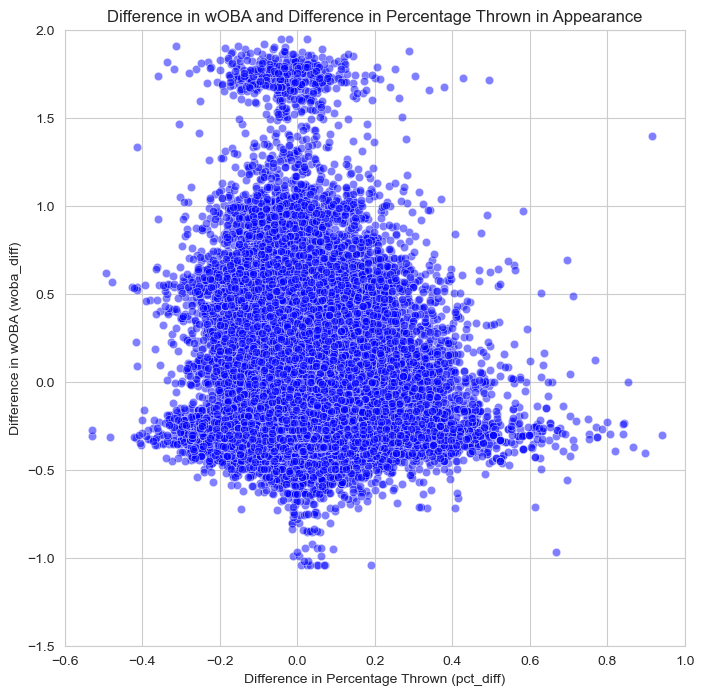

In [68]:
# set style to whitegrid to show grid on plot
sns.set_style("whitegrid");

# create the figure and the axes
# set the figure size to 8x8
f, ax = plt.subplots(figsize=(8, 8))
# create scatterplot on axes ax
# set point color to blue
# set transparency to 0.5
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=appearances, ax=ax);

# set x-axis limit from -0.6 to 1
ax.set_xlim(left=-0.6, right=1);
# set y-axis limit from -1.5 to 2
ax.set_ylim(bottom=-1.5, top=2);

# set title
plt.title("Difference in wOBA and Difference in Percentage Thrown in Appearance");
# set x-axis label 
ax.set_xlabel("Difference in Percentage Thrown (pct_diff)");
# set y-axis label
ax.set_ylabel("Difference in wOBA (woba_diff)");

This dataset contains all pitch types, and all usage ranks. We see that in the majority of appearances a pitcher threw each pitch type within 40 percent of their season percentage thrown of that pitch type, this can be seen by the much higher concentration of points between -0.4 and 0.4 on the horizontal axis. It can also be seen that pitchers threw a pitch type more than 40 percent of their season percentage thrown for the pitch type much more often than they threw a pitch type less than 40 percent of their season percentage thrown. On the graph this can be observed by the much larger number of points to the right of 0.4 on the horizontal axis compared to the number of points to the left of -0.4 on the horizontal axis. This observation can be explained by the fact that for most pitchers it would take having a particularly strong pitch type compared to the rest of the pitch types they throw for them to throw it more than 50 percent of the time. For the majority of pitchers their most-thrown pitch type will be thrown less than 50 percent of the time (and the rest of their pitch types less than the percentage thrown of their most-thrown pitch type), so it is more feasible when considering possible percentages (between 0 and 100) to throw a pitch type 40 percent more often in an appearance than their season number than 40 percent less often in an appearance. It is also likely for this reason that the observed bounds of difference in percentage thrown are approximately -0.6 and 1, which compared to the theoretical bounds of -1 and 1 is an asymmetrical subset about the theoretical bounds' center of zero.

In the majority of appearances a pitcher's pitch type had a wOBA within the range of 0.5 less than their season wOBA of the pitch type and 1 more than their season wOBA of the pitch type. There are two particular regions along the vertical axis that I would like to highlight. The first is what appears to be the horizontal "band" of points between -0.5 and 0 on the vertical axis. This band of points with changing percentage thrown and wOBA of the pitch type less than their season wOBA (representing a better wOBA in the appearance than for the season) would likely represent pitch types that didn't allow a wOBA event (a hit, walk or hit by pitch) in their appearance. This would occur as the typical wOBA of a pitch type is between 0.25 and 0.45, and a 0 wOBA in an apperance (no wOBA events allowed) would correspond to a difference in wOBA of zero minus their season wOBA, or negative season wOBA. The second region that I would like to highlight is the cluster of points between 1.5 and 2 on the vertical axis. The 2022 weight of a home run in the formula for wOBA was 2.072, so if a pitcher allowed a home run against a pitch type and didn't end another plate appearance on that pitch type in the appearance, the difference in wOBA would be 2.072 minus their season wOBA which is typically 2.072 minus a number between 0.25 and 0.45. This cluster of points fits where we would expect it to be if that was the case for the pitch type in the appearance, and is a likely explanation for the cluster. 

There are is a large variation in possible values for the difference in wOBA in an appearance by a pitcher with regions of higher concentrations of points, and while they can be reasonably explained this illustrates a problem with using appearances as samples. This provides motivation for selecting a larger sample of events for each entry in the dataset, which was done by considering samples of 1150 pitches.

### One Degree Model

We will now fit a one degree polynomial without any interaction terms on this dataset. This model is as follows.

$\Delta wOBA(\Delta x) = \beta \cdot \Delta x$

In [69]:
# fit one degree model on appearances dataset with percent difference as the independent variable
# outputs_aps1 = (aps1, coef_pct_diff_aps1, rmse_aps1, r_sq_aps1, adj_r_sq_aps1)
outputs_aps1 = fit_regression_model_degree_one(appearances, 'pct_diff', 'woba_diff')

coefficient of (x_i - mu_i): -0.2777
rmse: 0.3567
r_squared: 0.0091
adj_r_squared: 0.009


We will now visualize this model on the dataset.

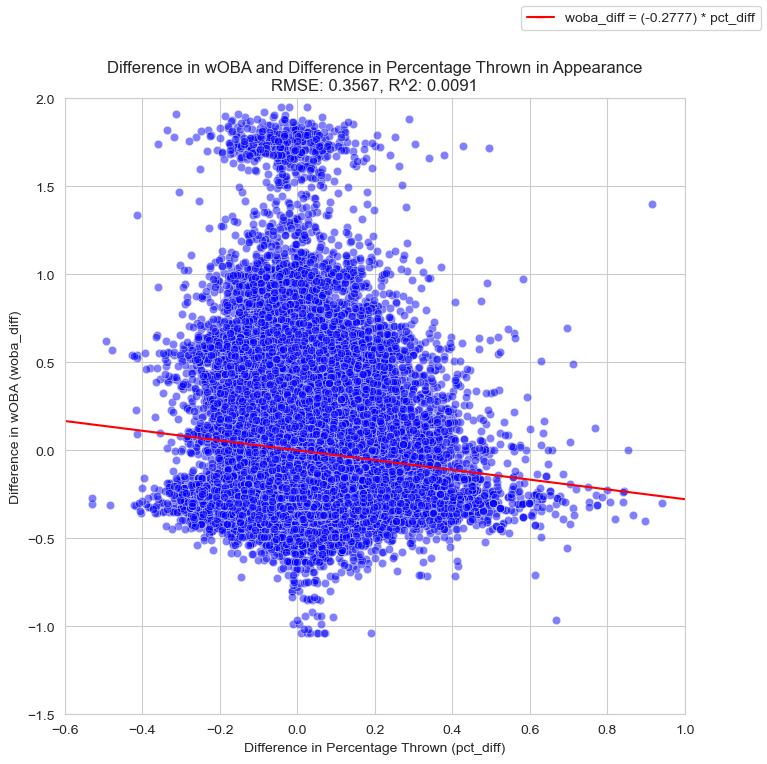

In [70]:
# set style to whitegrid to show grid on plot
sns.set_style("whitegrid");

# create the figure and the axes
# set the figure size to 8x8
f, ax = plt.subplots(figsize=(8, 8))
# plot percentage difference and wOBA difference as scatterplot
# set point color to blue
# set transparency to 0.5
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=appearances, ax=ax);

# create array of 1000 points from -1 to 1
x_values = np.linspace(-1, 1, 1000)
# apply model to array of points
y_values = outputs_aps1[1] * x_values

# plot model over scatterplot
# set line color to red
sns.lineplot(x=x_values, y=y_values, color='red', ax=ax);

# set x-axis limit from -0.6 to 1
ax.set_xlim(left=-0.6, right=1);
# set y-axis limit from -1.5 to 2
ax.set_ylim(bottom=-1.5, top=2);

# set title
# add model RMSE and model R^2 to figure title
# round to four decimal points
plt.title(f"Difference in wOBA and Difference in Percentage Thrown in Appearance\nRMSE: {round(outputs_aps1[2], 4)}, R^2: {round(outputs_aps1[3], 4)}");
# set x-axis label 
ax.set_xlabel("Difference in Percentage Thrown (pct_diff)");
# set y-axis label
ax.set_ylabel("Difference in wOBA (woba_diff)");

# store model function as label for legend
# round coefficients to four decimal points
legend_label = f"woba_diff = ({round(outputs_aps1[1], 4)}) * pct_diff"
# add legend to figure
# set label to model function
# set legend location to be top right
f.legend(handles=[Line2D([], [], marker='_', color='red', label=legend_label)], loc=1);

### Three Degree Model

We will now fit a three degree polynomial without any interaction terms on this dataset. This model is as follows.

$\Delta wOBA (\Delta x) = \beta_{3} \cdot (\Delta x)^{3} + \beta_{2} \cdot (\Delta x)^{2} + \beta_{1} \cdot \Delta x$

In [71]:
# fit three degree model on appearances dataset with percent difference as the independent variable
# outputs_aps3 = (aps3, coef_pct_diff_3_aps3, coef_pct_diff_2_aps3, coef_pct_diff_1_aps3, 
#                 rmse_aps3, r_sq_aps3, adj_r_sq_aps3)
outputs_aps3 = fit_regression_model_degree_three(appearances, 'pct_diff', 'woba_diff')

coefficient of (x_i - mu_i)^3: 0.3183
coefficient of (x_i - mu_i)^2: -0.1256
coefficient of (x_i - mu_i): -0.2857
rmse: 0.3567
r_squared: 0.0092
adj_r_squared: 0.0091


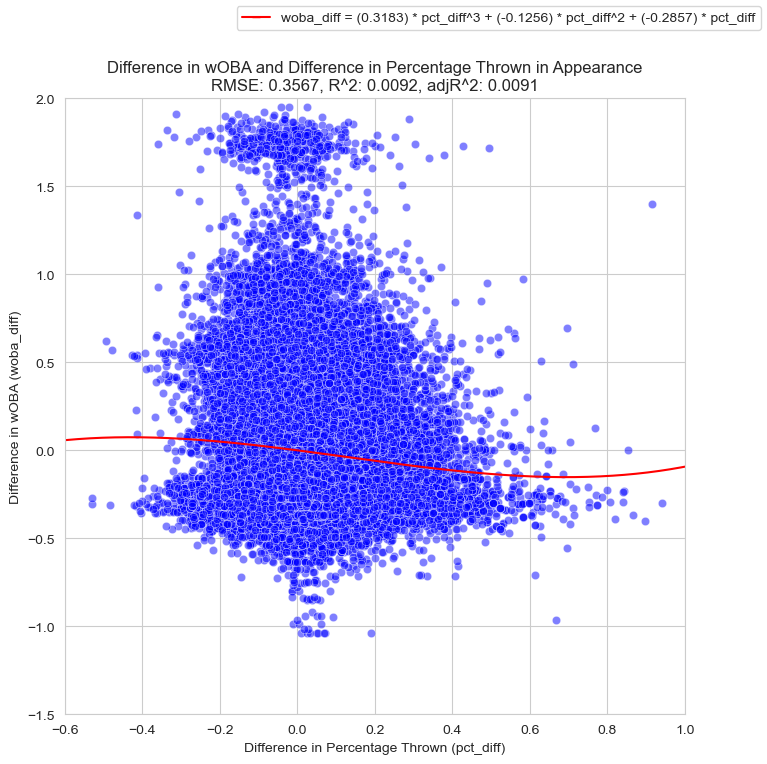

In [72]:
# set style to whitegrid to show grid on plot
sns.set_style("whitegrid");

# create the figure and the axes
# set the figure size to 8x8
f, ax = plt.subplots(figsize=(8, 8))
# plot percentage difference and wOBA difference as scatterplot
# set point color to blue
# set transparency to 0.5
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=appearances, ax=ax);

# create array of 1000 points from -1 to 1
x_values = np.linspace(-1, 1, 1000)
# apply model to array of points
y_values = outputs_aps3[1] * np.power(x_values, 3) + outputs_aps3[2] * np.power(x_values, 2) + outputs_aps3[3] * x_values

# plot model over scatterplot
# set line color to red
sns.lineplot(x=x_values, y=y_values, color='red', ax=ax);

# set x-axis limit from -0.6 to 1
ax.set_xlim(left=-0.6, right=1);
# set y-axis limit from -1.5 to 2
ax.set_ylim(bottom=-1.5, top=2);

# set title
# add model RMSE, model R^2 and model adjR^2 to figure title
# round to four decimal points
plt.title(f"Difference in wOBA and Difference in Percentage Thrown in Appearance\nRMSE: {round(outputs_aps3[4], 4)}, R^2: {round(outputs_aps3[5], 4)}, adjR^2: {round(outputs_aps3[6], 4)}");
# set x-axis label 
ax.set_xlabel("Difference in Percentage Thrown (pct_diff)");
# set y-axis label
ax.set_ylabel("Difference in wOBA (woba_diff)");

# store model function as label for legend
# round coefficients to four decimal points
legend_label = f"woba_diff = ({round(outputs_aps3[1], 4)}) * pct_diff^3 + ({round(outputs_aps3[2], 4)}) * pct_diff^2 + ({round(outputs_aps3[3], 4)}) * pct_diff"
# add legend to figure
# set label to model function
# set legend location to be top right
f.legend(handles=[Line2D([], [], marker='_', color='red', label=legend_label)], loc=1);

### Outliers

We will now visualize the outlier appearances that were identified in Section 4, and see if their removal produces a better model fit. These are appearances where a pitcher threw an unusually high or unusually low number of pitches relative to all of their pitch counts, measured by a pitch count in an appearance 1.5 times their interquartile range (difference between their 75th percentile and 25th percentile pitch counts) more (less) than their 75th (25th) percentile pitch count.

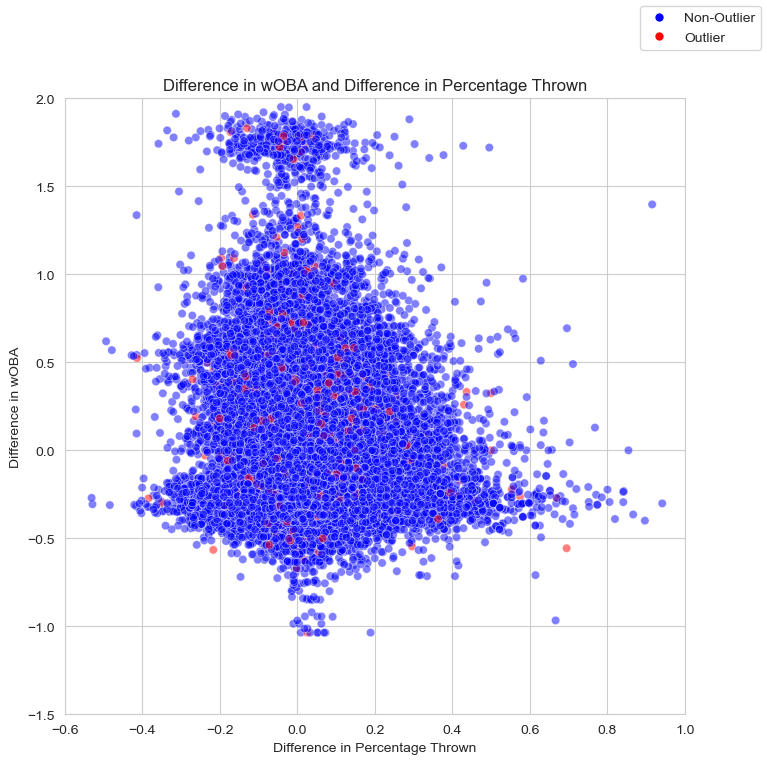

In [73]:
# create mapping to color outliers red, non-outliers blue
colors = {0: 'blue', 1: 'red'}

# set style to whitegrid to show grid on plot
sns.set_style("whitegrid");

# create the figure and the axes
# set the figure size to 8x8
f, ax = plt.subplots(figsize=(8, 8))
# plot percentage difference and wOBA difference as scatterplot
# set point color based on outlier
# use mapping to set color values
# set transparency to 0.5
# set legend=false to manually create legend below
sns.scatterplot(x='pct_diff', y='woba_diff', hue='outlier', alpha=0.5, palette=colors, legend=False, data=appearances, ax=ax);

# set x-axis limit from -0.6 to 1
ax.set_xlim(left=-0.6, right=1);
# set y-axis limit from -1.5 to 2
ax.set_ylim(bottom=-1.5, top=2);

# set title
plt.title("Difference in wOBA and Difference in Percentage Thrown");
# set x-axis label
ax.set_xlabel("Difference in Percentage Thrown");
# set y-axis label
ax.set_ylabel("Difference in wOBA");

# add legend to figure
# set legend location to be top right
f.legend(handles=[Line2D([], [], marker="o", color='white', label="Non-Outlier", markerfacecolor='blue', markersize=7), 
         Line2D([], [], marker="o", color='white', label="Outlier", markerfacecolor='red', markersize=7)], loc=1);

There doesn't appear to be any noticeable pattern in the distribution of the independent and dependent variables explained by outlier appearances. The outlier points are not concentrated in any particular areas of the entire dataset, and all areas of the entire dataset appear to have proportion of outlier and non-outlier points equal to the proportion of the points across the dataset.

#### One Degree Model

The same one degree model as above will be fit on the dataset with outlier points removed. To distinguish this model, it will be named _nos_ (for no outliers simple). This model is as follows.

$\Delta wOBA(\Delta x) = \beta \cdot \Delta x$

In [74]:
# fit one degree model on appearances dataset with outliers removed with percent difference as the independent variable
# outputs_nos1 = (nos1, coef_pct_diff_nos1, rmse_nos1, r_sq_nos1, adj_r_sq_nos1)
outputs_nos1 = fit_regression_model_degree_one(appearances[appearances['outlier'] == 0], 'pct_diff', 'woba_diff')

coefficient of (x_i - mu_i): -0.2787
rmse: 0.3569
r_squared: 0.0091
adj_r_squared: 0.0091


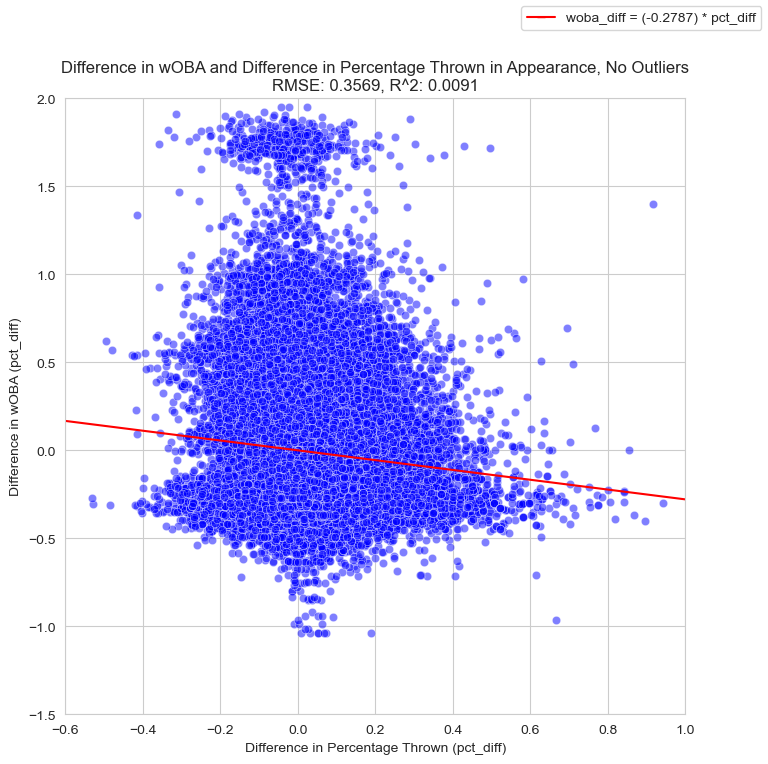

In [75]:
# set style to whitegrid to show grid on plot
sns.set_style("whitegrid");

# create the figure and the axes
# set the figure size to 8x8
f, ax = plt.subplots(figsize=(8, 8))
# plot percentage difference and wOBA difference as scatterplot
# filter plotted dataset to remove outliers
# set point color to blue
# set transparency to 0.5
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=appearances[appearances['outlier'] == 0], ax=ax);

# create array of 1000 points from -1 to 1
x_values = np.linspace(-1, 1, 1000)
# apply model to array of points
y_values = outputs_nos1[1] * x_values

# plot model over scatterplot
# set line color to red
sns.lineplot(x=x_values, y=y_values, color='red', ax=ax);

# set x-axis limit from -0.6 to 1
ax.set_xlim(left=-0.6, right=1);
# set y-axis limit from -1.5 to 2
ax.set_ylim(bottom=-1.5, top=2);

# set title
# add model RMSE and model R^2 to figure title
# round to four decimal points
plt.title(f"Difference in wOBA and Difference in Percentage Thrown in Appearance, No Outliers\nRMSE: {round(outputs_nos1[2], 4)}, R^2: {round(outputs_nos1[3], 4)}");
# set x-axis label
ax.set_xlabel("Difference in Percentage Thrown (pct_diff)");
# set first (left) y-axis label
ax.set_ylabel("Difference in wOBA (pct_diff)");

# store model function as label for legend
# round coefficients to four decimal points
legend_label = f"woba_diff = ({round(outputs_nos1[1], 4)}) * pct_diff"
# add legend to figure
# set label to model function
# set legend location to be top right
f.legend(handles=[Line2D([], [], marker='_', color='red', label=legend_label)], loc=1);

Removing the outliers didn't change the $R^2$ value (to four decimals), and the RMSE was actually higher (by 0.0002) for the model not fit on outliers.

#### Three Degree Model

A three degree polynomial like the one above will also be fit on the dataset without outliers. This model is as follows.

$\Delta wOBA (\Delta x) = \beta_{3} \cdot (\Delta x)^{3} + \beta_{2} \cdot (\Delta x)^{2} + \beta_{1} \cdot \Delta x$

In [76]:
# fit three degree model on appearances dataset with outliers removed with percent difference as the independent variable
# outputs_nos3 = (nos3, coef_pct_diff_3_nos3, coef_pct_diff_2_nos3, coef_pct_diff_1_nos3, 
#                 rmse_nos3, r_sq_nos3, adj_r_sq_nos3)
outputs_nos3 = fit_regression_model_degree_three(appearances[appearances['outlier'] == 0], 'pct_diff', 'woba_diff')

coefficient of (x_i - mu_i)^3: 0.3976
coefficient of (x_i - mu_i)^2: -0.1693
coefficient of (x_i - mu_i): -0.2866
rmse: 0.3568
r_squared: 0.0093
adj_r_squared: 0.0092


Compared to the model with the outlier points this model had a slightly higher RMSE (by 0.0001), and $R^2$ and $R_{adj}^2$ both 0.0001 higher.

Since the outlier pitch counts didn't show a pattern that indicated they were different than the entire sample of points in either the dependent or independent variables, and their exclusion didn't provide any more than a very slight change to the model results, only the entire dataset (outlier and non-outlier points) will be considered from this point on.

### Pitch Type

#### One Degree Model

A one degree polynomial with pitch type as interaction terms will now be considered. This model is as follows.

$\Delta wOBA(\Delta x) = \beta_{1} \cdot \Delta x + \beta_{1,1} \cdot I_{CU} \cdot \Delta x + {...} + \beta_{1,9} \cdot I_{SV} \cdot \Delta x$

In [77]:
# fit one degree model on appearances dataset with percent difference as the independent variable
# and pitch type interactions
# store list of independent variables in the model
columns = ['pct_diff', 'is_CU', 'is_FC', 'is_FF', 
           'is_FS', 'is_KC', 'is_SI', 'is_SL', 
           'is_ST', 'is_SV']
# outputs_appt1 = (appt1, coef_pct_diff_appt1, 
#                  coef_CU_int_appt1, coef_FC_int_appt1, coef_FF_int_appt1, coef_FS_int_appt1, 
#                  coef_KC_int_appt1, coef_SI_int_appt1, coef_SL_int_appt1, coef_ST_int_appt1, 
#                  coef_SV_int_appt1, 
#                  rmse_appt1, r_sq_appt1, adj_r_sq_appt1)
outputs_appt1 = fit_regression_model_degree_one(appearances, columns, 'woba_diff')

coefficient of (x_i - mu_i): -0.3923
coefficient of (x_i - mu_i) * I_CU: 0.0035
coefficient of (x_i - mu_i) * I_FC: 0.0865
coefficient of (x_i - mu_i) * I_FF: 0.1061
coefficient of (x_i - mu_i) * I_FS: 0.2291
coefficient of (x_i - mu_i) * I_KC: 0.0328
coefficient of (x_i - mu_i) * I_SI: 0.1334
coefficient of (x_i - mu_i) * I_SL: 0.1637
coefficient of (x_i - mu_i) * I_ST: 0.2419
coefficient of (x_i - mu_i) * I_SV: -1.1933
rmse: 0.3566
r_squared: 0.0097
adj_r_squared: 0.0095


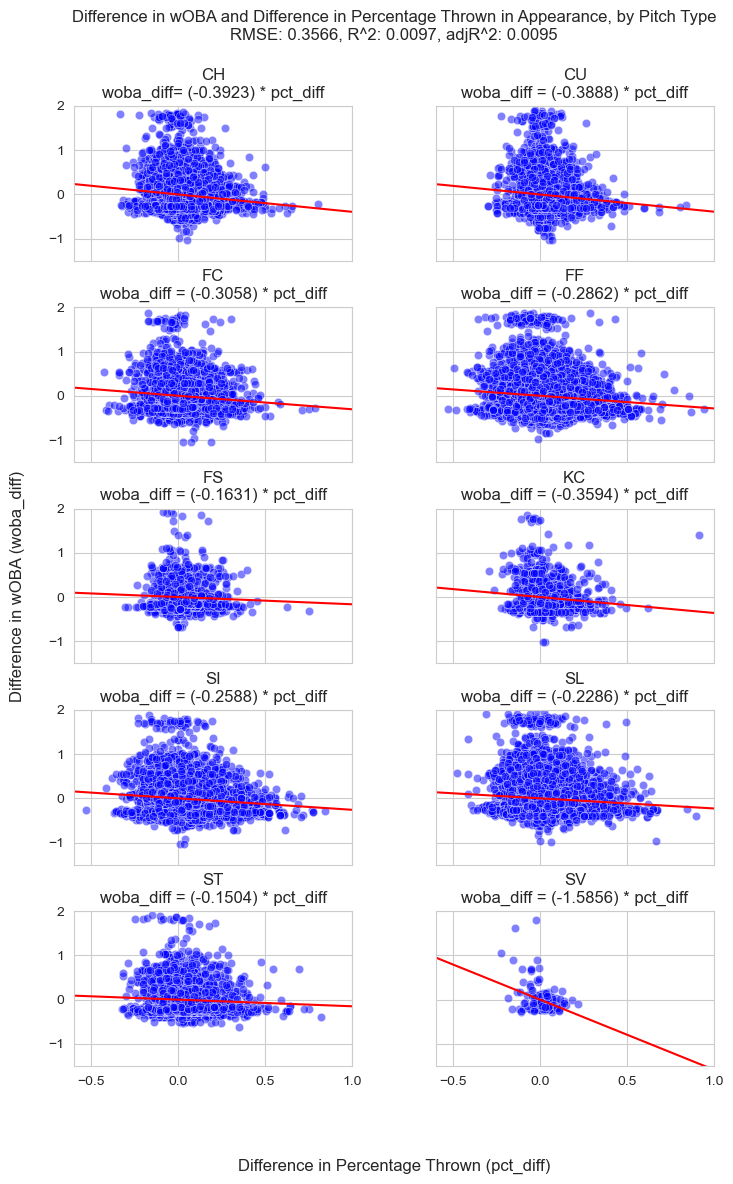

In [78]:
# set style to whitegrid to show grid on plots
sns.set_style("whitegrid");

# create the figure and the axes
# divide figure into 5x2 matrix to make separate plot for each pitch type
# set the figure size to 8x12
# set to have common x-axis and y-axis
f, ax = plt.subplots(5, 2, figsize=(8, 12), sharex=True, sharey=True)
# plot percentage difference and wOBA difference for changeups as scatterplot
# filter plotted dataset to only plot changeups
# this is all indicator variables are zero
# plot on subplot [0, 0]
# set point color to blue
# set transparency to 0.5
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=appearances[(appearances['is_CU'] == 0) & 
                                                                                       (appearances['is_FC'] == 0) & 
                                                                                       (appearances['is_FF'] == 0) & 
                                                                                       (appearances['is_FS'] == 0) & 
                                                                                       (appearances['is_KC'] == 0) &
                                                                                       (appearances['is_SI'] == 0) &
                                                                                       (appearances['is_SL'] == 0) &
                                                                                       (appearances['is_ST'] == 0) &
                                                                                       (appearances['is_SV'] == 0)], ax=ax[0, 0]);
# plot percentage difference and wOBA difference for each pitch type as scatterplot
# filter plotted dataset to only plot that pitch type
# this is the pitch type indicator is one
# plot on different subplot
# set point color to blue
# set transparency to 0.5
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=appearances[appearances['is_CU'] == 1], ax=ax[0, 1]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=appearances[appearances['is_FC'] == 1], ax=ax[1, 0]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=appearances[appearances['is_FF'] == 1], ax=ax[1, 1]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=appearances[appearances['is_FS'] == 1], ax=ax[2, 0]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=appearances[appearances['is_KC'] == 1], ax=ax[2, 1]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=appearances[appearances['is_SI'] == 1], ax=ax[3, 0]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=appearances[appearances['is_SL'] == 1], ax=ax[3, 1]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=appearances[appearances['is_ST'] == 1], ax=ax[4, 0]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=appearances[appearances['is_SV'] == 1], ax=ax[4, 1]);

# create array of 1000 points from -1 to 1
x_values = np.linspace(-1, 1, 1000)
# apply models for each pitch type to array of points
y_values_CH = outputs_appt1[1] * x_values
y_values_CU = (outputs_appt1[1] + outputs_appt1[2]) * x_values
y_values_FC = (outputs_appt1[1] + outputs_appt1[3]) * x_values
y_values_FF = (outputs_appt1[1] + outputs_appt1[4]) * x_values
y_values_FS = (outputs_appt1[1] + outputs_appt1[5]) * x_values
y_values_KC = (outputs_appt1[1] + outputs_appt1[6]) * x_values
y_values_SI = (outputs_appt1[1] + outputs_appt1[7]) * x_values
y_values_SL = (outputs_appt1[1] + outputs_appt1[8]) * x_values
y_values_ST = (outputs_appt1[1] + outputs_appt1[9]) * x_values
y_values_SV = (outputs_appt1[1] + outputs_appt1[10]) * x_values

# plot models for each pitch type over scatterplots
# set line color to red
# plot on corresponding suplots
sns.lineplot(x=x_values, y=y_values_CH, color='red', ax=ax[0, 0]);
sns.lineplot(x=x_values, y=y_values_CU, color='red', ax=ax[0, 1]);
sns.lineplot(x=x_values, y=y_values_FC, color='red', ax=ax[1, 0]);
sns.lineplot(x=x_values, y=y_values_FF, color='red', ax=ax[1, 1]);
sns.lineplot(x=x_values, y=y_values_FS, color='red', ax=ax[2, 0]);
sns.lineplot(x=x_values, y=y_values_KC, color='red', ax=ax[2, 1]);
sns.lineplot(x=x_values, y=y_values_SI, color='red', ax=ax[3, 0]);
sns.lineplot(x=x_values, y=y_values_SL, color='red', ax=ax[3, 1]);
sns.lineplot(x=x_values, y=y_values_ST, color='red', ax=ax[4, 0]);
sns.lineplot(x=x_values, y=y_values_SV, color='red', ax=ax[4, 1]);

# set subplot title
# add model for each pitch type to subplot title
ax[0, 0].set_title(f"CH\nwoba_diff= ({round(outputs_appt1[1], 4)}) * pct_diff");
ax[0, 1].set_title(f"CU\nwoba_diff = ({round((outputs_appt1[1] + outputs_appt1[2]), 4)}) * pct_diff");
ax[1, 0].set_title(f"FC\nwoba_diff = ({round((outputs_appt1[1] + outputs_appt1[3]), 4)}) * pct_diff");
ax[1, 1].set_title(f"FF\nwoba_diff = ({round((outputs_appt1[1] + outputs_appt1[4]), 4)}) * pct_diff");
ax[2, 0].set_title(f"FS\nwoba_diff = ({round((outputs_appt1[1] + outputs_appt1[5]), 4)}) * pct_diff");
ax[2, 1].set_title(f"KC\nwoba_diff = ({round((outputs_appt1[1] + outputs_appt1[6]), 4)}) * pct_diff");
ax[3, 0].set_title(f"SI\nwoba_diff = ({round((outputs_appt1[1] + outputs_appt1[7]), 4)}) * pct_diff");
ax[3, 1].set_title(f"SL\nwoba_diff = ({round((outputs_appt1[1] + outputs_appt1[8]), 4)}) * pct_diff");
ax[4, 0].set_title(f"ST\nwoba_diff = ({round((outputs_appt1[1] + outputs_appt1[9]), 4)}) * pct_diff");
ax[4, 1].set_title(f"SV\nwoba_diff = ({round((outputs_appt1[1] + outputs_appt1[10]), 4)}) * pct_diff");

# iterate over subplots
for i in range(0, 5):
    for j in range(0, 2):
        # set x-axis limit from -0.6 to 1
        ax[i, j].set_xlim(left=-0.6, right=1);
        # set y-axis limit from -1.5 to 2
        ax[i, j].set_ylim(bottom=-1.5, top=2);


# set title
# add model RMSE, model R^2 and model adjR^2 to figure title
# round to four decimal points
f.suptitle(f"Difference in wOBA and Difference in Percentage Thrown in Appearance, by Pitch Type\nRMSE: {round(outputs_appt1[11], 4)}, R^2: {round(outputs_appt1[12], 4)}, adjR^2: {round(outputs_appt1[13], 4)}");
# set x-axis label
f.supxlabel("Difference in Percentage Thrown (pct_diff)");
# set y-axis label
f.supylabel("Difference in wOBA (woba_diff)");
# iterate over subplots
for i in range(0, 5):
    for j in range(0, 2):
        # clear subplot x-axis label
        ax[i, j].set_xlabel("");
        # clear subplot y-axis label
        ax[i, j].set_ylabel("");
        
# add space between subplots
f.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.3);

#### Three Degree Model

For abbreviation of the output, the coefficiets of the interaction terms are returned in a list. This model is as follows.

$\Delta wOBA(\Delta x) = \beta_{3} \cdot (\Delta x)^3 + \beta_{2} \cdot (\Delta x)^2 + \beta_{1} \cdot \Delta x +\\
\beta_{3,1} \cdot I_{CU} \cdot (\Delta x)^3 + \beta_{2,1} \cdot I_{CU} \cdot (\Delta x)^2 + \beta_{1,1} \cdot I_{CU} \cdot \Delta x + {...} +\\ 
\beta_{3,9} \cdot I_{SV} \cdot (\Delta x)^3 + \beta_{2,9} \cdot I_{SV} \cdot (\Delta x)^2 + \beta_{1,9} \cdot I_{SV} \cdot \Delta x$

In [79]:
# fit three degree model on appearances dataset with percent difference as the independent variable
# and pitch type as interaction terms
# store list of independent variables in the model
columns = ['pct_diff', 'is_CU', 'is_FC', 'is_FF', 
           'is_FS', 'is_KC', 'is_SI', 'is_SL', 
           'is_ST', 'is_SV']
outputs_appt3 = fit_regression_model_degree_three(appearances, columns, 'woba_diff')

coefficient of (x_i - mu_i)^3: -1.0101
coefficient of (x_i - mu_i)^2: 0.8719
coefficient of (x_i - mu_i): -0.4616
coefficient of (x_i - mu_i)^3 * I_pitch_type: 
[1.062, 1.2115, 1.5907, 0.9915, 2.1197, 1.0427, 1.0989, 0.3998, -5.7666]
coefficient of (x_i - mu_i)^2 * I_pitch_type: 
[-0.9321, -0.7887, -1.2415, -0.9916, 0.4, -1.1328, -0.9002, -0.5556, 5.5009]
coefficient of (x_i - mu_i) * I_pitch_type: 
[0.0793, 0.1277, 0.1736, 0.3219, -0.2917, 0.2497, 0.2297, 0.3142, -0.982]
rmse: 0.3564
r_squared: 0.0108
adj_r_squared: 0.0103


### Usage Rank

#### All Usage Ranks

##### One Degree Model

$\Delta wOBA(\Delta x) = \beta_{1} \cdot \Delta x + \beta_{1,1} \cdot J_{second} \cdot \Delta x + {...} + \beta_{1,7} \cdot J_{eighth} \cdot \Delta x$

In [80]:
# fit one degree model on appearances dataset with percent difference as the independent variable
# and usage rank as interaction terms
# store list of independent variables in the model
columns = ['pct_diff', 'is_second', 'is_third', 'is_fourth', 
           'is_fifth', 'is_sixth', 'is_seventh', 'is_eighth']
# outputs_appu1 = (appu1, coef_pct_diff_appu1, 
#                  coef_second_int_appu1, coef_third_int_appu1, coef_fourth_int_appu1, coef_fifth_int_appu1, 
#                  coef_sixth_int_appu1, coef_seventh_int_appu1, coef_eighth_int_appu1, 
#                  rmse_appu1, r_sq_appu1, adj_r_sq_appu1)
outputs_appu1 = fit_regression_model_degree_one(appearances, columns, 'woba_diff')

coefficient of (x_i - mu_i): -0.2456
coefficient of (x_i - mu_i) * J_second: -0.0565
coefficient of (x_i - mu_i) * J_third: -0.0263
coefficient of (x_i - mu_i) * J_fourth: -0.1078
coefficient of (x_i - mu_i) * J_fifth: -0.1453
coefficient of (x_i - mu_i) * J_sixth: -0.0248
coefficient of (x_i - mu_i) * J_seventh: 0.2121
coefficient of (x_i - mu_i) * J_eighth: -0.1869
rmse: 0.3567
r_squared: 0.0092
adj_r_squared: 0.0091


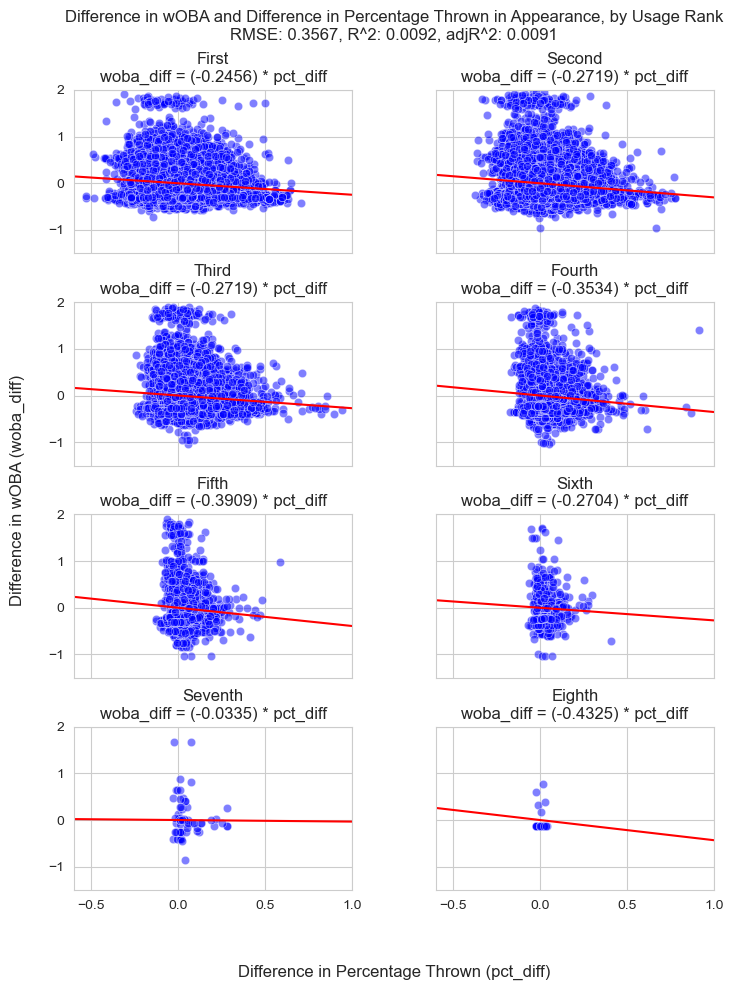

In [81]:
# set style to whitegrid to show grid on plot
sns.set_style("whitegrid");

# create the figure and the axes
# divide figure into 4x2 matrix to make separate plot for each usage rank
# set the figure size to 8x10
# set to have common x-axis and y-axis
f, ax = plt.subplots(4, 2, figsize=(8, 10), sharex=True, sharey=True)
# plot percentage difference and wOBA difference for most-used pitch types as scatterplot
# filter plotted dataset to only plot most-used
# this is all indicator variables are zero
# plot on subplot [0, 0]
# set point color to blue
# set transparency to 0.5
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=appearances[(appearances['is_second'] == 0) & 
                                                                                       (appearances['is_third'] == 0) & 
                                                                                       (appearances['is_fourth'] == 0) & 
                                                                                       (appearances['is_fifth'] == 0) & 
                                                                                       (appearances['is_sixth'] == 0) &
                                                                                       (appearances['is_seventh'] == 0) &
                                                                                       (appearances['is_eighth'] == 0)], ax=ax[0, 0]);
# plot percentage difference and wOBA difference for each usage rank as scatterplot
# filter plotted dataset to only plot that usage rank
# this is the usage rank indicator is one
# plot on different subplot
# set point color to blue
# set transparency to 0.5
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=appearances[appearances['is_second'] == 1], ax=ax[0, 1]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=appearances[appearances['is_third'] == 1], ax=ax[1, 0]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=appearances[appearances['is_fourth'] == 1], ax=ax[1, 1]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=appearances[appearances['is_fifth'] == 1], ax=ax[2, 0]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=appearances[appearances['is_sixth'] == 1], ax=ax[2, 1]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=appearances[appearances['is_seventh'] == 1], ax=ax[3, 0]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=appearances[appearances['is_eighth'] == 1], ax=ax[3, 1]);

# create array of 1000 points from -1 to 1
x_values = np.linspace(-1, 1, 1000)
# apply models for each usage rank to array of points
y_values_first = outputs_appu1[1] * x_values
y_values_second = (outputs_appu1[1] + outputs_appu1[2]) * x_values
y_values_third = (outputs_appu1[1] + outputs_appu1[3]) * x_values
y_values_fourth = (outputs_appu1[1] + outputs_appu1[4]) * x_values
y_values_fifth = (outputs_appu1[1] + outputs_appu1[5]) * x_values
y_values_sixth = (outputs_appu1[1] + outputs_appu1[6]) * x_values
y_values_seventh = (outputs_appu1[1] + outputs_appu1[7]) * x_values
y_values_eighth = (outputs_appu1[1] + outputs_appu1[8]) * x_values

# plot models for each usage rank over scatterplots
# set line color to red
# plot on corresponding suplots
sns.lineplot(x=x_values, y=y_values_first, color='red', ax=ax[0, 0]);
sns.lineplot(x=x_values, y=y_values_second, color='red', ax=ax[0, 1]);
sns.lineplot(x=x_values, y=y_values_third, color='red', ax=ax[1, 0]);
sns.lineplot(x=x_values, y=y_values_fourth, color='red', ax=ax[1, 1]);
sns.lineplot(x=x_values, y=y_values_fifth, color='red', ax=ax[2, 0]);
sns.lineplot(x=x_values, y=y_values_sixth, color='red', ax=ax[2, 1]);
sns.lineplot(x=x_values, y=y_values_seventh, color='red', ax=ax[3, 0]);
sns.lineplot(x=x_values, y=y_values_eighth, color='red', ax=ax[3, 1]);

# set subplot title
# add model for each usage rank to subplot title
ax[0, 0].set_title(f"First\nwoba_diff = ({round(outputs_appu1[1], 4)}) * pct_diff");
ax[0, 1].set_title(f"Second\nwoba_diff = ({round((outputs_appu1[1] + outputs_appu1[3]), 4)}) * pct_diff");
ax[1, 0].set_title(f"Third\nwoba_diff = ({round((outputs_appu1[1] + outputs_appu1[3]), 4)}) * pct_diff");
ax[1, 1].set_title(f"Fourth\nwoba_diff = ({round((outputs_appu1[1] + outputs_appu1[4]), 4)}) * pct_diff");
ax[2, 0].set_title(f"Fifth\nwoba_diff = ({round((outputs_appu1[1] + outputs_appu1[5]), 4)}) * pct_diff");
ax[2, 1].set_title(f"Sixth\nwoba_diff = ({round((outputs_appu1[1] + outputs_appu1[6]), 4)}) * pct_diff");
ax[3, 0].set_title(f"Seventh\nwoba_diff = ({round((outputs_appu1[1] + outputs_appu1[7]), 4)}) * pct_diff");
ax[3, 1].set_title(f"Eighth\nwoba_diff = ({round((outputs_appu1[1] + outputs_appu1[8]), 4)}) * pct_diff");

# iterate over subplots
for i in range(0, 4):
    for j in range(0, 2):
        # set x-axis limit from -0.6 to 1
        ax[i, j].set_xlim(left=-0.6, right=1);
        # set y-axis limit from -1.5 to 2
        ax[i, j].set_ylim(bottom=-1.5, top=2);

# set title
# add model RMSE, model R^2 and model adjR^2 to figure title
# round to four decimal points
f.suptitle(f"Difference in wOBA and Difference in Percentage Thrown in Appearance, by Usage Rank\nRMSE: {round(outputs_appu1[9], 4)}, R^2: {round(outputs_appu1[10], 4)}, adjR^2: {round(outputs_appu1[11], 4)}");
# set x-axis label
f.supxlabel("Difference in Percentage Thrown (pct_diff)");
# set y-axis label
f.supylabel("Difference in wOBA (woba_diff)");
# iterate over subplots
for i in range(0, 4):
    for j in range(0, 2):
        # clear subplot x-axis label
        ax[i, j].set_xlabel("");
        # clear subplot y-axis label
        ax[i, j].set_ylabel("");        

# add space between subplots
f.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.3);

##### Three Degree Model

For abbreviation of the output, the coefficients of the interaction terms are each returned in a list.

$\Delta wOBA(\Delta x) = \beta_{3} \cdot (\Delta x)^3 + \beta_{2} \cdot (\Delta x)^2 + \beta_{1} \cdot \Delta x +\\
\beta_{3,1} \cdot J_{second} \cdot (\Delta x)^3 + \beta_{2,1} \cdot J_{second} \cdot (\Delta x)^2 + \beta_{1,1} \cdot J_{second} \cdot \Delta x + {...} +\\ 
\beta_{3,7} \cdot J_{eighth} \cdot (\Delta x)^3 + \beta_{2,7} \cdot J_{eighth} \cdot (\Delta x)^2 + \beta_{1,7} \cdot J_{eighth} \cdot \Delta x$

In [82]:
# fit three degree model on appearances dataset with percent difference as the independent variable
# and usage rank as interaction terms
# store list of independent variables in the model
columns = ['pct_diff', 'is_second', 'is_third', 'is_fourth', 
           'is_fifth', 'is_sixth', 'is_seventh', 'is_eighth']
outputs_appu3 = fit_regression_model_degree_three(appearances, columns, 'woba_diff')

coefficient of (x_i - mu_i)^3: 0.4722
coefficient of (x_i - mu_i)^2: -0.4608
coefficient of (x_i - mu_i): -0.2334
coefficient of (x_i - mu_i)^3 * J_use: 
[-0.9224, -1.6666, -3.6138, -4.4633, -50.1656, -37.0826, -7153.4866]
coefficient of (x_i - mu_i)^2 * J_use: 
[0.705, 1.626, 4.2282, 4.864, 21.7008, 12.7295, 83.3751]
coefficient of (x_i - mu_i) * J_use: 
[-0.0703, -0.1937, -0.6887, -0.7634, -1.635, -0.5236, 4.1734]
rmse: 0.3563
r_squared: 0.0116
adj_r_squared: 0.0112


#### Combined Usage Ranks

##### One Degree Model

$\Delta wOBA(\Delta x) = \beta_{1} \cdot \Delta x + \beta_{1,1} \cdot J_{second} \cdot \Delta x + {...} + \beta_{1,3} \cdot J_{fourth\_to\_eighth} \cdot \Delta x$

In [83]:
# fit one degree model on appearances dataset with percent difference as the independent variable
# and combined usage rank as interaction terms
# store list of independent variables in the model
columns = ['pct_diff', 'is_second', 'is_third', 'is_fourth_to_eighth']
# outputs_appuc1 = (appuc1, coef_pct_diff_appuc1, 
#                   coef_second_int_appuc1, coef_third_int_appuc1, coef_fourth_to_eighth_int_appuc1, 
#                   rmse_appuc1, r_sq_appuc1, adj_r_sq_appuc1)
outputs_appuc1 = fit_regression_model_degree_one(appearances, columns, 'woba_diff')

coefficient of (x_i - mu_i): -0.2456
coefficient of (x_i - mu_i) * J_second: -0.0565
coefficient of (x_i - mu_i) * J_third: -0.0263
coefficient of (x_i - mu_i) * J_fourth_to_eighth: -0.1101
rmse: 0.3567
r_squared: 0.0092
adj_r_squared: 0.0091


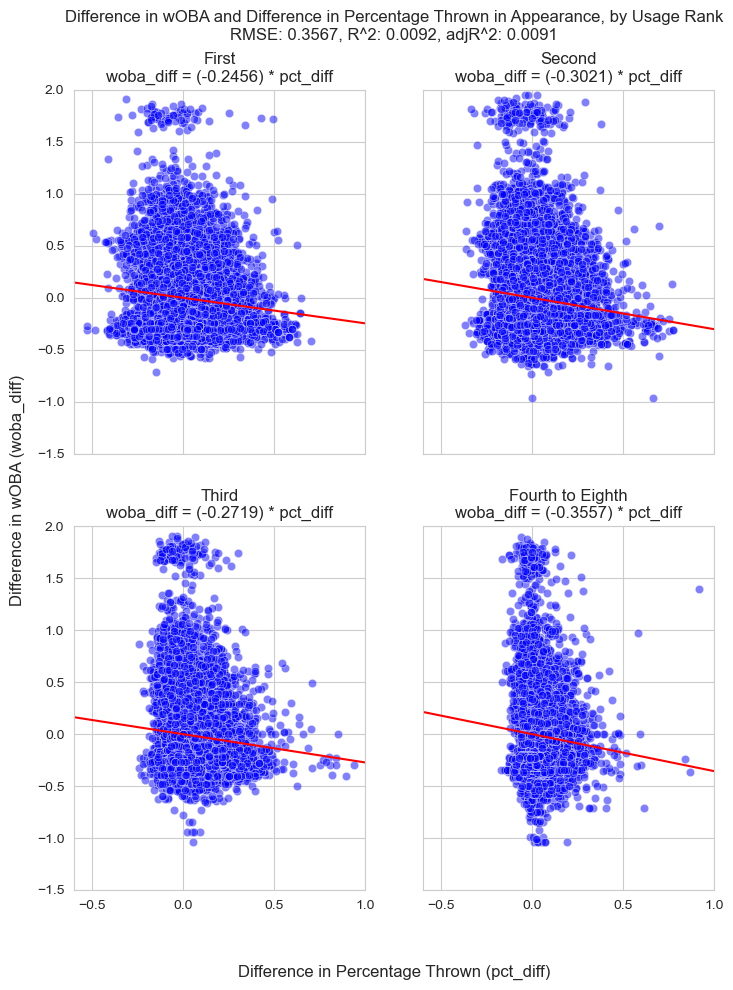

In [84]:
# set style to whitegrid to show grid on plot
sns.set_style("whitegrid");

# create the figure and the axes
# divide figure into 2x2 matrix to make separate plot for each usage rank
# set the figure size to 8x10
# set to have common x-axis and y-axis
f, ax = plt.subplots(2, 2, figsize=(8, 10), sharex=True, sharey=True)
# plot percentage difference and wOBA difference for most-used pitch types as scatterplot
# filter plotted dataset to only plot most-used
# this is all indicator variables are zero
# plot on subplot [0, 0]
# set point color to blue
# set transparency to 0.5
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=appearances[(appearances['is_second'] == 0) & 
                                                                                       (appearances['is_third'] == 0) & 
                                                                                       (appearances['is_fourth_to_eighth'] == 0)], ax=ax[0, 0]);
# plot percentage difference and wOBA difference for each usage rank as scatterplot
# filter plotted dataset to only plot that usage rank
# this is the usage rank indicator is one
# plot on different subplot
# set point color to blue
# set transparency to 0.5
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=appearances[appearances['is_second'] == 1], ax=ax[0, 1]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=appearances[appearances['is_third'] == 1], ax=ax[1, 0]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=appearances[appearances['is_fourth_to_eighth'] == 1], ax=ax[1, 1]);

# create array of 1000 points from -1 to 1
x_values = np.linspace(-1, 1, 1000)
# apply models for each usage rank to array of points
y_values_first = outputs_appuc1[1] * x_values
y_values_second = (outputs_appuc1[1] + outputs_appuc1[2]) * x_values
y_values_third = (outputs_appuc1[1] + outputs_appuc1[3]) * x_values
y_values_fourth_to_eighth = (outputs_appuc1[1] + outputs_appuc1[4]) * x_values

# plot models for each usage rank over scatterplots
# set line color to red
# plot on corresponding suplots
sns.lineplot(x=x_values, y=y_values_first, color='red', ax=ax[0, 0]);
sns.lineplot(x=x_values, y=y_values_second, color='red', ax=ax[0, 1]);
sns.lineplot(x=x_values, y=y_values_third, color='red', ax=ax[1, 0]);
sns.lineplot(x=x_values, y=y_values_fourth_to_eighth, color='red', ax=ax[1, 1]);

# set subplot title
# add model for each usage rank to subplot title
ax[0, 0].set_title(f"First\nwoba_diff = ({round(outputs_appuc1[1], 4)}) * pct_diff");
ax[0, 1].set_title(f"Second\nwoba_diff = ({round((outputs_appuc1[1] + outputs_appuc1[2]), 4)}) * pct_diff");
ax[1, 0].set_title(f"Third\nwoba_diff = ({round((outputs_appuc1[1] + outputs_appuc1[3]), 4)}) * pct_diff");
ax[1, 1].set_title(f"Fourth to Eighth\nwoba_diff = ({round((outputs_appuc1[1] + outputs_appuc1[4]), 4)}) * pct_diff");

# iterate over subplots
for i in range(0, 2):
    for j in range(0, 2):
        # set x-axis limit from -0.6 to 1
        ax[i, j].set_xlim(left=-0.6, right=1);
        # set y-axis limit from -1.5 to 2
        ax[i, j].set_ylim(bottom=-1.5, top=2);

# set title
# add model RMSE, model R^2 and model adjR^2 to figure title
# round to four decimal points
f.suptitle(f"Difference in wOBA and Difference in Percentage Thrown in Appearance, by Usage Rank\nRMSE: {round(outputs_appuc1[5], 4)}, R^2: {round(outputs_appuc1[6], 4)}, adjR^2: {round(outputs_appuc1[7], 4)}");
# set x-axis label
f.supxlabel("Difference in Percentage Thrown (pct_diff)");
# set y-axis label
f.supylabel("Difference in wOBA (woba_diff)");
# iterate over subplots
for i in range(0, 2):
    for j in range(0, 2):
        # clear subplot x-axis label
        ax[i, j].set_xlabel("");
        # clear sublot y-axis label
        ax[i, j].set_ylabel("");        

# add space between subplots
f.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.2);

##### Three Degree Model

$\Delta wOBA(\Delta x) = \beta_{3} \cdot (\Delta x)^3 + \beta_{2} \cdot (\Delta x)^2 + \beta_{1} \cdot \Delta x +\\
\beta_{3,1} \cdot J_{second} \cdot (\Delta x)^3 + \beta_{2,1} \cdot J_{second} \cdot (\Delta x)^2 + \beta_{1,1} \cdot J_{second} \cdot \Delta x + {...} +\\ 
\beta_{3,3} \cdot J_{fourth\_to\_eighth} \cdot (\Delta x)^3 + \beta_{2,3} \cdot J_{fourth\_to\_eighth} \cdot (\Delta x)^2 + \beta_{1,3} \cdot J_{fourth\_to\_eighth} \cdot \Delta x$

In [85]:
# fit three degree model on appearances dataset with percent difference as the independent variable
# and combined usage rank as interaction terms
# store list of independent variables in the model
columns = ['pct_diff', 'is_second', 'is_third', 'is_fourth_to_eighth']
outputs_appuc3 = fit_regression_model_degree_three(appearances, columns, 'woba_diff')

coefficient of (x_i - mu_i)^3: 0.4722
coefficient of (x_i - mu_i)^2: -0.4608
coefficient of (x_i - mu_i): -0.2334
coefficient of (x_i - mu_i)^3 * J_use: 
[-0.9224, -1.6666, -3.7617]
coefficient of (x_i - mu_i)^2 * J_use: 
[0.705, 1.626, 4.3364]
coefficient of (x_i - mu_i) * J_use: 
[-0.0703, -0.1937, -0.6928]
rmse: 0.3563
r_squared: 0.0114
adj_r_squared: 0.0112


### Pitch Type and Usage Rank

#### All Usage Ranks

##### One Degree Model

For abbreviation of the output, the coefficients of the multiple interaction terms are returned in a list.

$\Delta wOBA(\Delta x) = \beta_{1} \cdot \Delta x + \beta_{1,1,0} \cdot I_{CU} \cdot \Delta x + {...} + \beta_{1,9,0} \cdot I_{SV} \cdot \Delta x + \beta_{1,0,1} \cdot J_{second} \cdot \Delta x + {...} + \beta_{1,0,7} \cdot J_{eighth} \cdot \Delta x +\\
\beta_{1,1,1} \cdot I_{CU} \cdot J_{second} \cdot \Delta x + {...} + \beta_{1,9,7} \cdot I_{SV} \cdot J_{eighth} \cdot \Delta x$

In [86]:
# fit one degree model on appearances dataset with percent difference as the independent variable
# and pitch type and usage rank as interaction terms
# store list of independent variables in the model
columns = ['pct_diff', 'is_CU', 'is_FC', 'is_FF', 
           'is_FS', 'is_KC', 'is_SI', 'is_SL', 
           'is_ST', 'is_SV', 'is_second', 'is_third', 
           'is_fourth', 'is_fifth', 'is_sixth', 'is_seventh', 
           'is_eighth']
# outputs_apptpu1 = (apptpu1, coef_pct_diff_apptpu1, 
#                    coef_CU_int_apptpu1, coef_FC_int_apptpu1, coef_FF_int_apptpu1, coef_FS_int_apptpu1, 
#                    coef_KC_int_apptpu1, coef_SI_int_apptpu1, coef_SL_int_apptpu1, coef_ST_int_apptpu1,
#                    coef_SV_int_apptpu1,
#                    coef_second_int_apptpu1, coef_third_int_apptpu1, coef_fourth_int_apptpu1, coef_fifth_int_apptpu1,
#                    coef_sixth_int_apptpu1, coef_seventh_int_appt_pu1, coef_eighth_int_apptpu1,
#                    coefs_CU_use_int_apptpu1, coefs_FC_use_int_apptpu1, coefs_FF_use_int_apptpu1, coefs_FS_use_int_apptpu1, 
#                    coefs_KC_use_int_apptpu1, coefs_SI_use_int_apptpu1, coefs_SL_use_int_apptpu1, coefs_ST_use_int_apptpu1,
#                    coefs_SV_use_int_apptpu1,
#                    rmse_apptpu1, r_sq_apptpu1, adj_r_sq_apptpu1)
outputs_apptpu1 = fit_regression_model_degree_one(appearances, columns, 'woba_diff')

coefficient of (x_i - mu_i): -0.2448
coefficient of (x_i - mu_i) * I_CU: -0.0017
coefficient of (x_i - mu_i) * I_FC: -0.0404
coefficient of (x_i - mu_i) * I_FF: -0.0148
coefficient of (x_i - mu_i) * I_FS: -0.5858
coefficient of (x_i - mu_i) * I_KC: 0.2567
coefficient of (x_i - mu_i) * I_SI: -0.0351
coefficient of (x_i - mu_i) * I_SL: 0.0723
coefficient of (x_i - mu_i) * I_ST: 0.0751
coefficient of (x_i - mu_i) * I_SV: -2.0128
coefficient of (x_i - mu_i) * J_second: -0.2723
coefficient of (x_i - mu_i) * J_third: -0.0736
coefficient of (x_i - mu_i) * J_fourth: -0.2671
coefficient of (x_i - mu_i) * J_fifth: -0.0213
coefficient of (x_i - mu_i) * J_sixth: -0.6562
coefficient of (x_i - mu_i) * J_seventh: 1.393
coefficient of (x_i - mu_i) * J_eighth: -0.2222
coefficient of (x_i - mu_i) * I_CU * J_use: 
[0.1382, -0.0495, 0.0836, -0.7343, 0.2804, -1.7269, 0.0]
coefficient of (x_i - mu_i) * I_FC * J_use: 
[0.2456, 0.1164, 0.1115, -0.3685, 0.805, -0.9638, 0.0]
coefficient of (x_i - mu_i) * I_FF *

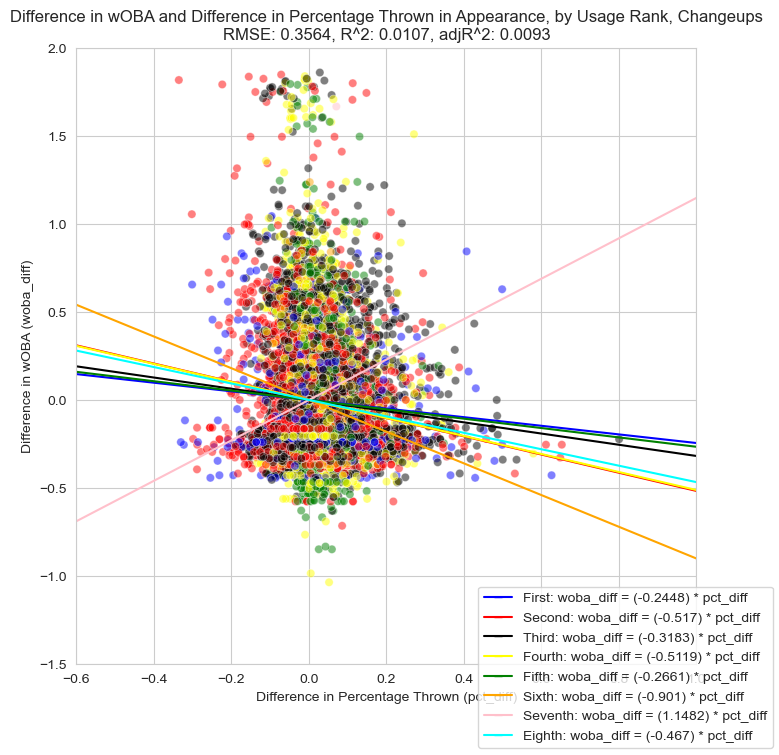

In [87]:
# create mapping to color points by usage rank
colors = {'first': 'blue', 'second': 'red', 'third': 'black', 'fourth': 'yellow', 
          'fifth': 'green', 'sixth': 'orange', 'seventh': 'pink', 'eighth': 'cyan'}

# set style to whitegrid to show grid on plot
sns.set_style("whitegrid");

# create the figure and the axes
# set the figure size to 8x8
f, ax = plt.subplots(figsize=(8, 8))
# plot percentage difference and wOBA difference for changeups as scatterplot
# filter plotted dataset to only plot changeups
# this is all indicator variables are zero
# set point color based on pitch use
# use mapping to set color values
# set transparency to 0.5
# set legend=false to manually create legend below
sns.scatterplot(x='pct_diff', y='woba_diff', hue='use', alpha=0.5, palette=colors, legend=False, data=appearances[(appearances['is_CU'] == 0) & 
                                                                                       (appearances['is_FC'] == 0) & 
                                                                                       (appearances['is_FF'] == 0) & 
                                                                                       (appearances['is_FS'] == 0) & 
                                                                                       (appearances['is_KC'] == 0) &
                                                                                       (appearances['is_SI'] == 0) &
                                                                                       (appearances['is_SL'] == 0) &
                                                                                       (appearances['is_ST'] == 0) &
                                                                                       (appearances['is_SV'] == 0)], ax=ax);

# create array of 1000 points from -1 to 1
x_values = np.linspace(-1, 1, 1000)
# apply models for each usage rank to array of points
y_values_first = outputs_apptpu1[1] * x_values
y_values_second = (outputs_apptpu1[1] + outputs_apptpu1[11]) * x_values
y_values_third = (outputs_apptpu1[1] + outputs_apptpu1[12]) * x_values
y_values_fourth = (outputs_apptpu1[1] + outputs_apptpu1[13]) * x_values
y_values_fifth = (outputs_apptpu1[1] + outputs_apptpu1[14]) * x_values
y_values_sixth = (outputs_apptpu1[1] + outputs_apptpu1[15]) * x_values
y_values_seventh = (outputs_apptpu1[1] + outputs_apptpu1[16]) * x_values
y_values_eighth = (outputs_apptpu1[1] + outputs_apptpu1[17]) * x_values

# plot models for each usage rank over scatterplot
# set line color to corresponding color in mapping
sns.lineplot(x=x_values, y=y_values_first, color='blue', ax=ax);
sns.lineplot(x=x_values, y=y_values_second, color='red', ax=ax);
sns.lineplot(x=x_values, y=y_values_third, color='black', ax=ax);
sns.lineplot(x=x_values, y=y_values_fourth, color='yellow', ax=ax);
sns.lineplot(x=x_values, y=y_values_fifth, color='green', ax=ax);
sns.lineplot(x=x_values, y=y_values_sixth, color='orange', ax=ax);
sns.lineplot(x=x_values, y=y_values_seventh, color='pink', ax=ax);
sns.lineplot(x=x_values, y=y_values_eighth, color='cyan', ax=ax);

# set x-axis limit from -0.6 to 1
ax.set_xlim(left=-0.6, right=1);
# set y-axis limit from -1.5 to 2
ax.set_ylim(bottom=-1.5, top=2);

# set title
# add model RMSE, model R^2 and model adjR^2 to figure title
# round to four decimal points
plt.title(f"Difference in wOBA and Difference in Percentage Thrown in Appearance, by Usage Rank, Changeups\nRMSE: {round(outputs_apptpu1[27], 4)}, R^2: {round(outputs_apptpu1[28], 4)}, adjR^2: {round(outputs_apptpu1[29], 4)}");
# set x-axis label
ax.set_xlabel("Difference in Percentage Thrown (pct_diff)");
# set y-axis label
ax.set_ylabel("Difference in wOBA (woba_diff)");

# store model functions as labels for legend
# round coefficients to four decimal points
legend_label_first = f"First: woba_diff = ({round(outputs_apptpu1[1], 4)}) * pct_diff"
legend_label_second = f"Second: woba_diff = ({round((outputs_apptpu1[1] + outputs_apptpu1[11]), 4)}) * pct_diff"
legend_label_third = f"Third: woba_diff = ({round((outputs_apptpu1[1] + outputs_apptpu1[12]), 4)}) * pct_diff"
legend_label_fourth = f"Fourth: woba_diff = ({round((outputs_apptpu1[1] + outputs_apptpu1[13]), 4)}) * pct_diff"
legend_label_fifth = f"Fifth: woba_diff = ({round((outputs_apptpu1[1] + outputs_apptpu1[14]), 4)}) * pct_diff"
legend_label_sixth = f"Sixth: woba_diff = ({round((outputs_apptpu1[1] + outputs_apptpu1[15]), 4)}) * pct_diff"
legend_label_seventh = f"Seventh: woba_diff = ({round((outputs_apptpu1[1] + outputs_apptpu1[16]), 4)}) * pct_diff"
legend_label_eighth = f"Eighth: woba_diff = ({round((outputs_apptpu1[1] + outputs_apptpu1[17]), 4)}) * pct_diff"
# add legend to figure
# set label to model function for each usage rank
# set legend location to be bottom right
f.legend(handles=[Line2D([], [], marker='_', color='blue', label=legend_label_first), 
                  Line2D([], [], marker='_', color='red', label=legend_label_second), 
                  Line2D([], [], marker='_', color='black', label=legend_label_third), 
                  Line2D([], [], marker='_', color='yellow', label=legend_label_fourth), 
                  Line2D([], [], marker='_', color='green', label=legend_label_fifth), 
                  Line2D([], [], marker='_', color='orange', label=legend_label_sixth), 
                  Line2D([], [], marker='_', color='pink', label=legend_label_seventh), 
                  Line2D([], [], marker='_', color='cyan', label=legend_label_eighth)], loc=4);

##### Three Degree Model

For abbreviation of the output, the coefficients of the single interaction terms are returned in a list, and the coefficients of the multiple interaction terms are returned in lists of lists.

$\Delta wOBA(\Delta x) = \beta_{3} \cdot (\Delta x)^{3} + \beta_{2} \cdot (\Delta x) ^ 2 + \beta_{1} \cdot \Delta x +\\
\beta_{3, 1, 0} \cdot I_{CU} \cdot (\Delta x)^{3} + \beta_{2, 1, 0} \cdot I_{CU} \cdot (\Delta x)^2 + \beta_{1, 1, 0} \cdot I_{CU} \cdot \Delta x + {...} +\\
\beta_{3, 9, 0} \cdot I_{SV} \cdot (\Delta x)^{3} + \beta_{2, 9, 0} \cdot I_{SV} \cdot (\Delta x)^2 + \beta_{1, 9, 0} \cdot I_{SV} \cdot \Delta x + \\
\beta_{3, 0, 1} \cdot J_{second} \cdot (\Delta x)^3 + \beta_{2, 0, 1} \cdot J_{second} \cdot (\Delta x)^2 + \beta_{1, 0, 1} \cdot J_{second} \cdot \Delta x + {...} +\\
\beta_{3, 0, 7} \cdot J_{eighth} \cdot (\Delta x)^3 + \beta_{2, 0, 7} \cdot J_{eighth} \cdot (\Delta x)^2 + \beta_{1, 0, 7} \cdot J_{eighth} \cdot \Delta x +\\
\beta_{3, 1, 1} \cdot I_{CU} \cdot J_{second} \cdot (\Delta x)^3 + \beta_{2, 1, 1} \cdot I_{CU} \cdot J_{second} \cdot (\Delta x)^2 + \beta_{1, 1, 1} \cdot I_{CU} \cdot J_{second} \cdot \Delta x + {...} +\\
\beta_{3, 9, 7} \cdot I_{SV} \cdot J_{eighth} \cdot (\Delta x)^3 + \beta_{2, 9, 7} \cdot I_{SV} \cdot J_{eighth} \cdot (\Delta x)^2 + \beta_{1, 9, 7} \cdot I_{SV} \cdot J_{eighth} \cdot \Delta x$

In [88]:
# fit three degree model on appearances dataset with percent difference as the independent variable
# and pitch type and usage rank as interaction terms
# store list of independent variables in the model
columns = ['pct_diff', 'is_CU', 'is_FC', 'is_FF', 
           'is_FS', 'is_KC', 'is_SI', 'is_SL', 
           'is_ST', 'is_SV', 'is_second', 'is_third', 
           'is_fourth', 'is_fifth', 'is_sixth', 'is_seventh', 
           'is_eighth']
outputs_apptpu3 = fit_regression_model_degree_three(appearances, columns, 'woba_diff')

coefficient of (x_i - mu_i)^3: 1.182
coefficient of (x_i - mu_i)^2: -0.4206
coefficient of (x_i - mu_i): -0.2902
coefficient of (x_i - mu_i)^3 * I_pitch_type: 
[-0.8868, -0.3044, -0.5298, -1.2551, -1.6613, -0.862, -0.7956, -2.0861, 103.0547]
coefficient of (x_i - mu_i)^2 * I_pitch_type: 
[-0.6807, -0.1441, -0.1556, 3.1478, 1.5585, -0.143, 0.2203, 0.6532, 2.683]
coefficient of (x_i - mu_i) * I_pitch_type: 
[0.2078, -0.0224, 0.0342, -0.3326, 0.1708, 0.0577, 0.1094, 0.1802, -1.6244]
coefficient of (x_i - mu_i)^3 * J_use: 
[103.0547, -2.8322, -2.0069, -9.6127, -48.5272, 7.2219, -3846.2094]
coefficient of (x_i - mu_i)^2 * J_use: 
[2.683, 1.4815, 1.0417, 6.1882, 20.0077, -8.5294, 463.5035]
coefficient of (x_i - mu_i) * J_use: 
[-1.6244, -0.2322, -0.0921, -0.762, -1.254, -0.0473, -2.0206]
coefficient of (x_i - mu_i)^3 * I_pitch_type * J_use: 
[[-0.0, 2.8144, -0.8301, 4.6212, 58.8801, -133.6227, 15013.6089], [0.0, 1.4828, -1.3122, -8.7207, -46.7442, 25.4276, 4159.6913], [0.0, 1.6579, 1.0904, 4

#### Combined Usage Ranks

##### One Degree Model

$\Delta wOBA(\Delta x) = \beta_{1} \cdot \Delta x + \beta_{1,1,0} \cdot I_{CU} \cdot \Delta x + {...} + \beta_{1,9,0} \cdot I_{SV} \cdot \Delta x + \beta_{1,0,1} \cdot J_{second} \cdot \Delta x + {...} + \beta_{1,0,3} \cdot J_{fourth\_to\_eighth} \cdot \Delta x +\\
\beta_{1,1,1} \cdot I_{CU} \cdot J_{second} \cdot \Delta x + {...} + \beta_{1,9,3} \cdot I_{SV} \cdot J_{fourth\_to\_eighth} \cdot \Delta x$

In [89]:
# fit one degree model on appearances dataset with percent difference as the independent variable
# and pitch type and combined usage rank as interaction terms
# store list of independent variables in the model
columns = ['pct_diff', 'is_CU', 'is_FC', 'is_FF', 
           'is_FS', 'is_KC', 'is_SI', 'is_SL', 
           'is_ST', 'is_SV', 'is_second', 'is_third', 
           'is_fourth_to_eighth']
# outputs_apptpuc1 = (apptpuc1, coef_pct_diff_apptpuc1, 
#                    coef_CU_int_apptpuc1, coef_FC_int_apptpuc1, coef_FF_int_apptpuc1, coef_FS_int_apptpuc1, 
#                    coef_KC_int_apptpuc1, coef_SI_int_apptpuc1, coef_SL_int_apptpuc1, coef_ST_int_apptpuc1,
#                    coef_SV_int_apptpuc1,
#                    coef_second_int_apptpuc1, coef_third_int_apptpuc1, coef_fourth_int_apptpuc1, coef_fifth_int_apptpuc1,
#                    coef_sixth_int_apptpuc1, coef_seventh_int_appt_puc1, coef_eighth_int_apptpuc1,
#                    coefs_CU_use_int_apptpuc1, coefs_FC_use_int_apptpuc1, coefs_FF_use_int_apptpuc1, coefs_FS_use_int_apptpuc1, 
#                    coefs_KC_use_int_apptpuc1, coefs_SI_use_int_apptpuc1, coefs_SL_use_int_apptpuc1, coefs_ST_use_int_apptpuc1,
#                    coefs_SV_use_int_apptpuc1,
#                    rmse_apptpuc1, r_sq_apptpuc1, adj_r_sq_apptpuc1)
outputs_apptpuc1 = fit_regression_model_degree_one(appearances, columns, 'woba_diff')

coefficient of (x_i - mu_i): -0.2448
coefficient of (x_i - mu_i) * I_CU: -0.0017
coefficient of (x_i - mu_i) * I_FC: -0.0404
coefficient of (x_i - mu_i) * I_FF: -0.0148
coefficient of (x_i - mu_i) * I_FS: -0.5858
coefficient of (x_i - mu_i) * I_KC: 0.2567
coefficient of (x_i - mu_i) * I_SI: -0.0351
coefficient of (x_i - mu_i) * I_SL: 0.0723
coefficient of (x_i - mu_i) * I_ST: 0.0751
coefficient of (x_i - mu_i) * I_SV: -2.0128
coefficient of (x_i - mu_i) * J_second: -0.2723
coefficient of (x_i - mu_i) * J_third: -0.0736
coefficient of (x_i - mu_i) * J_fourth_to_eighth: -0.2141
coefficient of (x_i - mu_i) * I_CU * J_use: 
[0.1382, -0.0495, -0.0973]
coefficient of (x_i - mu_i) * I_FC * J_use: 
[0.2456, 0.1164, 0.0329]
coefficient of (x_i - mu_i) * I_FF * J_use: 
[0.1374, 0.125, 0.1553]
coefficient of (x_i - mu_i) * I_FS * J_use: 
[1.0105, 0.6495, 0.7512]
coefficient of (x_i - mu_i) * I_KC * J_use: 
[-0.1062, -0.7663, 0.1013]
coefficient of (x_i - mu_i) * I_SI * J_use: 
[0.2364, 0.2103, 0.

##### Three Degree Model

$\Delta wOBA(\Delta x) = \beta_{3} \cdot (\Delta x)^{3} + \beta_{2} \cdot (\Delta x) ^ 2 + \beta_{1} \cdot \Delta x +\\
\beta_{3, 1, 0} \cdot I_{CU} \cdot (\Delta x)^{3} + \beta_{2, 1, 0} \cdot I_{CU} \cdot (\Delta x)^2 + \beta_{1, 1, 0} \cdot I_{CU} \cdot \Delta x + {...} +\\
\beta_{3, 9, 0} \cdot I_{SV} \cdot (\Delta x)^{3} + \beta_{2, 9, 0} \cdot I_{SV} \cdot (\Delta x)^2 + \beta_{1, 9, 0} \cdot I_{SV} \cdot \Delta x + \\
\beta_{3, 0, 1} \cdot J_{second} \cdot (\Delta x)^3 + \beta_{2, 0, 1} \cdot J_{second} \cdot (\Delta x)^2 + \beta_{1, 0, 1} \cdot J_{second} \cdot \Delta x + {...} +\\
\beta_{3, 0, 3} \cdot J_{fourth\_to\_eighth} \cdot (\Delta x)^3 + \beta_{2, 0, 3} \cdot J_{fourth\_to\_eighth} \cdot (\Delta x)^2 + \beta_{1, 0, 3} \cdot J_{fourth\_to\_eighth} \cdot \Delta x +\\
\beta_{3, 1, 1} \cdot I_{CU} \cdot J_{second} \cdot (\Delta x)^3 + \beta_{2, 1, 1} \cdot I_{CU} \cdot J_{second} \cdot (\Delta x)^2 + \beta_{1, 1, 1} \cdot I_{CU} \cdot J_{second} \cdot \Delta x + {...} +\\
\beta_{3, 9, 3} \cdot I_{SV} \cdot J_{fourth\_to\_eighth} \cdot (\Delta x)^3 + \beta_{2, 9, 3} \cdot I_{SV} \cdot J_{fourth\_to\_eighth} \cdot (\Delta x)^2 + \beta_{1, 9, 3} \cdot I_{SV} \cdot J_{fourth\_to\_eighth} \cdot \Delta x$

In [90]:
# fit three degree model on appearances dataset with percent difference as the independent variable
# and pitch type and combined usage rank as interaction terms
# store list of independent variables in the model
columns = ['pct_diff', 'is_CU', 'is_FC', 'is_FF', 
           'is_FS', 'is_KC', 'is_SI', 'is_SL', 
           'is_ST', 'is_SV', 'is_second', 'is_third', 
           'is_fourth_to_eighth']
outputs_apptpuc3 = fit_regression_model_degree_three(appearances, columns, 'woba_diff')

coefficient of (x_i - mu_i)^3: 0.6277
coefficient of (x_i - mu_i)^2: 0.4153
coefficient of (x_i - mu_i): -0.4707
coefficient of (x_i - mu_i)^3 * I_pitch_type: 
[0.3157, 1.9272, 0.0899, -3.4999, -0.0746, -0.617, -0.1099, -1.6482, 31.261]
coefficient of (x_i - mu_i)^2 * I_pitch_type: 
[-1.1057, -0.6196, -0.9466, 0.6937, 1.6291, -0.8895, -0.5863, -0.1238, 0.9591]
coefficient of (x_i - mu_i) * I_pitch_type: 
[0.0974, 0.0051, 0.2064, 0.0835, -0.2921, 0.2622, 0.261, 0.3741, -0.8081]
coefficient of (x_i - mu_i)^3 * J_use: 
[31.261, -2.2779, -1.4526]
coefficient of (x_i - mu_i)^2 * J_use: 
[0.9591, 0.6456, 0.2059]
coefficient of (x_i - mu_i) * J_use: 
[-0.8081, -0.0517, 0.0884]
coefficient of (x_i - mu_i)^3 * I_pitch_type * J_use: 
[[0.0, 1.6118, -2.0327], [0.0, -0.7488, -3.5438], [0.0, 1.0382, 0.4706], [0.0, 5.1022, 8.983], [0.0, -0.3589, -3.2298], [0.0, 1.6229, 1.42], [0.0, 1.6667, -2.0102], [0.0, 3.0666, 1.085], [31.261, -121.2132, 0.0]]
coefficient of (x_i - mu_i)^2 * I_pitch_type * J_use:

## Samples

Next, to begin modeling differences in wOBA as a function of difference in percetage thrown in samples of 1150 pitches by a pitcher, I will again visualize the dataset.

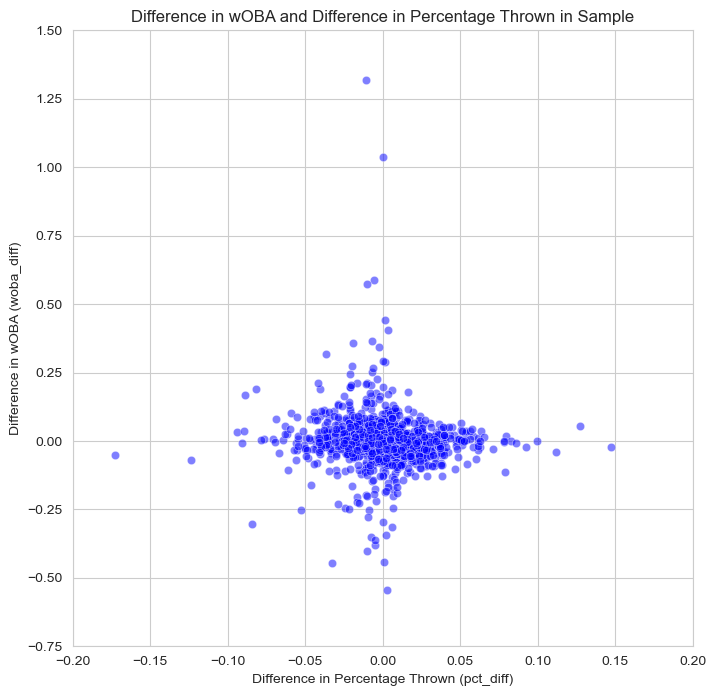

In [91]:
# set style to whitegrid to show grid on plot
sns.set_style("whitegrid");

# create the figure and the axes
# set the figure size to 8x8
f, ax = plt.subplots(figsize=(8, 8))
# plot percentage difference and wOBA difference as scatterplot
# set point color to blue
# set transperancy to 0.5
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=samples, ax=ax);

# set x-axis limit from -0.2 to 0.2
ax.set_xlim(left=-0.2, right=0.2);
# set y-axis limit from -0.75 to 1.5
ax.set_ylim(bottom=-0.75, top=1.5);

# set title
plt.title("Difference in wOBA and Difference in Percentage Thrown in Sample");
# set x-axis label
ax.set_xlabel("Difference in Percentage Thrown (pct_diff)");
# set y-axis label
ax.set_ylabel("Difference in wOBA (woba_diff)");

We see that this dataset greatly reduces the variation of both the dependent and independent variables. Along the horizontal axis the points are concentrated in the region within five percent of their season percent thrown of the pitch type. This can be observed by seeing the high concentration of points between -0.05 and 0.05 on the horizontal axis. Extending these bounds, the points are very heavily concentrated in the region within ten percent of their season percent thrown (only five points are outside this range). If we compare this with the bounds of the concentration of points in appearances being the sample size (which were plus/minus 40 percent of their season percent thrown) then we clearly see an effect of using samples of 1150 pitches. By taking a larger number of pitches within each sample the variance of difference in percentage thrown within the dataset has been reduced to where all but five points are within a region four times smaller than the dataset using appearances. 

There is a similar result with points along the vertical axis (the difference in wOBA of the pitch type). Here, the points are concentrated within 0.25 of the pitcher's season wOBA of the pitch type (this can be viewed by the high concentration of points within -0.25 and 0.25 on the vertical axis), and by extending these bounds to within 0.5 of the pitch type's season wOBA this is an even higher concentration within the region and very few points are outside of these bounds (coincidentally this number of points is also five). Comparing to the dataset using appearances where the region of highest concentration of points was between -0.5 and 1 on the vertical axis, the bounds containing the majority of points has been reduced to two-thirds the size, and all but five points are within this smaller range.

Another interesting observation of this dataset compared to the appearances dataset is that increasing the number of pitches in each observation has removed the assymmetry about zero on both axes. In the dataset with appearances the bounds of observed points were skewed positively as there are more "possible values" to either increase percentage thrown compared to decreasing percentage thrown or to have a higher wOBA compared to having a lower wOBA. Having more positive "possible values" than negative are quirks of percentage thrown and wOBA rather than directly having to do with a larger sample size within each observation, so in theory they could hold for this dataset using 1150-pitch samples. For that reason I believe that it is notable that, with the exception of one point less than -0.15 on the horizontal axis and two points greater than 0.75 on the vertical axis, by increasing pitches in a sample all observations in the dataset can fit within square bounds symmetric about zero in length on both axes.

While the variance of difference in wOBA (the dependent variable) in this dataset being smaller will likely be helpful for improving the fit of models, the tradeoff of also having smaller variance of difference in percent thrown (the independent variable) may pose a problem for the models. In particular this may pose a problem with extrapolating model results (applying the model results in regions outside of observed values) which is an important application of the regression models in this project.

### One Degree Model

$\Delta wOBA(\Delta x) = \beta \cdot \Delta x$

In [92]:
# fit one degree model on samples dataset with percent difference as the independent variable
# outputs_sps1 = (sps1, coef_pct_diff_sps1, rmse_sps1, r_sq_sps1, adj_r_sq_sps1)
outputs_sps1 = fit_regression_model_degree_one(samples, 'pct_diff', 'woba_diff')

coefficient of (x_i - mu_i): -0.2634
rmse: 0.0929
r_squared: 0.0049
adj_r_squared: 0.0041


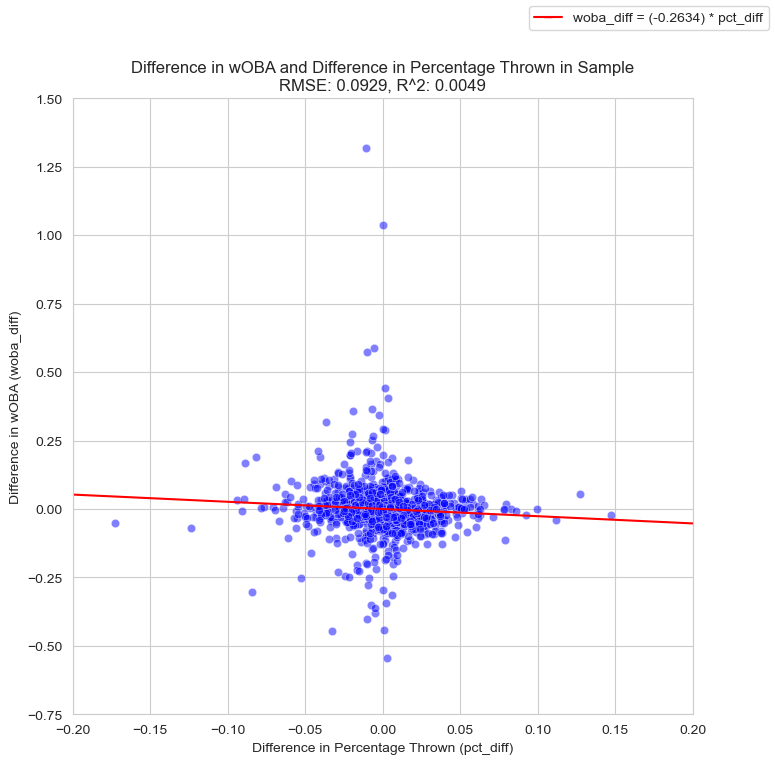

In [93]:
# set style to whitegrid to show grid on plot
sns.set_style("whitegrid");

# create the figure and the axes
# set the figure size to 8x8
f, ax = plt.subplots(figsize=(8, 8))
# plot percentage difference and wOBA difference as scatterplot
# set point color to blue
# set transperancy to 0.5
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=samples, ax=ax);

# create array of 1000 points from -1 to 1
x_values = np.linspace(-1, 1, 1000)
# apply model to array of points
y_values = outputs_sps1[1] * x_values

# plot model over scatterplot
# set line color to red
sns.lineplot(x=x_values, y=y_values, color='red', ax=ax);

# set x-axis limit from -0.2 to 0.2
ax.set_xlim(left=-0.2, right=0.2);
# set y-axis limit from -0.75 to 1.5
ax.set_ylim(bottom=-0.75, top=1.5);

# set title
# add model RMSE and model R^2 to figure title
# round to four decimal points
plt.title(f"Difference in wOBA and Difference in Percentage Thrown in Sample\nRMSE: {round(outputs_sps1[2], 4)}, R^2: {round(outputs_sps1[3], 4)}");
# set x-axis label
ax.set_xlabel("Difference in Percentage Thrown (pct_diff)");
# set y-axis label
ax.set_ylabel("Difference in wOBA (woba_diff)");

# store model function as label for legend
# round coefficients to four decimal points
legend_label = f"woba_diff = ({round(outputs_sps1[1], 4)}) * pct_diff"
# add legend to figure
# set label to model function
# set legend location to be top right
f.legend(handles=[Line2D([], [], marker='_', color='red', label=legend_label)], loc=1);

### Three Degree Model

$\Delta wOBA (\Delta x) = \beta_{3} \cdot (\Delta x)^{3} + \beta_{2} \cdot (\Delta x)^{2} + \beta_{1} \cdot \Delta x$

In [94]:
# fit three degree model on samples dataset with percent difference as the independent variable
# outputs_sps3 = (sps3, coef_pct_diff_3_sps3, coef_pct_diff_2_sps3, coef_pct_diff_1_sps3, 
#                 rmse_sps3, r_sq_sps3, adj_r_sq_sps3)
outputs_sps3 = fit_regression_model_degree_three(samples, 'pct_diff', 'woba_diff')

coefficient of (x_i - mu_i)^3: 29.5809
coefficient of (x_i - mu_i)^2: -0.2115
coefficient of (x_i - mu_i): -0.4098
rmse: 0.0928
r_squared: 0.0079
adj_r_squared: 0.0056


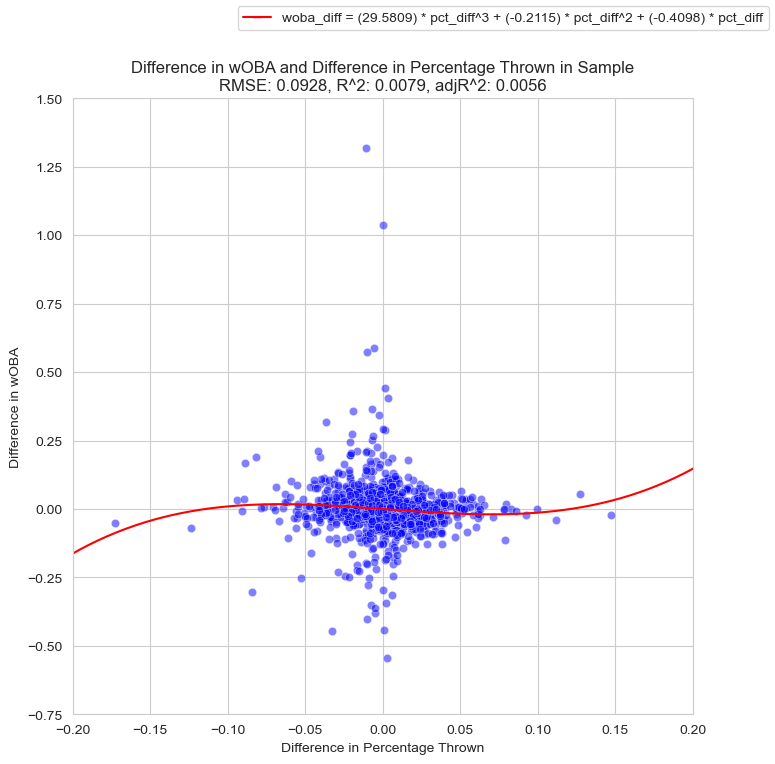

In [95]:
# set style to whitegrid to show grid on plot
sns.set_style("whitegrid");

# create the figure and the axes
# set the figure size to 8x8
f, ax = plt.subplots(figsize=(8, 8))
# plot percentage difference and wOBA difference as scatterplot
# set point color to blue
# set transperancy to 0.5
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=samples, ax=ax);

# create array of 1000 points from -1 to 1
x_values = np.linspace(-1, 1, 1000)
# apply model to array of points
y_values = outputs_sps3[1] * np.power(x_values, 3) + outputs_sps3[2] * np.power(x_values, 2) + outputs_sps3[3] * x_values

# plot model over scatterplot
# set line color to red
sns.lineplot(x=x_values, y=y_values, color='red', ax=ax);

# set x-axis limit from -0.2 to 0.2
ax.set_xlim(left=-0.2, right=0.2);
# set y-axis limit from -0.75 to 1.5
ax.set_ylim(bottom=-0.75, top=1.5);

# set title
# add model RMSE, model R^2 and model adjR^2 to figure title
# round to four decimal points
plt.title(f"Difference in wOBA and Difference in Percentage Thrown in Sample\nRMSE: {round(outputs_sps3[4], 4)}, R^2: {round(outputs_sps3[5], 4)}, adjR^2: {round(outputs_sps3[6], 4)}");
# set x-axis label
ax.set_xlabel("Difference in Percentage Thrown");
# set y-axis label
ax.set_ylabel("Difference in wOBA");

# store model function as label for legend
# round coefficients to four decimal points
legend_label = f"woba_diff = ({round(outputs_sps3[1], 4)}) * pct_diff^3 + ({round(outputs_sps3[2], 4)}) * pct_diff^2 + ({round(outputs_sps3[3], 4)}) * pct_diff"
# add legend to figure
# set label to model function
# set legend location to be top right
f.legend(handles=[Line2D([], [], marker='_', color='red', label=legend_label)], loc=1);

### Pitch Type

#### One Degree Model

$\Delta wOBA(\Delta x) = \beta_{1} \cdot \Delta x + \beta_{1,1} \cdot I_{CU} \cdot \Delta x + {...} + \beta_{1,9} \cdot I_{SV} \cdot \Delta x$

In [96]:
# fit one degree model on samples dataset with percent difference as the independent variable
# and pitch type as interaction terms
# store list of independent variables in the model
columns = ['pct_diff', 'is_CU', 'is_FC', 'is_FF', 
           'is_FS', 'is_KC', 'is_SI', 'is_SL', 
           'is_ST', 'is_SV']
# outputs_sppt1 = (sppt1, coef_pct_diff_sppt1, 
#                  coef_CU_int_sppt1, coef_FC_int_sppt1, coef_FF_int_sppt1, coef_FS_int_sppt1, 
#                  coef_KC_int_sppt1, coef_SI_int_sppt1, coef_SL_int_sppt1, coef_ST_int_sppt1, 
#                  coef_SV_int_sppt1, 
#                  rmse_sppt1, r_sq_sppt1, adj_r_sq_sppt1)
outputs_sppt1 = fit_regression_model_degree_one(samples, columns, 'woba_diff')

coefficient of (x_i - mu_i): -0.4301
coefficient of (x_i - mu_i) * I_CU: -0.3727
coefficient of (x_i - mu_i) * I_FC: -0.5572
coefficient of (x_i - mu_i) * I_FF: 0.3099
coefficient of (x_i - mu_i) * I_FS: 1.0733
coefficient of (x_i - mu_i) * I_KC: -1.0266
coefficient of (x_i - mu_i) * I_SI: 0.5762
coefficient of (x_i - mu_i) * I_SL: 0.1521
coefficient of (x_i - mu_i) * I_ST: 0.543
coefficient of (x_i - mu_i) * I_SV: 1.2298
rmse: 0.0923
r_squared: 0.0181
adj_r_squared: 0.0102


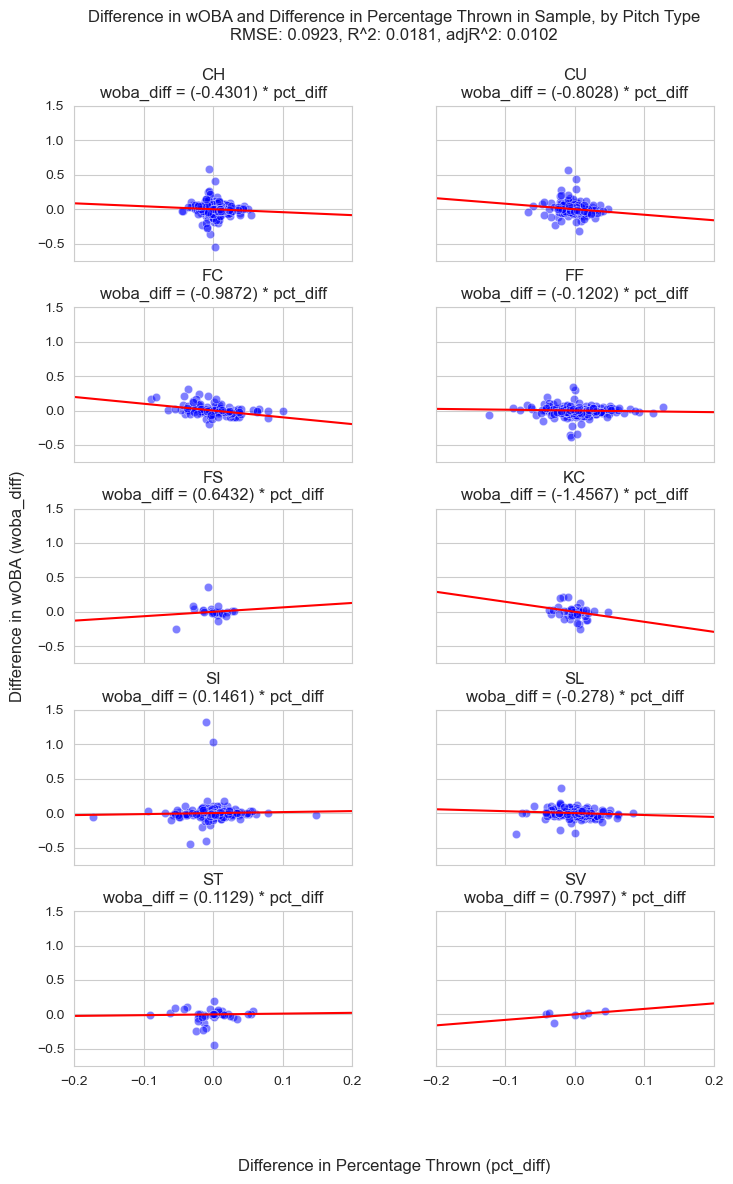

In [97]:
# set style to whitegrid to show grid on plot
sns.set_style("whitegrid");

# create the figure and the axes
# divide figure into 5x2 matrix to make separate plot for each pitch type
# set the figure size to 8x12
# set to have common x-axis and y-axis
f, ax = plt.subplots(5, 2, figsize=(8, 12), sharex=True, sharey=True)
# plot percentage difference and wOBA difference for changeups as scatterplot
# filter plotted dataset to only plot changeups
# this is all indicator variables are zero
# plot on subplot [0, 0]
# set point color to blue
# set transparency to 0.5
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=samples[(samples['is_CU'] == 0) & 
                                                                                       (samples['is_FC'] == 0) & 
                                                                                       (samples['is_FF'] == 0) & 
                                                                                       (samples['is_FS'] == 0) & 
                                                                                       (samples['is_KC'] == 0) &
                                                                                       (samples['is_SI'] == 0) &
                                                                                       (samples['is_SL'] == 0) &
                                                                                       (samples['is_ST'] == 0) &
                                                                                       (samples['is_SV'] == 0)], ax=ax[0, 0]);
# plot percentage difference and wOBA difference for each pitch type as scatterplot
# filter plotted dataset to only plot that pitch type
# this is the pitch type indicator is one
# plot on different subplot
# set point color to blue
# set transparency to 0.5
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=samples[samples['is_CU'] == 1], ax=ax[0, 1]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=samples[samples['is_FC'] == 1], ax=ax[1, 0]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=samples[samples['is_FF'] == 1], ax=ax[1, 1]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=samples[samples['is_FS'] == 1], ax=ax[2, 0]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=samples[samples['is_KC'] == 1], ax=ax[2, 1]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=samples[samples['is_SI'] == 1], ax=ax[3, 0]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=samples[samples['is_SL'] == 1], ax=ax[3, 1]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=samples[samples['is_ST'] == 1], ax=ax[4, 0]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=samples[samples['is_SV'] == 1], ax=ax[4, 1]);

# create array of 1000 points from -1 to 1
x_values = np.linspace(-1, 1, 1000)
# apply models for each pitch type to array of points
y_values_CH = outputs_sppt1[1] * x_values
y_values_CU = (outputs_sppt1[1] + outputs_sppt1[2]) * x_values
y_values_FC = (outputs_sppt1[1] + outputs_sppt1[3]) * x_values
y_values_FF = (outputs_sppt1[1] + outputs_sppt1[4]) * x_values
y_values_FS = (outputs_sppt1[1] + outputs_sppt1[5]) * x_values
y_values_KC = (outputs_sppt1[1] + outputs_sppt1[6]) * x_values
y_values_SI = (outputs_sppt1[1] + outputs_sppt1[7]) * x_values
y_values_SL = (outputs_sppt1[1] + outputs_sppt1[8]) * x_values
y_values_ST = (outputs_sppt1[1] + outputs_sppt1[9]) * x_values
y_values_SV = (outputs_sppt1[1] + outputs_sppt1[10]) * x_values

# plot models for each pitch type over scatterplots
# set line color to red
# plot on corresponding suplots
sns.lineplot(x=x_values, y=y_values_CH, color='red', ax=ax[0, 0]);
sns.lineplot(x=x_values, y=y_values_CU, color='red', ax=ax[0, 1]);
sns.lineplot(x=x_values, y=y_values_FC, color='red', ax=ax[1, 0]);
sns.lineplot(x=x_values, y=y_values_FF, color='red', ax=ax[1, 1]);
sns.lineplot(x=x_values, y=y_values_FS, color='red', ax=ax[2, 0]);
sns.lineplot(x=x_values, y=y_values_KC, color='red', ax=ax[2, 1]);
sns.lineplot(x=x_values, y=y_values_SI, color='red', ax=ax[3, 0]);
sns.lineplot(x=x_values, y=y_values_SL, color='red', ax=ax[3, 1]);
sns.lineplot(x=x_values, y=y_values_ST, color='red', ax=ax[4, 0]);
sns.lineplot(x=x_values, y=y_values_SV, color='red', ax=ax[4, 1]);

# set subplot title
# add model for each pitch type to subplot title
ax[0, 0].set_title(f"CH\nwoba_diff = ({round(outputs_sppt1[1], 4)}) * pct_diff");
ax[0, 1].set_title(f"CU\nwoba_diff = ({round((outputs_sppt1[1] + outputs_sppt1[2]), 4)}) * pct_diff");
ax[1, 0].set_title(f"FC\nwoba_diff = ({round((outputs_sppt1[1] + outputs_sppt1[3]), 4)}) * pct_diff");
ax[1, 1].set_title(f"FF\nwoba_diff = ({round((outputs_sppt1[1] + outputs_sppt1[4]), 4)}) * pct_diff");
ax[2, 0].set_title(f"FS\nwoba_diff = ({round((outputs_sppt1[1] + outputs_sppt1[5]), 4)}) * pct_diff");
ax[2, 1].set_title(f"KC\nwoba_diff = ({round((outputs_sppt1[1] + outputs_sppt1[6]), 4)}) * pct_diff");
ax[3, 0].set_title(f"SI\nwoba_diff = ({round((outputs_sppt1[1] + outputs_sppt1[7]), 4)}) * pct_diff");
ax[3, 1].set_title(f"SL\nwoba_diff = ({round((outputs_sppt1[1] + outputs_sppt1[8]), 4)}) * pct_diff");
ax[4, 0].set_title(f"ST\nwoba_diff = ({round((outputs_sppt1[1] + outputs_sppt1[9]), 4)}) * pct_diff");
ax[4, 1].set_title(f"SV\nwoba_diff = ({round((outputs_sppt1[1] + outputs_sppt1[10]), 4)}) * pct_diff");

# iterate over subplots
for i in range(0, 5):
    for j in range(0, 2):
        # set x-axis limit from -0.2 to 0.2
        ax[i, j].set_xlim(left=-0.2, right=0.2);
        # set y-axis limit from -0.75 to 1.5
        ax[i, j].set_ylim(bottom=-0.75, top=1.5);


# set title
# add model RMSE, model R^2 and model adjR^2 to figure title
# round to four decimal points
f.suptitle(f"Difference in wOBA and Difference in Percentage Thrown in Sample, by Pitch Type\nRMSE: {round(outputs_sppt1[11], 4)}, R^2: {round(outputs_sppt1[12], 4)}, adjR^2: {round(outputs_sppt1[13], 4)}");
# set x-axis label
f.supxlabel("Difference in Percentage Thrown (pct_diff)");
# set y-axis label
f.supylabel("Difference in wOBA (woba_diff)");
# iterate over subplots
for i in range(0, 5):
    for j in range(0, 2):
        # clear subplot x-axis label
        ax[i, j].set_xlabel("");
        # clear subplot y-axis label
        ax[i, j].set_ylabel("");
        
# add space between subplots
f.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.3);

#### Three Degree Model

$\Delta wOBA(\Delta x) = \beta_{3} \cdot (\Delta x)^3 + \beta_{2} \cdot (\Delta x)^2 + \beta_{1} \cdot \Delta x +\\
\beta_{3,1} \cdot I_{CU} \cdot (\Delta x)^3 + \beta_{2,1} \cdot I_{CU} \cdot (\Delta x)^2 + \beta_{1,1} \cdot I_{CU} \cdot \Delta x + {...} +\\ 
\beta_{3,9} \cdot I_{SV} \cdot (\Delta x)^3 + \beta_{2,9} \cdot I_{SV} \cdot (\Delta x)^2 + \beta_{1,9} \cdot I_{SV} \cdot \Delta x$

In [98]:
# fit three degree model on samples dataset with percent difference as the independent variable
# and pitch type as interaction terms
# store list of independent variables in the model
columns = ['pct_diff', 'is_CU', 'is_FC', 'is_FF', 
           'is_FS', 'is_KC', 'is_SI', 'is_SL', 
           'is_ST', 'is_SV']
outputs_sppt3 = fit_regression_model_degree_three(samples, columns, 'woba_diff')

coefficient of (x_i - mu_i)^3: 152.2193
coefficient of (x_i - mu_i)^2: 2.5291
coefficient of (x_i - mu_i): -0.6206
coefficient of (x_i - mu_i)^3 * I_pitch_type: 
[436.7247, -135.2532, -115.5844, 4032.3056, 1772.9955, -157.016, 160.6672, -255.7916, -1472.0172]
coefficient of (x_i - mu_i)^2 * I_pitch_type: 
[3.685, 6.6035, -2.49, 47.8484, -14.5208, -4.2562, -9.2434, -1.8409, 9.008]
coefficient of (x_i - mu_i) * I_pitch_type: 
[-0.9291, -0.5214, 0.3058, -3.5927, -2.7833, 0.7792, -0.5197, 1.1283, 3.4613]
rmse: 0.0912
r_squared: 0.042
adj_r_squared: 0.0186


### Usage Rank

#### All Usage Ranks

##### One Degree Model

$\Delta wOBA(\Delta x) = \beta_{1} \cdot \Delta x + \beta_{1,1} \cdot J_{second} \cdot \Delta x + {...} + \beta_{1,7} \cdot J_{eighth} \cdot \Delta x$

In [99]:
# fit one degree model on samples dataset with percent difference as the independent variable
# and usage rank as interaction terms
# store list of independent variables in the model
columns = ['pct_diff', 'is_second', 'is_third', 'is_fourth', 
           'is_fifth', 'is_sixth', 'is_seventh', 'is_eighth']
# outputs_sppu1 = (sppu1, coef_pct_diff_sppu1, 
#                  coef_second_int_sppu1, coef_third_int_sppu1, coef_fourth_int_sppu1, coef_fifth_int_sppu1, 
#                  coef_sixth_int_sppu1, coef_seventh_int_sppu1,
#                  rmse_sppu1, r_sq_sppu1, adj_r_sq_sppu1)
outputs_sppu1 = fit_regression_model_degree_one(samples, columns, 'woba_diff')

coefficient of (x_i - mu_i): -0.0707
coefficient of (x_i - mu_i) * J_second: -0.2411
coefficient of (x_i - mu_i) * J_third: -0.1912
coefficient of (x_i - mu_i) * J_fourth: -0.6815
coefficient of (x_i - mu_i) * J_fifth: -0.3569
coefficient of (x_i - mu_i) * J_sixth: 0.5521
coefficient of (x_i - mu_i) * J_seventh: 2.3835
coefficient of (x_i - mu_i) * J_eighth: 6.3409
rmse: 0.0927
r_squared: 0.0105
adj_r_squared: 0.0042


##### Three Degree Model

$\Delta wOBA(\Delta x) = \beta_{3} \cdot (\Delta x)^3 + \beta_{2} \cdot (\Delta x)^2 + \beta_{1} \cdot \Delta x +\\
\beta_{3,1} \cdot J_{second} \cdot (\Delta x)^3 + \beta_{2,1} \cdot J_{second} \cdot (\Delta x)^2 + \beta_{1,1} \cdot J_{second} \cdot \Delta x + {...} +\\ 
\beta_{3,7} \cdot J_{eighth} \cdot (\Delta x)^3 + \beta_{2,7} \cdot J_{eighth} \cdot (\Delta x)^2 + \beta_{1,7} \cdot J_{eighth} \cdot \Delta x$

In [100]:
# fit three degree model on samples dataset with percent difference as the independent variable
# and usage rank as interaction terms
# store list of independent variables in the model
columns = ['pct_diff', 'is_second', 'is_third', 'is_fourth', 
           'is_fifth', 'is_sixth', 'is_seventh', 'is_eighth']
outputs_sppu3 = fit_regression_model_degree_three(samples, columns, 'woba_diff')

coefficient of (x_i - mu_i)^3: 45.1516
coefficient of (x_i - mu_i)^2: -0.6745
coefficient of (x_i - mu_i): -0.2803
coefficient of (x_i - mu_i)^3 * J_use: 
[-27.377, -19.3831, -127.0812, 427.953, 688.3738, 25093.8899, -15.1256]
coefficient of (x_i - mu_i)^2 * J_use: 
[0.5221, 0.2856, 8.5183, -9.7833, -52.1785, -187.0913, 1866.7519]
coefficient of (x_i - mu_i) * J_use: 
[-0.0799, -0.2151, -0.1811, -1.3689, -0.2811, -8.8626, 25.018]
rmse: 0.0914
r_squared: 0.0369
adj_r_squared: 0.0182


#### Combined Usage Ranks

##### One Degree Model

$\Delta wOBA(\Delta x) = \beta_{1} \cdot \Delta x + \beta_{1,1} \cdot J_{second} \cdot \Delta x + {...} + \beta_{1,3} \cdot J_{fourth\_to\_eighth} \cdot \Delta x$

In [101]:
# fit one degree model on samples dataset with percent difference as the independent variable
# and combined usage rank as interaction terms
# store list of independent variables in the model
columns = ['pct_diff', 'is_second', 'is_third', 'is_fourth_to_eighth']
# outputs_sppuc1 = (sppuc1, coef_pct_diff_sppuc1, 
#                  coef_second_int_sppuc1, coef_third_int_sppuc1, coef_fourth_int_sppuc1, coef_fifth_int_sppuc1, 
#                  coef_sixth_int_sppuc1, coef_seventh_int_sppuc1,
#                  rmse_sppuc1, r_sq_sppuc1, adj_r_sq_sppuc1)
outputs_sppuc1 = fit_regression_model_degree_one(samples, columns, 'woba_diff')

coefficient of (x_i - mu_i): -0.0707
coefficient of (x_i - mu_i) * J_second: -0.2411
coefficient of (x_i - mu_i) * J_third: -0.1912
coefficient of (x_i - mu_i) * J_fourth_to_eighth: -0.4129
rmse: 0.0929
r_squared: 0.0066
adj_r_squared: 0.0034


##### Three Degree Model

$\Delta wOBA(\Delta x) = \beta_{3} \cdot (\Delta x)^3 + \beta_{2} \cdot (\Delta x)^2 + \beta_{1} \cdot \Delta x +\\
\beta_{3,1} \cdot J_{second} \cdot (\Delta x)^3 + \beta_{2,1} \cdot J_{second} \cdot (\Delta x)^2 + \beta_{1,1} \cdot J_{second} \cdot \Delta x + {...} +\\ 
\beta_{3,3} \cdot J_{fourth\_to\_eighth} \cdot (\Delta x)^3 + \beta_{2,3} \cdot J_{fourth\_to\_eighth} \cdot (\Delta x)^2 + \beta_{1,3} \cdot J_{fourth\_to\_eighth} \cdot \Delta x$

In [102]:
# fit three degree model on samples dataset with percent difference as the independent variable
# and combined usage rank as interaction terms
# store list of independent variables in the model
columns = ['pct_diff', 'is_second', 'is_third', 'is_fourth_to_eighth']
outputs_sppuc3 = fit_regression_model_degree_three(samples, columns, 'woba_diff')

coefficient of (x_i - mu_i)^3: 45.1516
coefficient of (x_i - mu_i)^2: -0.6745
coefficient of (x_i - mu_i): -0.2803
coefficient of (x_i - mu_i)^3 * J_use: 
[-27.377, -19.3831, 41.6949]
coefficient of (x_i - mu_i)^2 * J_use: 
[0.5221, 0.2856, 1.0447]
coefficient of (x_i - mu_i) * J_use: 
[-0.0799, -0.2151, -0.4284]
rmse: 0.0927
r_squared: 0.0099
adj_r_squared: 0.0004


### Pitch Type and Usage Rank

#### All Usage Ranks

##### One Degree Model

$\Delta wOBA(\Delta x) = \beta_{1} \cdot \Delta x + \beta_{1,1,0} \cdot I_{CU} \cdot \Delta x + {...} + \beta_{1,9,0} \cdot I_{SV} \cdot \Delta x + \beta_{1,0,1} \cdot J_{second} \cdot \Delta x + {...} + \beta_{1,0,7} \cdot J_{eighth} \cdot \Delta x +\\
\beta_{1,1,1} \cdot I_{CU} \cdot J_{second} \cdot \Delta x + {...} + \beta_{1,9,7} \cdot I_{SV} \cdot J_{eighth} \cdot \Delta x$

In [103]:
# fit one degree model on samples dataset with percent difference as the independent variable
# and pitch type and usage rank as interaction terms
# store list of independent variables in the model
columns = ['pct_diff', 'is_CU', 'is_FC', 'is_FF', 
           'is_FS', 'is_KC', 'is_SI', 'is_SL', 
           'is_ST', 'is_SV', 'is_second', 'is_third', 
           'is_fourth', 'is_fifth', 'is_sixth', 'is_seventh', 
           'is_eighth']
# outputs_spptpu1 = (spptpu1, coef_pct_diff_spptpu1, 
#                    coef_CU_int_spptpu1, coef_FC_int_spptpu1, coef_FF_int_spptpu1, coef_FS_int_spptpu1, 
#                    coef_KC_int_spptpu1, coef_SI_int_spptpu1, coef_SL_int_spptpu1, coef_ST_int_spptpu1,
#                    coef_SV_int_spptpu1,
#                    coef_second_int_spptpu1, coef_third_int_spptpu1, coef_fourth_int_spptpu1, coef_fifth_int_spptpu1,
#                    coef_sixth_int_spptpu1, coef_seventh_int_sppt_pu1, coef_eighth_int_spptpu1,
#                    coefs_CU_use_int_spptpu1, coefs_FC_use_int_spptpu1, coefs_FF_use_int_spptpu1, coefs_FS_use_int_spptpu1, 
#                    coefs_KC_use_int_spptpu1, coefs_SI_use_int_spptpu1, coefs_SL_use_int_spptpu1, coefs_ST_use_int_spptpu1,
#                    coefs_SV_use_int_spptpu1,
#                    rmse_spptpu1, r_sq_spptpu1, adj_r_sq_spptpu1)
outputs_spptpu1 = fit_regression_model_degree_one(samples, columns, 'woba_diff')

coefficient of (x_i - mu_i): -1.2857
coefficient of (x_i - mu_i) * I_CU: 0.4211
coefficient of (x_i - mu_i) * I_FC: 1.0201
coefficient of (x_i - mu_i) * I_FF: 1.2694
coefficient of (x_i - mu_i) * I_FS: -14.3171
coefficient of (x_i - mu_i) * I_KC: 1.8641
coefficient of (x_i - mu_i) * I_SI: 1.3909
coefficient of (x_i - mu_i) * I_SL: 0.5523
coefficient of (x_i - mu_i) * I_ST: 0.747
coefficient of (x_i - mu_i) * I_SV: -0.0935
coefficient of (x_i - mu_i) * J_second: 0.7658
coefficient of (x_i - mu_i) * J_third: 0.6232
coefficient of (x_i - mu_i) * J_fourth: 1.7696
coefficient of (x_i - mu_i) * J_fifth: 0.6707
coefficient of (x_i - mu_i) * J_sixth: -4.9832
coefficient of (x_i - mu_i) * J_seventh: -16.5545
coefficient of (x_i - mu_i) * J_eighth: 2.8459
coefficient of (x_i - mu_i) * I_CU * J_use: 
[-0.6053, 0.0727, -1.936, -1.4059, 0.9816, 15.7596, 0.0]
coefficient of (x_i - mu_i) * I_FC * J_use: 
[-0.5709, -0.9284, -3.1013, -2.6164, 2.7693, 16.8202, 0.0]
coefficient of (x_i - mu_i) * I_FF * J

##### Three Degree Model

$\Delta wOBA(\Delta x) = \beta_{3} \cdot (\Delta x)^{3} + \beta_{2} \cdot (\Delta x) ^ 2 + \beta_{1} \cdot \Delta x +\\
\beta_{3, 1, 0} \cdot I_{CU} \cdot (\Delta x)^{3} + \beta_{2, 1, 0} \cdot I_{CU} \cdot (\Delta x)^2 + \beta_{1, 1, 0} \cdot I_{CU} \cdot \Delta x + {...} +\\
\beta_{3, 9, 0} \cdot I_{SV} \cdot (\Delta x)^{3} + \beta_{2, 9, 0} \cdot I_{SV} \cdot (\Delta x)^2 + \beta_{1, 9, 0} \cdot I_{SV} \cdot \Delta x + \\
\beta_{3, 0, 1} \cdot J_{second} \cdot (\Delta x)^3 + \beta_{2, 0, 1} \cdot J_{second} \cdot (\Delta x)^2 + \beta_{1, 0, 1} \cdot J_{second} \cdot \Delta x + {...} +\\
\beta_{3, 0, 7} \cdot J_{eighth} \cdot (\Delta x)^3 + \beta_{2, 0, 7} \cdot J_{eighth} \cdot (\Delta x)^2 + \beta_{1, 0, 7} \cdot J_{eighth} \cdot \Delta x +\\
\beta_{3, 1, 1} \cdot I_{CU} \cdot J_{second} \cdot (\Delta x)^3 + \beta_{2, 1, 1} \cdot I_{CU} \cdot J_{second} \cdot (\Delta x)^2 + \beta_{1, 1, 1} \cdot I_{CU} \cdot J_{second} \cdot \Delta x + {...} +\\
\beta_{3, 9, 7} \cdot I_{SV} \cdot J_{eighth} \cdot (\Delta x)^3 + \beta_{2, 9, 7} \cdot I_{SV} \cdot J_{eighth} \cdot (\Delta x)^2 + \beta_{1, 9, 7} \cdot I_{SV} \cdot J_{eighth} \cdot \Delta x$

In [104]:
# fit three degree model on samples dataset with percent difference as the independent variable
# and pitch type and usage rank as interaction terms
# store list of independent variables in the model
columns = ['pct_diff', 'is_CU', 'is_FC', 'is_FF', 
           'is_FS', 'is_KC', 'is_SI', 'is_SL', 
           'is_ST', 'is_SV', 'is_second', 'is_third', 
           'is_fourth', 'is_fifth', 'is_sixth', 'is_seventh', 
           'is_eighth']
outputs_spptpu3 = fit_regression_model_degree_three(samples, columns, 'woba_diff')

coefficient of (x_i - mu_i)^3: 2455.421
coefficient of (x_i - mu_i)^2: 156.4337
coefficient of (x_i - mu_i): 0.4422
coefficient of (x_i - mu_i)^3 * I_pitch_type: 
[1437.0254, -2475.2966, -2414.9373, -15237.4192, -7887.8096, -2410.8966, -2120.9181, -1727.492, 155.1419]
coefficient of (x_i - mu_i)^2 * I_pitch_type: 
[-229.9683, -159.0081, -156.5739, -2549.9235, -129.7887, -160.2356, -157.2927, -145.9659, 2301.1129]
coefficient of (x_i - mu_i) * I_pitch_type: 
[-5.7227, -0.5767, -0.6916, -21.0317, 3.4338, -0.4873, -2.209, -3.0637, -27.6161]
coefficient of (x_i - mu_i)^3 * J_use: 
[155.142, -2354.9107, -2283.751, -2018.4337, -3118.4469, 85591.8081, -275562.4723]
coefficient of (x_i - mu_i)^2 * J_use: 
[2301.1129, -157.7541, -141.9711, -149.271, -134.8453, -56.3988, 3439.0072]
coefficient of (x_i - mu_i) * J_use: 
[-27.6161, -1.0578, -1.4374, -0.4207, -0.7187, -28.025, -23.1768]
coefficient of (x_i - mu_i)^3 * I_pitch_type * J_use: 
[[0.0, -1488.24, -1376.4541, 771.7481, 1038.3817, -91430.0

#### Combined Usage Ranks

##### One Degree Model

$\Delta wOBA(\Delta x) = \beta_{1} \cdot \Delta x + \beta_{1,1,0} \cdot I_{CU} \cdot \Delta x + {...} + \beta_{1,9,0} \cdot I_{SV} \cdot \Delta x + \beta_{1,0,1} \cdot J_{second} \cdot \Delta x + {...} + \beta_{1,0,3} \cdot J_{fourth\_to\_eighth} \cdot \Delta x +\\
\beta_{1,1,1} \cdot I_{CU} \cdot J_{second} \cdot \Delta x + {...} + \beta_{1,9,3} \cdot I_{SV} \cdot J_{fourth\_to\_eighth} \cdot \Delta x$

In [105]:
# fit one degree model on samples dataset with percent difference as the independent variable
# and pitch type and combined usage rank as interaction terms
# store list of independent variables in the model
columns = ['pct_diff', 'is_CU', 'is_FC', 'is_FF', 
           'is_FS', 'is_KC', 'is_SI', 'is_SL', 
           'is_ST', 'is_SV', 'is_second', 'is_third', 
           'is_fourth_to_eighth']
outputs_spptpuc1 = fit_regression_model_degree_one(samples, columns, 'woba_diff')

coefficient of (x_i - mu_i): -1.2857
coefficient of (x_i - mu_i) * I_CU: 0.4211
coefficient of (x_i - mu_i) * I_FC: 1.0201
coefficient of (x_i - mu_i) * I_FF: 1.2694
coefficient of (x_i - mu_i) * I_FS: -14.3171
coefficient of (x_i - mu_i) * I_KC: 1.8641
coefficient of (x_i - mu_i) * I_SI: 1.3909
coefficient of (x_i - mu_i) * I_SL: 0.5523
coefficient of (x_i - mu_i) * I_ST: 0.747
coefficient of (x_i - mu_i) * I_SV: -0.0935
coefficient of (x_i - mu_i) * J_second: 0.7658
coefficient of (x_i - mu_i) * J_third: 0.6232
coefficient of (x_i - mu_i) * J_fourth_to_eighth: 1.0341
coefficient of (x_i - mu_i) * I_CU * J_use: 
[-0.6053, 0.0727, -1.622]
coefficient of (x_i - mu_i) * I_FC * J_use: 
[-0.5709, -0.9284, -2.5654]
coefficient of (x_i - mu_i) * I_FF * J_use: 
[-1.2288, -0.4919, -1.65]
coefficient of (x_i - mu_i) * I_FS * J_use: 
[13.2691, 14.9165, 17.3643]
coefficient of (x_i - mu_i) * I_KC * J_use: 
[-1.1805, -3.2449, -4.1557]
coefficient of (x_i - mu_i) * I_SI * J_use: 
[-0.7813, -0.7058,

##### Three Degree Model

$\Delta wOBA(\Delta x) = \beta_{3} \cdot (\Delta x)^{3} + \beta_{2} \cdot (\Delta x) ^ 2 + \beta_{1} \cdot \Delta x +\\
\beta_{3, 1, 0} \cdot I_{CU} \cdot (\Delta x)^{3} + \beta_{2, 1, 0} \cdot I_{CU} \cdot (\Delta x)^2 + \beta_{1, 1, 0} \cdot I_{CU} \cdot \Delta x + {...} +\\
\beta_{3, 9, 0} \cdot I_{SV} \cdot (\Delta x)^{3} + \beta_{2, 9, 0} \cdot I_{SV} \cdot (\Delta x)^2 + \beta_{1, 9, 0} \cdot I_{SV} \cdot \Delta x + \\
\beta_{3, 0, 1} \cdot J_{second} \cdot (\Delta x)^3 + \beta_{2, 0, 1} \cdot J_{second} \cdot (\Delta x)^2 + \beta_{1, 0, 1} \cdot J_{second} \cdot \Delta x + {...} +\\
\beta_{3, 0, 3} \cdot J_{fourth\_to\_eighth} \cdot (\Delta x)^3 + \beta_{2, 0, 3} \cdot J_{fourth\_to\_eighth} \cdot (\Delta x)^2 + \beta_{1, 0, 3} \cdot J_{fourth\_to\_eighth} \cdot \Delta x +\\
\beta_{3, 1, 1} \cdot I_{CU} \cdot J_{second} \cdot (\Delta x)^3 + \beta_{2, 1, 1} \cdot I_{CU} \cdot J_{second} \cdot (\Delta x)^2 + \beta_{1, 1, 1} \cdot I_{CU} \cdot J_{second} \cdot \Delta x + {...} +\\
\beta_{3, 9, 3} \cdot I_{SV} \cdot J_{fourth\_to\_eighth} \cdot (\Delta x)^3 + \beta_{2, 9, 3} \cdot I_{SV} \cdot J_{fourth\_to\_eighth} \cdot (\Delta x)^2 + \beta_{1, 9, 3} \cdot I_{SV} \cdot J_{fourth\_to\_eighth} \cdot \Delta x$

In [106]:
# fit three degree model on samples dataset with percent difference as the independent variable
# and pitch type and usage rank as interaction terms
# store list of independent variables in the model
columns = ['pct_diff', 'is_CU', 'is_FC', 'is_FF', 
           'is_FS', 'is_KC', 'is_SI', 'is_SL', 
           'is_ST', 'is_SV', 'is_second', 'is_third', 
           'is_fourth_to_eighth']
outputs_spptpuc3 = fit_regression_model_degree_three(samples, columns, 'woba_diff')

coefficient of (x_i - mu_i)^3: 88.7396
coefficient of (x_i - mu_i)^2: -1.0103
coefficient of (x_i - mu_i): -0.349
coefficient of (x_i - mu_i)^3 * I_pitch_type: 
[1517.5176, 12.1175, -45.6274, 25892.7119, 3627.0924, -68.3553, 331.9013, -1249.7572, 987.5901]
coefficient of (x_i - mu_i)^2 * I_pitch_type: 
[2.2496, 13.4399, 1.6269, 811.4879, 37.5109, -4.5304, -10.0758, -4.924, -27.2108]
coefficient of (x_i - mu_i) * I_pitch_type: 
[-2.5592, -1.6107, 0.0292, -24.6, -3.384, 0.5755, -1.0433, 3.2273, -0.1614]
coefficient of (x_i - mu_i)^3 * J_use: 
[987.5901, 11.7707, 82.9304]
coefficient of (x_i - mu_i)^2 * J_use: 
[-27.2108, -0.3102, 15.4728]
coefficient of (x_i - mu_i) * J_use: 
[-0.1614, -0.2666, -0.6462]
coefficient of (x_i - mu_i)^3 * I_pitch_type * J_use: 
[[0.0, -1568.7321, -1456.9463], [0.0, -156.6419, 10.3889], [0.0, -88.8155, 134.5045], [0.0, -24890.8048, -32057.2908], [0.0, -4775.9302, -2036.3527], [0.0, 246.4983, -94.6486], [0.0, -285.6016, -676.2563], [0.0, 2453.1122, 1558.0113],

<a id='AnalysisofModels'></a>

# Section 7 - Analysis of Models

We will now compare the RMSE, the $R^2$, and the $R_{adj}^{2}$ of all of the models fit in the previous section in order to select the best performing model.

In [107]:
# create list of model names
model_names = ['aps1', 'aps3', 'nos1', 'nos3', 
               'appt1', 'appt3', 'appu1', 'appu3', 
               'appuc1', 'appuc3', 'apptpu1', 'apptpu3', 
               'apptpuc1', 'apptpuc3', 
               'sps1', 'sps3', 'sppt1', 'sppt3', 
               'sppu1', 'sppu3', 'sppuc1', 'sppuc3', 
               'spptpu1', 'spptpu3', 'spptpuc1', 'spptpuc3']
# create list of model RMSE
model_rmses = [outputs_aps1[2], outputs_aps3[4], outputs_nos1[2], outputs_nos3[4], 
               outputs_appt1[11], outputs_appt3[7], outputs_appu1[9], outputs_appu3[7], 
               outputs_appuc1[5], outputs_appuc3[7], outputs_apptpu1[27], outputs_apptpu3[13], 
               outputs_apptpuc1[23], outputs_apptpuc3[13], 
               outputs_sps1[2], outputs_sps3[4], outputs_sppt1[11], outputs_sppt3[7], 
               outputs_sppu1[9], outputs_sppu3[7], outputs_sppuc1[5], outputs_sppuc3[7], 
               outputs_spptpu1[27], outputs_spptpu3[13], outputs_spptpuc1[23], outputs_spptpuc3[13]]
# create list of model R^2
model_r_sqs = [outputs_aps1[3], outputs_aps3[5], outputs_nos1[3], outputs_nos3[5], 
                      outputs_appt1[12], outputs_appt3[8], outputs_appu1[10], outputs_appu3[8], 
                      outputs_appuc1[6], outputs_appuc3[8], outputs_apptpu1[28], outputs_apptpu3[14], 
                      outputs_apptpuc1[24], outputs_apptpuc3[14], 
                      outputs_sps1[3], outputs_sps3[5], outputs_sppt1[12], outputs_sppt3[8], 
                      outputs_sppu1[10], outputs_sppu3[8], outputs_sppuc1[6], outputs_sppuc3[8], 
                      outputs_spptpu1[28], outputs_spptpu3[14], outputs_spptpuc1[24], outputs_spptpuc3[14]]
# create list of model adjR^2
model_adj_r_sqs = [outputs_aps1[4], outputs_aps3[6], outputs_nos1[4], outputs_nos3[6], 
                      outputs_appt1[13], outputs_appt3[9], outputs_appu1[11], outputs_appu3[9], 
                      outputs_appuc1[7], outputs_appuc3[9], outputs_apptpu1[29], outputs_apptpu3[15], 
                      outputs_apptpuc1[25], outputs_apptpuc3[15], 
                      outputs_sps1[4], outputs_sps3[6], outputs_sppt1[13], outputs_sppt3[9], 
                      outputs_sppu1[11], outputs_sppu3[9], outputs_sppuc1[7], outputs_sppuc3[9], 
                      outputs_spptpu1[29], outputs_spptpu3[15], outputs_spptpuc1[25], outputs_spptpuc3[15]]
# create dictionary with model names, RMSE, R^2 and adjR^2
model_performance_df = {'Model': model_names,
                        'RMSE': model_rmses,
                        'R^2': model_r_sqs, 
                        'adjR^2': model_adj_r_sqs}
# create DataFrame from dictionary
model_performance_df = pd.DataFrame(data=model_performance_df)

# view DataFrame
# round values to four decimals
model_performance_df.round({'RMSE': 4, 'R^2': 4, 'adjR^2': 4})

,Model,RMSE,R^2,adjR^2
0,aps1,0.3567,0.0091,0.0090
1,aps3,0.3567,0.0092,0.0091
2,nos1,0.3569,0.0091,0.0091
3,nos3,0.3568,0.0093,0.0092
4,appt1,0.3566,0.0097,0.0095
5,appt3,0.3564,0.0108,0.0103
6,appu1,0.3567,0.0092,0.0091
7,appu3,0.3563,0.0116,0.0112
8,appuc1,0.3567,0.0092,0.0091
9,appuc3,0.3563,0.0114,0.0112


First we will view the best five models by RMSE, that is the five models with the lowest RMSE.

In [108]:
# view top five models by RMSE
# sort DataFrame by RMSE
# round values to four decimals
model_performance_df.round({'RMSE': 4, 'R^2': 4, 'adjR^2': 4}).sort_values(by='RMSE').head()

,Model,RMSE,R^2,adjR^2
23,spptpu3,0.0849,0.1689,-0.0261
22,spptpu1,0.0896,0.0750,0.0125
25,spptpuc3,0.0899,0.0687,-0.0291
17,sppt3,0.0912,0.0420,0.0186
19,sppu3,0.0914,0.0369,0.0182


The top five models by RMSE are all fit on samples of 1150 pitches. From lowest RMSE to fifth-smallest these are: degree three with pitch type and all usage ranks, degree one with pitch type and usage rank, degree three with pitch type and combined usage rank, degree three with pitch type, and degree one with pitch type and combined usage rank. I believe it is interesting to note that the three degree model with only pitch type outperformed, by RMSE, the one degree model with pitch type and combined usage rank (though their RMSE are very close). This model with only pitch type is simpler by number of variables (where fewer is simpler).

Next we will view the five models with the highest $R^2$ value.

In [109]:
# view top five models by R^2
# sort DataFrame by R^2
# sort in descending order
# round values to four decimals
model_performance_df.round({'RMSE': 4, 'R^2': 4, 'adjR^2': 4}).sort_values(by='R^2', ascending=False).head()

,Model,RMSE,R^2,adjR^2
23,spptpu3,0.0849,0.1689,-0.0261
22,spptpu1,0.0896,0.0750,0.0125
25,spptpuc3,0.0899,0.0687,-0.0291
17,sppt3,0.0912,0.0420,0.0186
19,sppu3,0.0914,0.0369,0.0182


The top four performing models by RMSE were the top four performing models by $R^2$ (in the same order). Here, however, the three degree model with only pitch type was the fifth best performing model.

Finally, we will view the five models with the highest $R_{adj}^2$ value. Using this value will penalize models heavier the more variables that they contain.

In [110]:
# view top five models by adjR^2
# sort DataFrame by adjR^2
# sort in descending order
# round values to four decimals
model_performance_df.round({'RMSE': 4, 'R^2': 4, 'adjR^2': 4}).sort_values(by='adjR^2', ascending=False).head()

,Model,RMSE,R^2,adjR^2
17,sppt3,0.0912,0.0420,0.0186
19,sppu3,0.0914,0.0369,0.0182
22,spptpu1,0.0896,0.0750,0.0125
11,apptpu3,0.3554,0.0166,0.0122
9,appuc3,0.3563,0.0114,0.0112


Here, in order from highest $R_{adj}^2$ to lowest we have: three degrees with pitch type, three degrees with all usage ranks, one degree with pitch type and all pitch usage ranks, three degrees with pitch type and all usage ranks, and three degrees with all usage ranks. The top three models were fit on samples of 1150 pitches and the fourth and fifth best by $R_{adj}^2$ were fit on appearances. However there is a gap within the top five, where the $R_{adj}^2$ decreases from above 0.018 to exactly or below 0.0125 after the best two models.

The models fit on samples of 1150 pitches generally fit the data better than the models using the same variables fit on the data from each appearance. This is likely explained by the fact that one appearance by a pitcher is a sample size that is too small to draw any meaningful conclusions from the sample wOBA. This meant that the differences in wOBA in appearances had a much higher variation, thus causes a higher RMSE, or more unexplainable variance by the model causing lower $R^2$ or $R_{adj}^2$. 

The best performing model by RMSE and (unadjusted) coefficient of determination $R^{2}$ was the model with a polynomial of degree three fit on samples of 1150 pitches using each pitch type and all usage ranks. The RMSE being low indicates that the model does a good job of predicting values closer to the observed values, and the predicted values appear to explain 16.88% of the variation in observed values. However by looking at the adjusted coefficient of determination $R_{adj}^{2}$, it is likely that the large number of variables in the model caused overfitting, as the $R_{adj}^{2}$ was negative, meaning that the model actually performed worse than a model reflecting no relationship, i.e. outputting a constant value.

Selecting a model that best balanced performance in RMSE and $R_{adj}^{2}$ is the model with a polynomial of degree three fit on samples of 1150 pitches using pitch type only. The RMSE of this model was 0.0912 (the fourth lowest of all models), the $R^{2}$ was 0.0416 (the fourth highest of all models), and the $R_{adj}^{2}$ was 0.0183 (the highest of all models). This model is as follows.

$\Delta wOBA_{i}(\Delta x_{i}) = (152.4735 + a) \cdot (\Delta x_{i})^{3} + (2.5574 + b) \cdot (\Delta x_{i})^{2} + (-0.6223 + c) \cdot \Delta x_{i}$

where

$a = 0, b = 0, c = 0$ if $i = CH$\
$a = 437.1525, b = 3.6643, c = -0.9289$ if $i = CU$\
$a = -138.6559, b = 6.2984, c = -0.4838$ if $i = FC$\
$a = -115.8369, b = -2.5182, c = 0.3075$ if $i = FF$\
$a = 4032.0514, b = 47.8201, c = -3.5910$ if $i = FS$\
$a = 1772.7413, b = -14.5492, c = -2.7816$ if $i = KC$\
$a = -157.2779, b = -4.4845, c = 0.7811$ if $i = SI$\
$a = 159.9137, b = -9.2623, c = -0.5160$ if $i = SL$\
$a = -256.0458, b = -1.8693, c = 1.1300$ if $i = ST$\
$a = -1472.2715, b = 8.9796, c = 3.4630$ if $i = SV$

Alternatively by substituting the representation used to calculate $\Delta x_{i}$ back into the model, that is $\Delta x = x - \mu$, this is as follows.

$\Delta wOBA_{i}(x_{i} - \mu_{i}) = (152.4735 + a) \cdot (x_{i} - \mu_{i})^{3} + (2.5574 + b) \cdot (x_{i} - \mu_{i})^{2} + (-0.6223 + c) \cdot (x_{i} - \mu_{i})$

where $a$, $b$, and $c$ are defined as above.

Represented with an equation for each pitch type, this is as follows.

$\Delta wOBA_{CH}(x_{CH} - \mu_{CH}) = 152.4735 \cdot (x_{CH} - \mu_{CH})^3 + 2.5574 \cdot (x_{CH} - \mu_{CH})^2 - 0.6223 \cdot (x_{CH} - \mu_{CH})$\
$\Delta wOBA_{CU}(x_{CU} - \mu_{CU}) = 589.6260 \cdot (x_{CU} - \mu_{CU})^3 + 6.2217 \cdot (x_{CU} - \mu_{CU})^2 - 1.5512 \cdot (x_{CU} - \mu_{CU})$\
$\Delta wOBA_{FC}(x_{FC} - \mu_{FC}) = 13.8176 \cdot (x_{FC} - \mu_{FC})^3 + 8.8558 \cdot (x_{FC} - \mu_{FC})^2 - 1.1061 \cdot (x_{FC} - \mu_{FC})$\
$\Delta wOBA_{FF}(x_{FF} - \mu_{FF}) = 36.6366 \cdot (x_{FF} - \mu_{FF})^3 + 0.0392 \cdot (x_{FF} - \mu_{FF})^2 - 0.3148 \cdot (x_{FF} - \mu_{FF})$\
$\Delta wOBA_{FS}(x_{FS} - \mu_{FS}) = 4184.5249 \cdot (x_{FS} - \mu_{FS})^3 + 50.3775 \cdot (x_{FS} - \mu_{FS})^2 - 4.2132 \cdot (x_{FS} - \mu_{FS})$\
$\Delta wOBA_{KC}(x_{KC} - \mu_{KC}) = 1925.2148 \cdot (x_{KC} - \mu_{KC})^3 - 11.9918 \cdot (x_{KC} - \mu_{KC})^2 - 3.4039 \cdot (x_{KC} - \mu_{KC})$\
$\Delta wOBA_{SI}(x_{SI} - \mu_{SI}) = -4.8044 \cdot (x_{SI} - \mu_{SI})^3 - 1.7271 \cdot (x_{SI} - \mu_{SI})^2 + 0.1588 \cdot (x_{SI} - \mu_{SI})$\
$\Delta wOBA_{SL}(x_{SL} - \mu_{SL}) = 312.3872 \cdot (x_{SL} - \mu_{SL})^3 - 6.7048 \cdot (x_{SL} - \mu_{SL})^2 - 1.1383 \cdot (x_{SL} - \mu_{SL})$\
$\Delta wOBA_{ST}(x_{ST} - \mu_{ST}) = -103.5723 \cdot (x_{ST} - \mu_{ST})^3 + 0.6882 \cdot (x_{ST} - \mu_{ST})^2 - 0.5077 \cdot (x_{ST} - \mu_{ST})$\
$\Delta wOBA_{SV}(x_{SV} - \mu_{SV}) = -1319.7980 \cdot (x_{SV} - \mu_{SV})^3 + 11.5371 \cdot (x_{SV} - \mu_{SV})^2 + 2.8408 \cdot (x_{SV} - \mu_{SV})$

Below is a plot visualizing the model by pitch type.

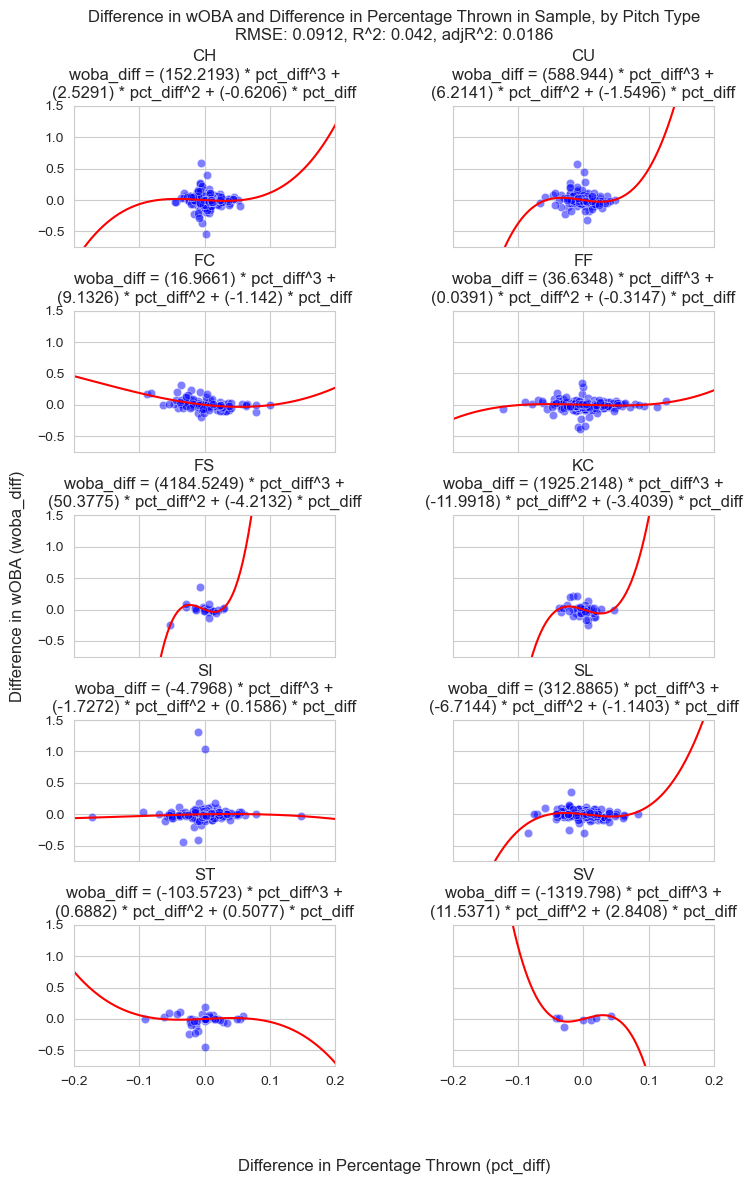

In [111]:
# set style to whitegrid to show grid on plot
sns.set_style("whitegrid");

# create the figure and the axes
# divide figure into 5x2 matrix to make separate plot for each pitch type
# set the figure size to 8x12
# set to have common x-axis and y-axis
f, ax = plt.subplots(5, 2, figsize=(8, 12), sharex=True, sharey=True)
# plot percentage difference and wOBA difference for changeups as scatterplot
# filter plotted dataset to only plot changeups
# this is all indicator variables are zero
# plot on subplot [0, 0]
# set point color to blue
# set transparency to 0.5
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=samples[(samples['is_CU'] == 0) & 
                                                                                       (samples['is_FC'] == 0) & 
                                                                                       (samples['is_FF'] == 0) & 
                                                                                       (samples['is_FS'] == 0) & 
                                                                                       (samples['is_KC'] == 0) &
                                                                                       (samples['is_SI'] == 0) &
                                                                                       (samples['is_SL'] == 0) &
                                                                                       (samples['is_ST'] == 0) &
                                                                                       (samples['is_SV'] == 0)], ax=ax[0, 0]);
# plot percentage difference and wOBA difference for each pitch type as scatterplot
# filter plotted dataset to only plot that pitch type
# this is the pitch type indicator is one
# plot on different subplot
# set point color to blue
# set transparency to 0.5
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=samples[samples['is_CU'] == 1], ax=ax[0, 1]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=samples[samples['is_FC'] == 1], ax=ax[1, 0]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=samples[samples['is_FF'] == 1], ax=ax[1, 1]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=samples[samples['is_FS'] == 1], ax=ax[2, 0]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=samples[samples['is_KC'] == 1], ax=ax[2, 1]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=samples[samples['is_SI'] == 1], ax=ax[3, 0]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=samples[samples['is_SL'] == 1], ax=ax[3, 1]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=samples[samples['is_ST'] == 1], ax=ax[4, 0]);
sns.scatterplot(x='pct_diff', y='woba_diff', color='blue', alpha=0.5, data=samples[samples['is_SV'] == 1], ax=ax[4, 1]);

# create array of 1000 points from -1 to 1
x_values = np.linspace(-1, 1, 1000)
# apply models for each pitch type to array of points
# in three degree model pitch type coefficients are returned in lists
# for non-CH pitch types this is accessing a list in a tuple
y_values_CH = outputs_sppt3[1] * np.power(x_values, 3) + outputs_sppt3[2] * np.power(x_values, 2) + outputs_sppt3[3] * x_values
y_values_CU = (outputs_sppt3[1] + outputs_sppt3[4][0]) * np.power(x_values, 3) + (outputs_sppt3[2] + outputs_sppt3[5][0]) * np.power(x_values, 2) + (outputs_sppt3[3] + outputs_sppt3[6][0]) * x_values
y_values_FC = (outputs_sppt3[1] + outputs_sppt3[4][1]) * np.power(x_values, 3) + (outputs_sppt3[2] + outputs_sppt3[5][1]) * np.power(x_values, 2) + (outputs_sppt3[3] + outputs_sppt3[6][1]) * x_values
y_values_FF = (outputs_sppt3[1] + outputs_sppt3[4][2]) * np.power(x_values, 3) + (outputs_sppt3[2] + outputs_sppt3[5][2]) * np.power(x_values, 2) + (outputs_sppt3[3] + outputs_sppt3[6][2]) * x_values
y_values_FS = (outputs_sppt3[1] + outputs_sppt3[4][3]) * np.power(x_values, 3) + (outputs_sppt3[2] + outputs_sppt3[5][3]) * np.power(x_values, 2) + (outputs_sppt3[3] + outputs_sppt3[6][3]) * x_values
y_values_KC = (outputs_sppt3[1] + outputs_sppt3[4][4]) * np.power(x_values, 3) + (outputs_sppt3[2] + outputs_sppt3[5][4]) * np.power(x_values, 2) + (outputs_sppt3[3] + outputs_sppt3[6][4]) * x_values
y_values_SI = (outputs_sppt3[1] + outputs_sppt3[4][5]) * np.power(x_values, 3) + (outputs_sppt3[2] + outputs_sppt3[5][5]) * np.power(x_values, 2) + (outputs_sppt3[3] + outputs_sppt3[6][5]) * x_values
y_values_SL = (outputs_sppt3[1] + outputs_sppt3[4][6]) * np.power(x_values, 3) + (outputs_sppt3[2] + outputs_sppt3[5][6]) * np.power(x_values, 2) + (outputs_sppt3[3] + outputs_sppt3[6][6]) * x_values
y_values_ST = (outputs_sppt3[1] + outputs_sppt3[4][7]) * np.power(x_values, 3) + (outputs_sppt3[2] + outputs_sppt3[5][7]) * np.power(x_values, 2) + (outputs_sppt3[3] + outputs_sppt3[6][7]) * x_values
y_values_SV = (outputs_sppt3[1] + outputs_sppt3[4][8]) * np.power(x_values, 3) + (outputs_sppt3[2] + outputs_sppt3[5][8]) * np.power(x_values, 2) + (outputs_sppt3[3] + outputs_sppt3[6][8]) * x_values

# plot models for each pitch type over scatterplots
# set line color to red
# plot on corresponding suplots
sns.lineplot(x=x_values, y=y_values_CH, color='red', ax=ax[0, 0]);
sns.lineplot(x=x_values, y=y_values_CU, color='red', ax=ax[0, 1]);
sns.lineplot(x=x_values, y=y_values_FC, color='red', ax=ax[1, 0]);
sns.lineplot(x=x_values, y=y_values_FF, color='red', ax=ax[1, 1]);
sns.lineplot(x=x_values, y=y_values_FS, color='red', ax=ax[2, 0]);
sns.lineplot(x=x_values, y=y_values_KC, color='red', ax=ax[2, 1]);
sns.lineplot(x=x_values, y=y_values_SI, color='red', ax=ax[3, 0]);
sns.lineplot(x=x_values, y=y_values_SL, color='red', ax=ax[3, 1]);
sns.lineplot(x=x_values, y=y_values_ST, color='red', ax=ax[4, 0]);
sns.lineplot(x=x_values, y=y_values_SV, color='red', ax=ax[4, 1]);

# set subplot title
# add model for each pitch type to subplot title
# in three degree model pitch type coefficients are returned in lists
# for non-CH pitch types this is accessing a list in a tuple
ax[0, 0].set_title(f"CH\nwoba_diff = ({round(outputs_sppt3[1], 4)}) * pct_diff^3 +\n({round(outputs_sppt3[2], 4)}) * pct_diff^2 + ({round((outputs_sppt3[3]), 4)}) * pct_diff");
ax[0, 1].set_title(f"CU\nwoba_diff = ({round((outputs_sppt3[1] + outputs_sppt3[4][0]), 4)}) * pct_diff^3 +\n({round((outputs_sppt3[2] + outputs_sppt3[5][0]), 4)}) * pct_diff^2 + ({round((outputs_sppt3[3] + outputs_sppt3[6][0]), 4)}) * pct_diff");
ax[1, 0].set_title(f"FC\nwoba_diff = ({round((outputs_sppt3[1] + outputs_sppt3[4][1]), 4)}) * pct_diff^3 +\n({round((outputs_sppt3[2] + outputs_sppt3[5][1]), 4)}) * pct_diff^2 + ({round((outputs_sppt3[3] + outputs_sppt3[6][1]), 4)}) * pct_diff");
ax[1, 1].set_title(f"FF\nwoba_diff = ({round((outputs_sppt3[1] + outputs_sppt3[4][2]), 4)}) * pct_diff^3 +\n({round((outputs_sppt3[2] + outputs_sppt3[5][2]), 4)}) * pct_diff^2 + ({round((outputs_sppt3[3] + outputs_sppt3[6][2]), 4)}) * pct_diff");
ax[2, 0].set_title(f"FS\nwoba_diff = ({round((outputs_sppt3[1] + outputs_sppt3[4][3]), 4)}) * pct_diff^3 +\n({round((outputs_sppt3[2] + outputs_sppt3[5][3]), 4)}) * pct_diff^2 + ({round((outputs_sppt3[3] + outputs_sppt3[6][3]), 4)}) * pct_diff");
ax[2, 1].set_title(f"KC\nwoba_diff = ({round((outputs_sppt3[1] + outputs_sppt3[4][4]), 4)}) * pct_diff^3 +\n({round((outputs_sppt3[2] + outputs_sppt3[5][4]), 4)}) * pct_diff^2 + ({round((outputs_sppt3[3] + outputs_sppt3[6][4]), 4)}) * pct_diff");
ax[3, 0].set_title(f"SI\nwoba_diff = ({round((outputs_sppt3[1] + outputs_sppt3[4][5]), 4)}) * pct_diff^3 +\n({round((outputs_sppt3[2] + outputs_sppt3[5][5]), 4)}) * pct_diff^2 + ({round((outputs_sppt3[3] + outputs_sppt3[6][5]), 4)}) * pct_diff");
ax[3, 1].set_title(f"SL\nwoba_diff = ({round((outputs_sppt3[1] + outputs_sppt3[4][6]), 4)}) * pct_diff^3 +\n({round((outputs_sppt3[2] + outputs_sppt3[5][6]), 4)}) * pct_diff^2 + ({round((outputs_sppt3[3] + outputs_sppt3[6][6]), 4)}) * pct_diff");
ax[4, 0].set_title(f"ST\nwoba_diff = ({round((outputs_sppt3[1] + outputs_sppt3[4][7]), 4)}) * pct_diff^3 +\n({round((outputs_sppt3[2] + outputs_sppt3[5][7]), 4)}) * pct_diff^2 + ({round((outputs_sppt3[3] + outputs_sppt3[6][7]), 4)}) * pct_diff");
ax[4, 1].set_title(f"SV\nwoba_diff = ({round((outputs_sppt3[1] + outputs_sppt3[4][8]), 4)}) * pct_diff^3 +\n({round((outputs_sppt3[2] + outputs_sppt3[5][8]), 4)}) * pct_diff^2 + ({round((outputs_sppt3[3] + outputs_sppt3[6][8]), 4)}) * pct_diff");

# iterate over subplots
for i in range(0, 5):
    for j in range(0, 2):
        # set x-axis limit from -0.2 to 0.2
        ax[i, j].set_xlim(left=-0.2, right=0.2);
        # set y-axis limit from -0.75 to 1.5
        ax[i, j].set_ylim(bottom=-0.75, top=1.5);

# set title
# add model RMSE, model R^2 and model adjR^2 to figure title
# round to four decimal points
f.suptitle(f"Difference in wOBA and Difference in Percentage Thrown in Sample, by Pitch Type\nRMSE: {round(outputs_sppt3[7], 4)}, R^2: {round(outputs_sppt3[8], 4)}, adjR^2: {round(outputs_sppt3[9], 4)}");
# set x-axis label
f.supxlabel("Difference in Percentage Thrown (pct_diff)");
# set y-axis label
f.supylabel("Difference in wOBA (woba_diff)");
# iterate over subplots
for i in range(0, 5):
    for j in range(0, 2):
        # clear subplot x-axis label
        ax[i, j].set_xlabel("");
        # clear subplot y-axis label
        ax[i, j].set_ylabel("");

# add space between subplots
f.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.45, hspace=0.45);

Some of these coefficients are large, particularly on the third-degree terms, and appear to reflect very unrealistic changes to wOBA. However, these equation must be interpreted with the scale of percentage difference used to fit the model in mind. Because a one percent increase in percent thrown was equal to 0.01 when fitting the model, and the coefficients are slopes of a tangent line (standardized to be the change of the dependent variable over a one-unit increase in the independent variable), to interpret the effect of a one percent increase of percent thrown of a pitch type the coefficients of the first-degree term must be multiplied by 0.01 (divided by 100), the coefficients of the second-degree term by $0.01^2 = 0.0001$ (divided by 10,000), and the coefficients of the third-degree term by $0.01^3 = 0.000001$ (divided by 1,000,000). 

I will now illustrate for two example percentage difference values the effect on wOBA of changing percentage thrown of each pitch type. First, consider throwing a pitch type five percent less often than a pitcher's season percentage thrown, this is $x_{i} - \mu_{i} = -0.05$. For each pitch type this is as follows.

$\Delta wOBA_{CH}(-0.05) = 0.019$\
$\Delta wOBA_{CU}(-0.05) = 0.019$\
$\Delta wOBA_{FC}(-0.05) = 0.076$\
$\Delta wOBA_{FF}(-0.05) = 0.011$\
$\Delta wOBA_{FS}(-0.05) = -0.187$\
$\Delta wOBA_{KC}(-0.05) = -0.100$\
$\Delta wOBA_{SI}(-0.05) = -0.012$\
$\Delta wOBA_{SL}(-0.05) = 0.001$\
$\Delta wOBA_{ST}(-0.05) = 0.040$\
$\Delta wOBA_{SV}(-0.05) = 0.052$

For six of nine pitch types (all except for splitters, knuckle curves, and sinkers) a pitcher throwing the pitch type five percent less than is expected to see their wOBA of the pitch type rise, that is their wOBA to perform worse than their season wOBA. The largest positive (meaning worse) change of all pitch types is against cutters, where by throwing the cutter five percent less often we would expect the pitch type to have wOBA 0.076 higher than their cutter's season wOBA. For splitters, knuckle curves, and sinkers we can expect that the pitcher's wOBA of the pitch type will be lower. The largest negative (meaning better) change is expected in splitters, where by throwing the pitch five percent less often we would expect their splitter to have wOBA 0.187 lower than their splitter's season wOBA.

As a second example, consder throwing a pitch type ten percent more often than a pitcher's season percentage thrown, this is $x_{i} - \mu_{i} = 0.1$. For each pitch type this is as follows.

$\Delta wOBA_{CH}(0.1) = 0.116$\
$\Delta wOBA_{CU}(0.1) = 0.497$\
$\Delta wOBA_{FC}(0.1) = -0.008$\
$\Delta wOBA_{FF}(0.1) = 0.006$\
$\Delta wOBA_{FS}(0.1) = 4.267$\
$\Delta wOBA_{KC}(0.1) = 1.465$\
$\Delta wOBA_{SI}(0.1) = -0.006$\
$\Delta wOBA_{SL}(0.1) = 0.132$\
$\Delta wOBA_{ST}(0.1) = -0.147$\
$\Delta wOBA_{SV}(0.1) = -0.920$

For five of nine pitch types (changeups, curveballs, four-seam fastballs, splitters, knuckle curves, and sliders) we expect a pitcher's wOBA to be higher if they throw the pitch type ten percent more often. For splitters and knuckle curves, this difference is expected to be very large (4.267 higher and 1.465 higher, respectively). For the other four pitch types (cutters, sinkers, sweepers, and slurves) we expect a pitcher's wOBA to be lower if they throw the pitch type ten percent more often. The largest negative difference is in slurves, where we expect the pitch to have a wOBA 0.920 lower than their slurve's season wOBA.

As another example illustrating the application of the model results, I will show the effect of changing percentage thrown of each of their pitch types for a specific pitcher. The pitcher that I will choose for this example is Justin Verlander, who won the AL Cy Young Award in 2022, and whose mark of 0.222 was the lowest wOBA in 2022 among qualified pitchers (which can be viewed [_here_](https://baseballsavant.mlb.com/leaderboard/custom?year=2022&type=pitcher&filter=&min=q&selections=pa%2Ck_percent%2Cbb_percent%2Cwoba%2Cxwoba%2Csweet_spot_percent%2Cbarrel_batted_rate%2Chard_hit_percent%2Cavg_best_speed%2Cavg_hyper_speed%2Cwhiff_percent%2Cswing_percent&chart=false&x=pa&y=pa&r=no&chartType=beeswarm&sort=woba&sortDir=asc)). We can view the wOBA and percent thrown of each of his pitches in 2022 below.

In [112]:
# view wOBA and percent thrown in full season for Justin Verlander
# round to four decimals
samples[['woba_full_season', 'pct_full_season']].loc['Verlander, Justin'].round({'woba_full_season': 3, 'pct_full_season': 3}).head(16)

woba_full_season  pct_full_season
pitcher pitch_type sample_number                                   
434378  CH         1                         0.202            0.024
                   2                         0.202            0.024
        CU         1                         0.188            0.188
                   2                         0.188            0.188
        FF         1                         0.241            0.504
                   2                         0.241            0.504
        SL         1                         0.211            0.283
                   2                         0.211            0.283

We see that in 2022 Justin Verlander threw his changeup 2.4% of the time, his curveball 18.8% of the time, his four-seam fastball 50.4% of the time, and his slider 28.3% of the time. His wOBA on each of his pitch types was 0.202 for his changeup, 0.188 for his curveball, 0.241 for his four-seam fastball, and 0.211 for his slider.

The model can now be used to predict how much better (or worse) batters would have performed by wOBA against each of his pitch types for a different percentge thrown. For example I will show the expected change to his wOBA if he threw the pitch type 50 percent of the time (for Verlander's four-seam fastball the result will be very close to zero, as he used the pitch type very close to 50% of the time in 2022). This is as follows. 

$\Delta wOBA_{CH}(0.5 - 0.024) = \Delta wOBA_{CH}(0.476) = 16.728$\
$\Delta wOBA_{CU}(0.5 - 0.188) = \Delta wOBA_{CU}(0.312) = 18.029$\
$\Delta wOBA_{FF}(0.5 - 0.504) = \Delta wOBA_{FF}(-0.004) = 0.001$\
$\Delta wOBA_{SL}(0.5 - 0.283) = \Delta wOBA_{SL}(0.217) = 2.629$

As expected, we predict that if Justin Verlander threw his four-seam fastball 50% of the time instead of 50.4% that his wOBA will be 0.001 higher than his season wOBA of his four-seam fastball. For his slider (his second-most thrown pitch in 2022) we expect that his wOBA of the pitch type will be 2.629 higher than his slider's season wOBA if he threw it 50% of the time. For his changeup we expect that his wOBA would be 16.728 higher and we expect that his wOBA for his curveball would be expected to be 18.029 higher. This largely resembles what we expect to be true about a pitcher changing how often they throw a pitch type, as pitch types already very close to the target percentage will see smaller expected changes in performance than pitch types changing from a farther value. However, we do see that the expected change in wOBA of his curveball is larger than for his changeup despite his curveball being thrown much more often (and closer to 50% of the time) than his changeup in 2022. This is because the model predicts that as percentage difference increases the expected change to wOBA of curveballs increases faster than the expected change to wOBA of changeups.

We can also add the expected change in wOBA at a percentage thrown of 50% to the season percentage thrown for each pitch type to predict what the wOBA of each of Verlander's pitch types would have been had he thrown them 50 percent of the time.

$wOBA_{CH}(0.5) = 0.202 + \Delta wOBA_{CH}(0.5 - 0.024) = 0.202 + 16.728 = 16.930$\
$wOBA_{CU}(0.5) = 0.188 + \Delta wOBA_{CU}(0.5 - 0.188) = 0.188 + 18.029 = 18.217$\
$wOBA_{FF}(0.5) = 0.241 + \Delta wOBA_{FF}(0.5 - 0.504) = 0.241 + 0.001 = 0.242$\
$wOBA_{SL}(0.5) = 0.211 + \Delta wOBA_{SL}(0.5 - 0.283) = 0.211 + 2.629 = 2.840$

Once again we see that if Verlander used his fastball 50% of the time instead of 50.4% of the time, it would have a very minimal expected change in wOBA. For the other three pitch types this indicates serious problems with extrapolating model results to larger changes in percentage thrown. These other three pitch types have all have a completely unrealistic (in fact impossibly high) predicted wOBA.

Finally, by weighing the wOBA of each pitch type by its percentage thrown we can predict for different pitch mixes Justin Verlander's wOBA. As a first example I will illustrate the motivation behind ensuring the property $\Delta wOBA(0) = 0$ for all models. Here is Verlander's predicted wOBA when all inputs are his season percentage thrown, that is $x_{CH} = \mu_{CH}$, $x_{CU} = \mu_{CU}$, $x_{FF} = \mu_{FF}$, and $x_{SL} = \mu_{SL}$.

$wOBA(0.024, 0.188, 0.504, 0.283) =\\
wOBA_{CH}(0.024) \cdot 0.024 + wOBA_{CU}(0.188) \cdot 0.188 + wOBA_{FF}(0.504) \cdot 0.504 + wOBA_{SL}(0.283) \cdot 0.283 =\\
(0.202 + \Delta wOBA_{CH}(0.024 - 0.024)) \cdot 0.024 + (0.188 + \Delta wOBA_{CU}(0.188 - 0.188)) \cdot 0.188 +\\
(0.241 + \Delta wOBA_{FF}(0.504 - 0.504)) \cdot 0.504 + (0.211 + \Delta wOBA_{SL}(0.283 - 0.283)) \cdot 0.283 =\\
(0.202 + \Delta wOBA_{CH}(0)) \cdot 0.024 + (0.188 + \Delta wOBA_{CU}(0)) \cdot 0.188 +\\
(0.241 + \Delta wOBA_{FF}(0)) \cdot 0.504 + (0.211 + \Delta wOBA_{SL}(0)) \cdot 0.283 =\\
(0.202 + 0) \cdot 0.024 + (0.188 + 0) \cdot 0.188 + (0.241 + 0) \cdot 0.504 + (0.211 + 0) \cdot 0.283 =\\
0.202 \cdot 0.024 + 0.188 \cdot 0.188 + 0.241 \cdot 0.504 + 0.211 \cdot 0.283 = 0.221$

When all input percentage thrown are set to the season numbers, the resulting wOBA at the pitch mix is Verlander's season wOBA. This serves as an intuitive benchmark to measure the resulting wOBA in changing pitch mix against. 

The percent thrown of each pitch type in a pitch mix must add to one, so as a second example I will show Verlander's predicted wOBA if he threw each of his pitch types equally. Since Verlander threw four pitch types in 2022 this is 25% for each pitch type.

$wOBA(0.25, 0.25, 0.25, 0.25) =\\
wOBA_{CH}(0.25) \cdot 0.25 + wOBA_{CU}(0.25) \cdot 0.25 + wOBA_{FF}(0.25) \cdot 0.25 + wOBA_{SL}(0.25) \cdot 0.25 =\\
(0.202 + \Delta wOBA_{CH}(0.25 - 0.024)) \cdot 0.25 + (0.188 + \Delta wOBA_{CU}(0.25 - 0.188)) \cdot 0.25 +\\
(0.241 + \Delta wOBA_{FF}(0.25 - 0.504)) \cdot 0.25 + (0.211 + \Delta wOBA_{SL}(0.25 - 0.283)) \cdot 0.25 =\\
(0.202 + \Delta wOBA_{CH}(0.226)) \cdot 0.25 + (0.188 + \Delta wOBA_{CU}(0.062)) \cdot 0.25 +\\
(0.241 + \Delta wOBA_{FF}(-0.254)) \cdot 0.25 + (0.211 + \Delta wOBA_{SL}(-0.033)) \cdot 0.25 =\\
(0.202 + 1.750) \cdot 0.25 + (0.188 + 0.068) \cdot 0.25 + (0.241 - 0.518) \cdot 0.25 + (0.211 + 0.019) \cdot 0.25 =\\
1.952 \cdot 0.25 + 0.256 \cdot 0.25 + (-0.277) \cdot 0.25 + 0.230 \cdot 0.25 = 0.540$

We see that if Verlander threw each of his pitch types 25% of the time in 2022, that his predicted wOBA would be 0.540. Compared to his actual wOBA in 2022 of 0.222 this is significantly worse (0.318 higher), indicating that his actual pitch mix (2.4% CH, 18.8% CU, 50.4% FF, 28.3% SL) is a much better pitch mix for his pitch types than using each pitch type 25% of the time. 

In particular the model predicted that using each pitch type 25% of the time the wOBA of his changeup would be 1.952, 0.256 for his curveball, -0.277 for his four-seam fastball, and .230 for his slider. Other than for his four-seam fastball the predicted wOBA of all of his pitch types were higher using them at 25% than at each of their season percentage thrown (though for his curveball and slider these numbers were still very good). In this model throwing his changeup 25% of the time caused the predicted wOBA of the pitch type to be much too high for a pitch thrown that often, which inflated his wOBA.

 concern with the representation of wOBA using the model results can be seen by interpreting the predicted wOBA of his four-seam fastball when using it 25% of the time. The predicted wOBA of the pitch type was an impossible -0.277 (the predicted change in wOBA of was more (by magnitude) negative than its season wOBA), and wOBA cannot be negative. It didn't end up offsetting the inflated wOBA of his changeup in the weighted sum enough to produce an improved wOBA compared to his season number, but still serves as an important example to consider when applying and interpreting the model. In practice, a work-around to this problem to consider is setting any negative predicted wOBA to zero (the smallest possible wOBA).

In formulating a pitcher's optimal pitch mix, where the objective function to minimize is $wOBA(\textbf{x})$, I will use the models fit in this project for each pitch type to represent the expected change to wOBA as a function of percentage thrown, and will use these expected changes to represent pitcher's wOBA as a sum of expected wOBA of each of their pitch types weighted by the percentage thrown. This function is as follows.

$wOBA(\textbf{x}) = wOBA(x_{CH}, x_{CU}, x_{FC}, x_{FF}, x_{FS}, x_{KC}, x_{SI}, x_{SL}, x_{ST}, x_{SV}) =\\ 
(wOBA_{CH} + \Delta wOBA_{CH}(x_{CH} - \mu_{CH})) \cdot x_{CH} + (wOBA_{CU} + \Delta wOBA_{CU}(x_{CU} - \mu_{CU})) \cdot x_{CU} +\\
(wOBA_{FC} + \Delta wOBA_{FC}(x_{FC} - \mu_{FC})) \cdot x_{FC} + (wOBA_{FF} + \Delta wOBA_{FF}(x_{FF} - \mu_{FF})) \cdot x_{FF} +\\
(wOBA_{FS} + \Delta wOBA_{FS}(x_{FS} - \mu_{FS})) \cdot x_{FS} + (wOBA_{KC} + \Delta wOBA_{KC}(x_{KC} - \mu_{KC})) \cdot x_{KC} +\\
(wOBA_{SI} + \Delta wOBA_{SI}(x_{SI} - \mu_{SI})) \cdot x_{SI} + (wOBA_{SL} + \Delta wOBA_{SL}(x_{SL} - \mu_{SL})) \cdot x_{SL} +\\
(wOBA_{ST} + \Delta wOBA_{ST}(x_{ST} - \mu_{ST})) \cdot x_{ST} + (wOBA_{SV} + \Delta wOBA_{SV}(x_{SV} - \mu_{SV})) \cdot x_{SV}$

This is a nonlinear function of the percentage thrown of of each pitch type $x_{i}$, where $i$ is the pitch type. I will seek to optimize this function for every pitcher who appeared in 2022 and 2023 in the next project in this series.

<a id='Discussion'></a>

# Section 8 - Discussion

This section will begin with a reflection on the hypothesis posed in the introduction. The initial hypothesis was that batter performance against a pitch type will increase as its use increases, or $\Delta wOBA_{i}$ will increase as $x_{i}$ increases. This hypothesis cannot be confirmed by the model results. More specifically, even when measuring increases to the use of a pitch type relative to its season use in order to set a baseline for typical use, there isn't sufficient evidence to broadly state for all pitch types that the more they are thrown compared to their typical level batters will perform better against them and the less they are thrown compared to their typical level batters will perform worse against them. For seven of ten pitch types the end-behavior of the best-fitting model did increase positively with positive change in difference in percentage thrown, this is represented by a positive coefficient on the cubed term (sometimes called the _leading coefficient_) in the equation for the model. The pitch types with this positive coefficient were changeups, curveballs, cutters, four-seam fastballs, splitters, knuckle curves, and sliders. The positive coefficient does indicate that as percentage use of the pitch type is increased towards 100 percent use batters are expected to perform better against the pitch type the more it is thrown, which loosely supports the initial hypothesis for these seven pitch types. For sinkers, sweepers, and slurves as they had a negative coefficient on the cubed term in the best-fitting model this would indicate that as percentage use is increased towards 100 percent that batters are expected to perform worse against the pitch type the more it is thrown, which contradicts the initial hypothesis for these other three pitch types. In considering all pitch types equal, that is the model with no interaction terms (model _sps3_) the coefficient of the cubed term was also positive. 

However considering the same models of one degree fit on samples of 1150 pitches the model considering all pitch types equal had a negative slope (the leading coefficient here), which contradicts the result of the higher degree model. When considering a model for each pitch type six of ten had negative slope, and furthermore three of the four pitch types with positive slope were the three with negative coefficient of the cubed term in the three degree model (splitters were the only pitch type with positive leading coefficients in both models and were the only pitch type to have matching signs in the models). This further contradicts the support of the behavior by the three degree models of a pitch type's performance as use increases. In the graphs of the best-fitting model for each pitch type the observations are almost exclusively on negatively-sloped parts of the cubic functions, which indicates that extrapolating any end-behaviour of the functions is almost all uncertainty. This means that what the models have more accuracy in predicting is the change to wOBA in small changes (plus or minus 10 percent) to the use of the pitch type, and generally batters are expected to perform worse against the pitch type the more it is thrown (within that ten percent range). Though the three degree models performed better by the measures used to compare them, considering the results of these models that can be supported with any accuracy there is no evidence to support the initial hypothesis posed in the introduction.

In this project only polynomials of an odd degree were considered. This was done purposely to provide models with differing behaviour as pitch types were thrown increasingly often than as they were thrown less and less, which was accepting the hypothesis to some extent before any testing was done. However given the uncertainty of the best-fitting model of degree three the results of this project may be improved by fitting and comparing polynomials of degree two.

Next, the results of the models by RMSE, $R^2$, and $R_{adj}^{2}$ did not perform particularly well in predicting change in wOBA against a pitch type as percentage use of the pitch type changes. Furthermore, in interpreting the results of the best-performing model there were issues with extrapolating values for large changes in percentage use. A few considerations for improving the model results in the future or theorizing a more applicable model are discussed in the rest of this section.

The issues with extrapolating the results of the best-performing model can best be explained by the small variation of differences in percentage thrown of the pitch type in samples of 1150 pitches from the pitcher's season percentage thrown. For the first issue this led to the possible range where the model results were to be applied to be poorly respresented (if at all) with observations in the data, and thus a high amount of uncertainty in the model values outside of plus or minus five percent of the season percentage thrown. To improve the model results by addressing this issue a smaller number of pitches in each observation must be used, as in samples of 1150 pitches pitchers use each of their pitch types very close to the percentage that they used the pitch type in the season. However there is a tradeoff to be considered in choosing a smaller sample size of pitches and directly repeating the steps in this project with the new sample size. As the number of pitches in the sample size increases the variation of difference in percent thrown of a pitch type decreases (this can be seen by comparing the values in pitcher appearances to values in samples of 1150 pitches), and the variation of difference in wOBA of the pitch type decreases as well. This latter consequence was presented earlier as wOBA being more stable at 1150 pitches than at smaller values and led to 1150 being selected as the sample size. What we would hope for in some new sample size is that, at the number of pitches, wOBA of a pitch type would stabilize further than percent use of the pitch type. As wOBA of a pitch type is much slower to stabilize compared to percent use there is no obvious sample size that balances both our requirement of more variation in percent thrown and while retaining reliability in wOBA. In the interest of better modeling performance in the future with these issues in mind, questioning wOBA as the statistic of choice for performance is a natural next step.

In this project, wOBA was calculated in samples of pitches (a single appearance or 1150 consecutive pitches). This is not an intuitive sample to use for measuring wOBA, as only the pitches that end a plate appearance have an effect on the pitcher's wOBA in that sample and the pitches in plate appearances that are called or swinging strikes, balls, or foul balls have no effect. If a pitcher had a fewer proportion of pitches ending a plate appearance in a sample (or a pitcher consistently has a high number of pitches per plate appearance), their sample(s) at a given number of pitches may be prone to random error due to small implicit sample size than samples of pitchers with a high proportion of plate appearance-ending pitches. This choice to accept the possibility of random error due to smaller implicit sample size in the samples was an intentional choice in this series of projects to better reflect a pitcher's "true pitch mix" of their pitches in the samples. If the samples of pitches were created from pitches that ended plate appearances (equivalent to creating samples of plate appearances), the percentage of each pitch type in the sample would reflect the pitcher's plate appearances by the last pitch thrown, rather than their pitch mix including those that don't often result in an event ending a plate appearance (including, but not limited to, pitch types that are disproportionately used early in the count or pitch types that have a low Contact% and are rarely used with three balls). In measuring the change in performance as a consequence of a change in pitch use, samples more accurately representing the pitcher's "true use percentage" are preferred.

To reflect the "true pitch mix", and to measure with samples where all data within the sample is used in the statistic, wOBA is not the best choice of measuring performance. A better choice of statistic in this regard is one that reflects the value of non-plate appearance-ending pitches on run scoring (prevention) as well, some examples of these statistics are [Pitch Values](https://library.fangraphs.com/pitching/linear-weights/) and [Pitching+](https://library.fangraphs.com/pitching/stuff-location-and-pitching-primer/). If such a statistic stabilizes faster and becomes more reliable in samples of a smaller number of pitches than wOBA then this could also allow a sample size to be chosen that, for a model measuring change in performance using the statistic, has less uncertainty and improves performance by allowing future models to be fit using a larger sample size (fewer pitches in a sample size means more available samples) and could include more variation in difference in percent thrown in the observations. The results of this project may be improved by measuring performance using a statistic that satisfies these requirements.

In this project and in this series of projects pitch types are classified using Statcast's classification of the pitch type thrown. This is a good classification of pitch types into groups with similar velocity, break, and other pitch-level metrics, however because the same classified pitch type can be thrown very differently by different pitchers using these definitions may not reflect all of the information about the pitch type using the strict binary classification that the models use. The following two possibilities illustrate some examples where this classification may miss information about a pitcher's pitch type. First, a pitcher may vary the delivery of the same classified pitch type to throw them differently. For example a pitcher may throw a back-foot slider that is faster and more downward-breaking to opposite-handed batters, and they may throw a slider that is slower and more lateral-breaking to same-handed batters to try to get the batter to chase outside the strike zone. If these pitch types were both classified as a slider then grouping their performance into the same pitch type may fail to reflect differences in performance between the two for the pitcher, and oversimplify by calling them the same pitch type. Secondly a pitcher may throw a pitch type that is very close in pitch metrics to another pitch type. For example one pitcher may throw a fastball with a high amount of induced vertical break and little to no horizontal break relative to other four-seam fastballs and another pitcher may throw a fastball with little to no induced vertical break and a high amount of horizontal break relative to other four-seam fastballs. The second pitcher's fastball is more similar to what would be classified (by movement) as a sinker than the first pitcher's fastball, using a binary classification as the models do ignores this. If these pitch types were both classified as a four-seam fastball then using the same model to represent the effect of changing their use may fail to reflect the differences between them and any similarity of the second pitch to sinkers. In both examples, relying strictly on the Statcast classification may fail to reflect differences within a group and similarities to other groups. 

This is also relevant to this project as early in the data cleaning stage slow curves were thrown a very low proportion of the total pitches thrown in 2022, and were grouped with curveballs. This was done without any analysis into whether they were most similar to curveballs. It could be that slow curves would be better grouped with another pitch type, or that some slow curves were more similar to another pitch type (such as a slurve or sweeper) and some were closer to curveballs, and grouping them all with curveballs wasn't the most accurate choice.

The results of this project may be improved by considering pitch-level metrics in the models. This could reflect differences within classified groups or similarities to other groups. 

Another way that this may improve the results is by qualifying a relative strength of the pitch type. It is reasonable to assume that "better" pitch types of a pitcher would see less of an improvement in batter performance the more it is thrown than "poor" pitch types of a pitcher. Currently in predicting change in expected performance of a pitch type the rigid classification is all that is considered without regard for underlying pitch-level qualities of the pitch type which may make it a candidate to see less of a negative change in performance as its use is changed than another pitch type with the same name. For some pitch types with a well-documented relationship with certain pitch-level metrics (such as the relationship between increasing velocity and increased performance of a fastball, or increasing spin rate and increased performance of a fastball or breaking ball) this inclusion into the model is likely more straightforward, however for pitch types and pitch-level metrics that have either a very nuanced or uncorrelated relationship in explaining performance (such as changeups, which are generally more difficult to classify using their velocty and spin in isolation of the pitcher's other pitches) including metrics in the pitch type's model may be less straightforward.

<a id='References'></a>

# Section 9 - References

Jack Hinde, "PitchUseAndPerformanceFitRegressionModels," _OptimizingPitchMix_, (2024), GitHub repository. https://github.com/jackhinde/OptimizingPitchMix/blob/main/PitchUseAndPerformanceFitRegressionModels.ipynb

Jack Hinde, "Stability of wOBA Against," _OptimizingPitchMix_, (2024), GitHub repository. https://github.com/jackhinde/OptimizingPitchMix/blob/main/StabilityOfwOBAAgainst.ipynb

James LeDoux and Moshe Schorr, "pybaseball 2.2.7," _PyPI_, September 8, 2023. https://pypi.org/project/pybaseball/

James LeDoux and Moshe Schorr, "Statcast," _pybaseball_, (2017), GitHub repository. https://github.com/jldbc/pybaseball/blob/master/docs/statcast.md

Owen McGrattan, "Stuff+, Location+, and Pitching+ Primer | Sabermetrics Library," _Fangraphs Baseball_, March 10, 2023. https://library.fangraphs.com/pitching/stuff-location-and-pitching-primer/

Piper Slowinski, "Pitch Type Linear Weights | Sabermetrics Library," _Fangraphs Baseball_, February 18, 2010. https://library.fangraphs.com/pitching/linear-weights/

Piper Slowinski, "wOBA | Sabermetrics Library," _Fangraphs Baseball_, February 15, 2010. https://library.fangraphs.com/offense/woba/

"Custom Leaderboard," _Baseball Savant_. https://baseballsavant.mlb.com/leaderboard/custom?year=2022&type=pitcher&filter=&min=q&selections=pa%2Ck_percent%2Cbb_percent%2Cwoba%2Cxwoba%2Csweet_spot_percent%2Cbarrel_batted_rate%2Chard_hit_percent%2Cavg_best_speed%2Cavg_hyper_speed%2Cwhiff_percent%2Cswing_percent&chart=false&x=pa&y=pa&r=no&chartType=beeswarm&sort=woba&sortDir=asc

"Statcast Search CSV Documentation," _Baseball Savant_. https://baseballsavant.mlb.com/csv-docs

"Guts!," _Fangraphs Baseball_, April 11, 2024. https://www.fangraphs.com/guts.aspx?type=cn

"Box plot," _Wikipedia_, April 4, 2024. https://en.wikipedia.org/wiki/Box_plot

"Dummy variable (statistics)," _Wikipedia_, December 8, 2023. https://en.wikipedia.org/wiki/Dummy_variable_(statistics)

"Interquartile range," _Wikipedia_, March 16, 2024. https://en.wikipedia.org/wiki/Interquartile_range

"Multicollinearity," _Wikipedia_, March 31, 2024. https://en.wikipedia.org/wiki/Multicollinearity

"One-hot," _Wikipedia_, January 6, 2024. https://en.wikipedia.org/wiki/One-hot